For the toy simulation we need to generate:
 - $KE_{init}$ : initial kinetic energy
 - $KE_{int}$ : interacting kinetic energy
 - $z_{int}$ : 1D interacting vertex

The toy will simulate particles in an infinite volume of LAr, so there is no end of the detector or upstream loss to consider.

To generate $KE_{init}$ any PDF can be used, if we want to mimic the ProtoDUNE SP beam profile we can extract values from $KE^{true}_{init}$.
To genrate $KE_{int}$ and $z_{int}$, we can sample from a pdf which represents the probability of interacting with LAr. The probability of a particle interacting in a medium is related to the mean free path ($\lambda(E)$) of that material and it's path length distribution:

### $$ P_{int}(E, l) = \int^{l}_{0} p(E, l')dl' = \int^{l}_{0} \frac{1}{\lambda(E)} e^{-\frac{l'}{\lambda(E)}} dl' = 1 - e^{-\frac{l}{\lambda(E)}};\; \lambda(E) = \frac{M_{Ar}}{\sigma(E)N_{A}\rho} $$

### $$ \therefore P_{int}(E, l) = 1 - e^{-\sigma(E)\frac{N_{A}\rho l}{M_{Ar}}} $$

So for thin and energy slice measurements $l$ is the spatial slice thickness, but for the toy model, this is our sampling rate i.e. how often do we check if a particle has interacted. Particles loose energy as they travel through a medium, so whilst checking if the particle has interacted, we must compute the enegy lost by the particle as it travels a distance $l$, so use the bethe bloch formula for this:

### $$ E_{i + 1} = E_{i} - l \left< \frac{dE}{dX} \right>_{bb}(E_{i}) $$

The simulation procedure will be as follows (using rejection sampling to figure out if the particle interacted):
 1. Generate $KE_init$, set particle $KE_{int} = KE_{init}$ and distance travelled $dz_{int} = 0$
 2. Generate a random number from a uniform distribution U
 3. Find $P_{int}(KE_{int})$
 4. If $U < P_{int}(KE_{int})$ stop here, otherwise go to step 5
 5. Update $KE_{int}$ using the bethe bloch formula, update distsance travelled $z_{int} + l$, repeat from step 1.

if the particle Kinetic energy is zero, stop and assume it has decayed.

This is for one cross section $\sigma$ but a particle can interact in multiple distinguished ways, so rather than having one PDF for interactions we must sample from multiple to figure out which one occured. For a total inelastic cross section, we do the following (pcking up from step 4):

 5. For each cross section channel $j$ check $U < P^{j}_{int}(KE_{int})$, if this is true, stop otherwise try the next channel. If this is not true for all channels stop.

The PDFs themselves must also be created. From the Geant4 simulation we have plots which represent $\sigma(KE)$ but we do not have the exact formula, so an "emperical" formula is made by using interpolation. This constrains the toy from only being able to model cross sections for particles within the energy ranges defined by the Geant4 cross section plots.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from apps import cex_toy_generator, cex_toy_parameters
from python.analysis import cross_section, Plots, Master, Tags

import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rich import print

cross_section.SetPlotStyle(True, dpi = 100)

def truth_regions(events : Master.Data) -> dict:
    """ masks to select particle which interact in a particular channel or "region". these truth regions reflect the channels defined in the simulation.

    Args:
        events (Master.Data): events to look at.

    Returns:
        dict: dictionary of masks.
    """
    inelastic = events.trueParticles.true_beam_endProcess == "pi+Inelastic"
    absorption = inelastic & (events.trueParticles.nPiPlus == 0) & (events.trueParticles.nPi0 == 0) & (events.trueParticles.nPiMinus == 0)
    cex = (events.trueParticles.nPiPlus == 0) & (events.trueParticles.nPi0 == 1) & (events.trueParticles.nPiMinus == 0)
    quasielastic = (events.trueParticles.nPiPlus == 1) & (events.trueParticles.nPi0 == 0) & (events.trueParticles.nPiMinus == 0)
    double_cex = (events.trueParticles.nPiPlus == 0) & (events.trueParticles.nPi0 == 0) & (events.trueParticles.nPiMinus == 1)
    pion_production = inelastic & (~absorption) & (~cex) & (~quasielastic) & ~(double_cex)
    return {"total_inelastic" : inelastic, "absorption" : absorption, "charge_exchange" : cex, "quasielastic" : quasielastic, "double_charge_exchange" : double_cex, "pion_production" : pion_production}


def GenerateStudentT(num : int, mu : float, sigma : float, nu : float):
    # https://www.jstor.org/stable/2153537?seq=1&cid=pdf-reference#references_tab_contents

    x = np.array([])
    while len(x) < num:
        u = 2 * np.random.random(num) - 1
        v = 2 * np.random.random(num) - 1
        w = u**2 + v**2
        reject = w > 1

        c = u/(w**0.5)
        r = (nu * (w**(-2/nu) - 1))**0.5
        rc = r*c
        x = np.concatenate([x, rc[~reject]])
    return mu + (x[0:num]*sigma)/(nu**0.5)


def ComputeQuantities(config : str, beam_selection_masks : str = None):
    args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration(config))
    mc = Master.Data(args.mc_file, -1, nTuple_type = args.ntuple_type)

    if beam_selection_masks is not None:
        beam_selection_masks = cross_section.LoadSelectionFile(beam_selection_masks)
        for m in beam_selection_masks:
            mc.Filter([beam_selection_masks[m]["mc"]], [beam_selection_masks[m]["mc"]])

    true_pion_mask = mc.trueParticles.pdg[:, 0] == 211
    mc.Filter([true_pion_mask], [true_pion_mask])
    reco_upstream_loss = cross_section.UpstreamEnergyLoss(cross_section.KE(mc.recoParticles.beam_inst_P, cross_section.Particle.from_pdgid(211).mass), args.upstream_loss_correction_params["value"])
    
    reco_KE_ff = cross_section.KE(mc.recoParticles.beam_inst_P, cross_section.Particle.from_pdgid(211).mass) - reco_upstream_loss
    reco_KE_int = reco_KE_ff - cross_section.RecoDepositedEnergy(mc, reco_KE_ff, "bb")
    reco_track_length = mc.recoParticles.beam_track_length

    true_KE_ff = mc.trueParticles.beam_KE_front_face
    true_KE_int = mc.trueParticles.beam_traj_KE[:, -2]
    true_track_length = mc.trueParticles.beam_track_length

    return {
        "reco" : {"KE_init" : reco_KE_ff, "KE_int" : reco_KE_int, "z_int" : reco_track_length},
        "true" : {"KE_init" : true_KE_ff, "KE_int" : true_KE_int, "z_int" : true_track_length}
    }, truth_regions(mc)

In [ ]:
mc_quantities, mc_regions = ComputeQuantities("work/2023/cex_analysis_1GeV_config.json") # ProtoDUNE MC

In [5]:
toy_gaussian = cross_section.Toy("work/2023/toys/xs_toy_1GeV_gaussian_60MeV_fit_input.hdf5", True)

geant_xs = cross_section.GeantCrossSections(energy_range = [0, 1000])

toy_gaussian.df.head()

KE_init      KE_int  z_int inclusive_process exclusive_process  \
0  797.969708  539.730081    120   total_inelastic   charge_exchange   
1  936.680756  870.537689     30   total_inelastic   pion_production   
2  886.021818  698.524299     86   total_inelastic        absorption   
3  885.483013  484.551540    186   total_inelastic        absorption   
4  812.377551  777.481628     16   total_inelastic   pion_production   

   absorption  charge_exchange  double_charge_exchange  pion_production  \
0       False             True                   False            False   
1       False            False                   False             True   
2        True            False                   False            False   
3        True            False                   False            False   
4       False            False                   False             True   

   quasielastic  ...  reco_regions_charge_exchange  \
0         False  ...                         False   
1         False  ...                         False   
2         False  ...                         False   
3         False  ...                         False   
4         False  ...                          True   

   reco_regions_single_pion_production  reco_regions_pion_production  \
0                                False                         False   
1                                 True                         False   
2                                False                         False   
3                                False                          True   
4                                False                         False   

   truth_regions_absorption  truth_regions_charge_exchange  \
0                     False                           True   
1                     False                          False   
2                      True                          False   
3                      True                          False   
4                     False                          False   

   truth_regions_single_pion_production  truth_regions_pion_production  \
0                                 False                          False   
1                                 False                           True   
2                                 False                          False   
3                                 False                          False   
4                                 False                           True   

   z_int_smeared  KE_init_smeared  KE_int_smeared  
0     121.484696       796.122440      573.277243  
1      30.425846       899.912546     1067.128934  
2      88.951604       882.195654      664.034497  
3     185.280717       971.862627      486.736428  
4      14.439624       789.631925      743.433444  

[5 rows x 26 columns]

In [9]:
pdf = Plots.PlotBook("xs_toy.pdf", open = False)

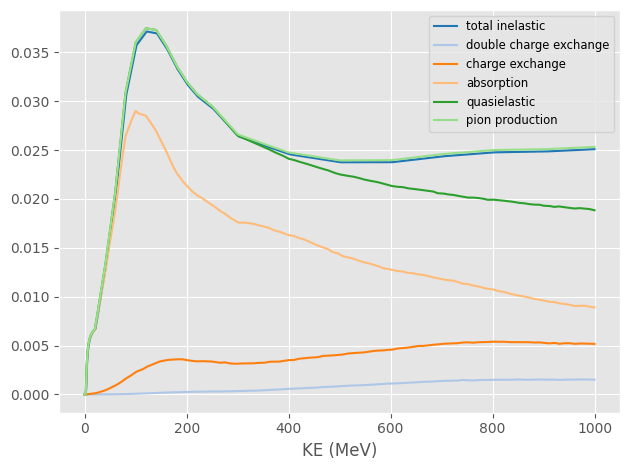

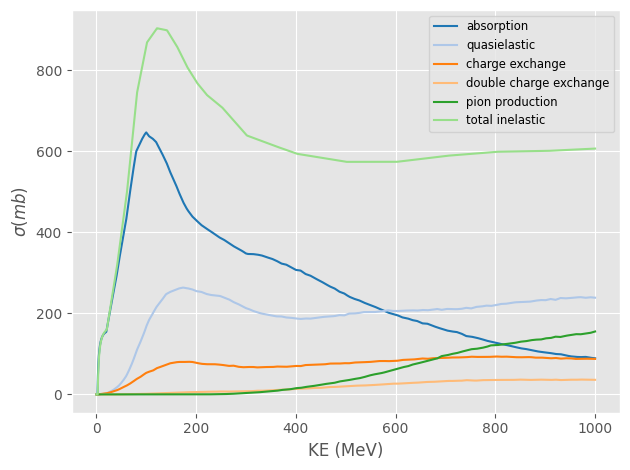

In [10]:
pdfs = cex_toy_generator.GenerateStackedPDFs(2, "data/g4_xs.root")

x = np.linspace(0, 1E3, 1000)
for p in pdfs:
    Plots.Plot(x, pdfs[p](x), newFigure = False, label = p.replace("_", " "), xlabel = "KE (MeV)")
pdf.Save()
plt.figure()
geant_xs.Plot("all")
pdf.Save()

# Energy Slice Method

In [12]:
def CalculateXS(toy : pd.DataFrame, energy_slices : cross_section.Slices, smearing : pd.DataFrame = None, use_bb_KE : bool = False) -> dict:
    slice_dEdX = cross_section.EnergySlice.Slice_dEdX(energy_slices, cross_section.Particle.from_pdgid(211))

    KE_init = np.array(toy.KE_init + (0 if smearing is None else smearing.KE_init))
    z_int = np.array(toy.z_int + (0 if smearing is None else smearing.z_int))

    if use_bb_KE is True:
        KE_int = cross_section.BetheBloch.InteractingKE(KE_init, z_int, cross_section.Particle.from_pdgid(211), 50)
    else:
        KE_int = np.array(toy.KE_int + (0 if smearing is None else smearing.KE_int))

    xs = {}
    masks = ["absorption", "charge_exchange", "double_charge_exchange", "pion_production", "quasielastic", "total_inelastic"]
    for m in masks:
        n_interact, n_incident = cross_section.EnergySlice.CountingExperiment(KE_int, KE_init, toy.z_int < 0, toy[m], energy_slices)
        xs[m] = cross_section.EnergySlice.CrossSection(n_interact, n_incident, slice_dEdX, energy_slices.width)
    return xs


def PlotXS(xs : list[dict], energy_slices : cross_section.Slices, labels : list[str]):
    for _, c in Plots.IterMultiPlot(xs[0], sharex = True):
        geant_xs.Plot(c)
        for x, l in zip(xs, labels):
            Plots.Plot(energy_slices.pos - energy_slices.width/2, x[c][0], xerr = energy_slices.width/2, yerr = x[c][1], marker = "x", linestyle = "", newFigure = False, label = l, title = c)
        plt.ylim(0, 1.5 * max(getattr(geant_xs, c)))

def Effective_distance():
    """ Plot effective distance for the enregy slice method, for a given set of slice thicknesses
    """
    widths = [10, 25, 50, 75, 100]
    for w in widths:
        energy_slices = cross_section.Slices(w, 0, 1000, reversed = True)
        slice_dEdX = cross_section.EnergySlice.Slice_dEdX(energy_slices, cross_section.Particle.from_pdgid(211))
        Plots.Plot(energy_slices.pos, energy_slices.width / slice_dEdX, xlabel = "slice KE (MeV)", ylabel = "effictive distance (cm)", newFigure = False, label = f"{w}MeV")
    plt.axhline(2, color = "black", linestyle = "--", label = "simulation step size (cm)")
    plt.legend()
    pdf.Save()


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:162: RuntimeWarning: invalid value encountered in sqrt
  beta = (1 - (1/gamma)**2)**0.5
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(


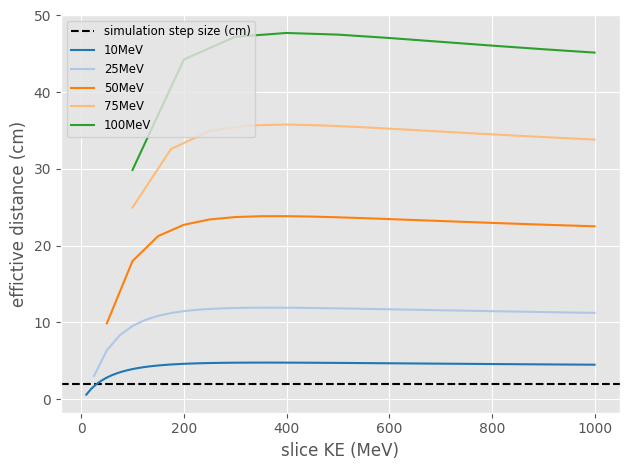

In [13]:
Effective_distance()

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:162: RuntimeWarning: invalid value encountered in sqrt
  beta = (1 - (1/gamma)**2)**0.5
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:680: RuntimeWarning: divide by zero encountered in divide
  xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:685: RuntimeWarning: divide by zero encountered in divide
  xs_e = (1/n_incident) * (1/(n_incident - n_interact)) * (n_interact**2 * v_incident + n_incident**2 * v_interact)**0.5
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in mul

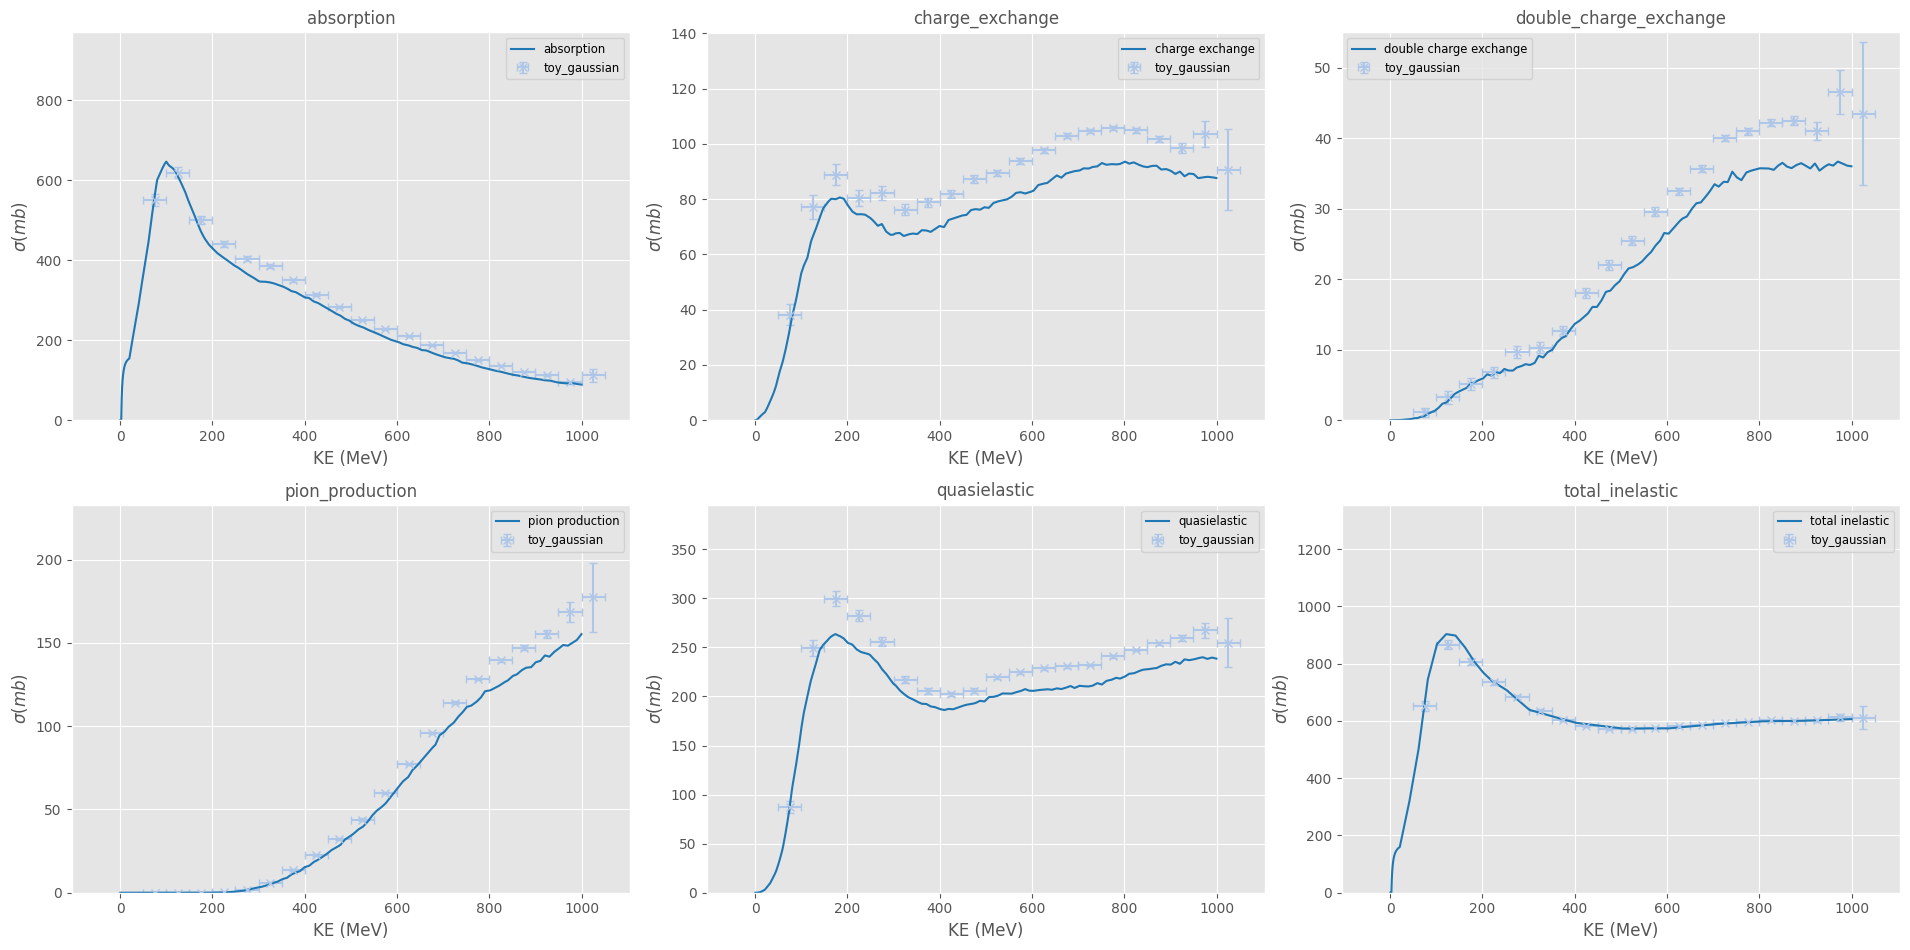

In [14]:
energy_slices = cross_section.Slices(50, 0, 1050, True)
xs = CalculateXS(toy_gaussian.df, energy_slices, use_bb_KE = True)
PlotXS([xs], energy_slices, labels = ["toy_gaussian"])

# Smearing

In [15]:
pdf = Plots.PlotBook("xs_toy_smearing_mc_driven.pdf", open = False)

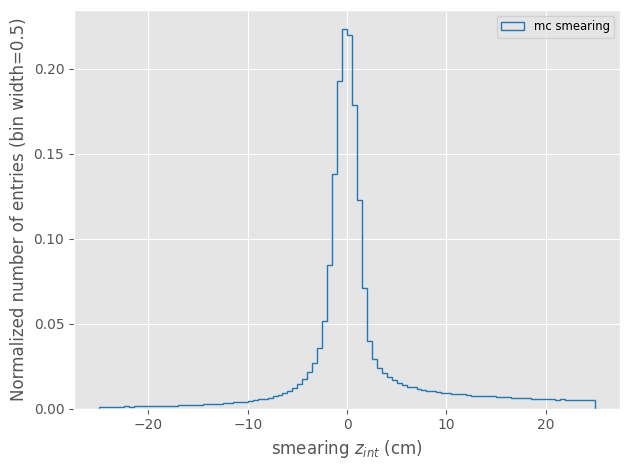

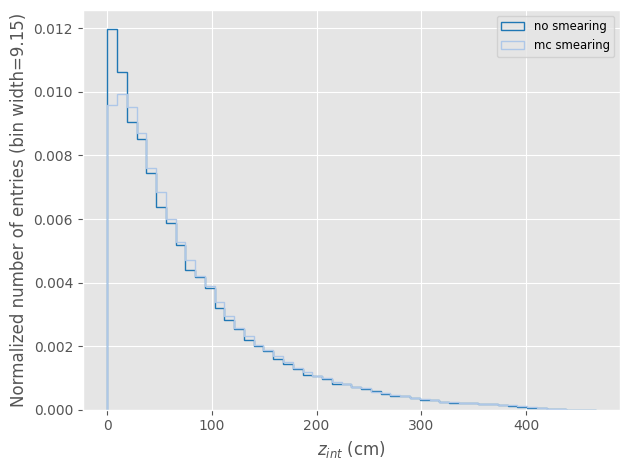

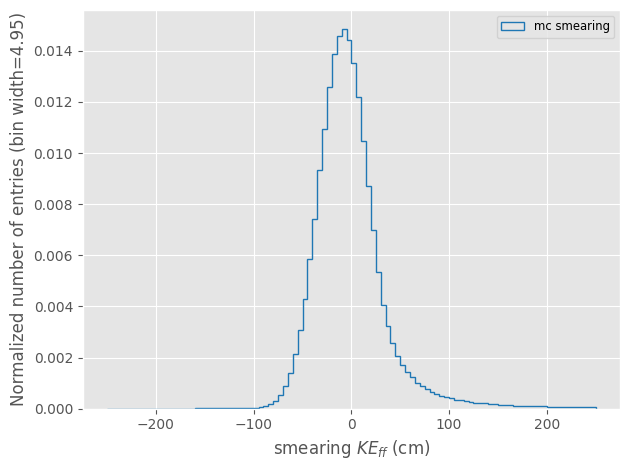

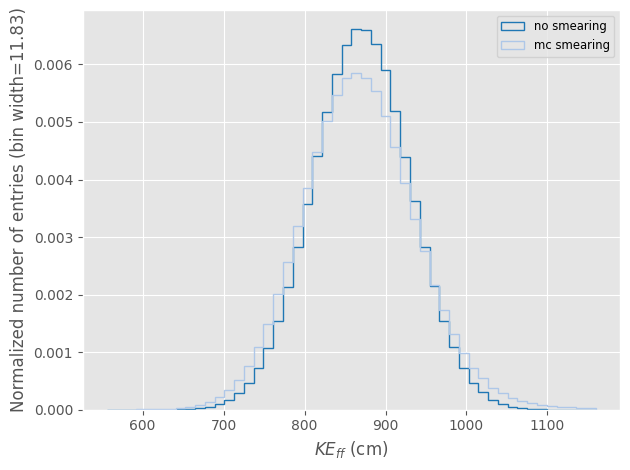

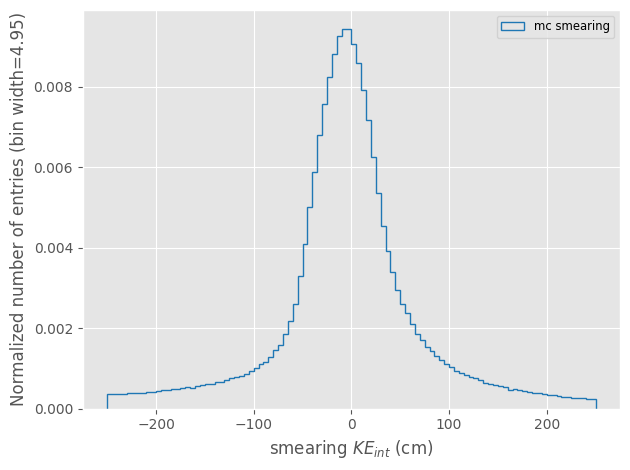

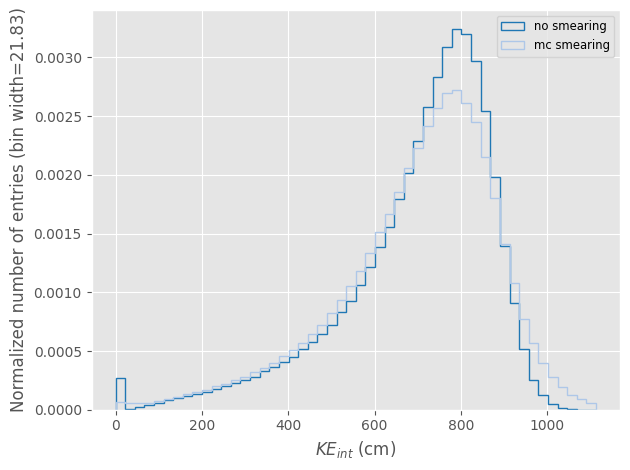

In [16]:
def PlotSmearing(toy : pd.DataFrame, smearings : list[pd.DataFrame], quantity : str, quantity_label : str, smearing_labels : list[str], smearing_range : list = None):
    data = [toy[quantity]]
    for s in smearings:
        data.append(toy[quantity] + s[quantity])
    Plots.PlotHistComparison([s[quantity] for s in smearings], xlabel = "smearing " + quantity_label, labels = smearing_labels, x_range = smearing_range)
    pdf.Save()
    Plots.PlotHistComparison(data, labels = ["no smearing"] + smearing_labels, bins = 50, xlabel = quantity_label)
    pdf.Save()

mc_driven_smearing = {
    "KE_int" : toy_gaussian.df.KE_int_smearing,
    "KE_init" : toy_gaussian.df.KE_init_smearing,
    "z_int" : toy_gaussian.df.z_int_smearing 
}

PlotSmearing(toy_gaussian.df, [mc_driven_smearing], "z_int", "$z_{int}$ (cm)", ["mc smearing"], [-50, 50])
PlotSmearing(toy_gaussian.df, [mc_driven_smearing], "KE_init", "$KE_{ff}$ (cm)", ["mc smearing"], [-250, 250])
PlotSmearing(toy_gaussian.df, [mc_driven_smearing], "KE_int", "$KE_{int}$ (cm)", ["mc smearing"], [-250, 250])

In [ ]:
def PlotSmearingMCComparison(mc_quantities : dict, toy : pd.DataFrame, smearing : pd.DataFrame, quantity : str, smearing_label : str, plot_range : list, quantitity_label : str):
    multiplot = Plots.MultiPlot(2, True, False)
    next(multiplot)
    Plots.PlotHistComparison([mc_quantities["true"][quantity], toy[quantity]], labels = ["MC truth", "toy without smearing"], x_range = plot_range, xlabel = quantitity_label, newFigure = False, bins = 50)
    next(multiplot)
    Plots.PlotHistComparison([mc_quantities["reco"][quantity], toy[quantity] + smearing[quantity]], labels = ["MC reco", f"toy with {smearing_label}"], x_range = plot_range, xlabel = quantitity_label, newFigure = False, bins = 50)

PlotSmearingMCComparison(mc_quantities, toy_gaussian.df, mc_driven_smearing, "KE_init", "mc smearing", [500, 1250], "$KE_{ff}$ (MeV)")
pdf.Save()
PlotSmearingMCComparison(mc_quantities, toy_gaussian.df, mc_driven_smearing, "KE_int", "mc smearing", [0, 1250], "$KE_{int}$ (MeV)")
pdf.Save()
PlotSmearingMCComparison(mc_quantities, toy_gaussian.df, mc_driven_smearing, "z_int", "mc smearing", [0, 700], "$z_{int}$ (MeV)")
pdf.Save()
pdf.close()

# Beam Particle Selection Efficiency

In [ ]:
beam_selection_efficiencies = cex_toy_generator.ReadHDF5File("work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/pi_beam_efficiency/beam_selection_efficiencies_true.hdf5")

probability = {
    "track_length" : cex_toy_generator.BeamSelectionEfficiency(toy_gaussian.df, "z_int", beam_selection_efficiencies).beam_selection_mask,
    "KE_ff" : cex_toy_generator.BeamSelectionEfficiency(toy_gaussian.df, "z_int", beam_selection_efficiencies).beam_selection_mask,
    "KE_int" : cex_toy_generator.BeamSelectionEfficiency(toy_gaussian.df, "z_int", beam_selection_efficiencies).beam_selection_mask
    }

U = np.random.uniform(0, 1, len(toy_gaussian.df))

for p in probability:
    print(p)
    passed = U < probability[p]
    for _, c in Plots.IterMultiPlot(["z_int", "KE_int", "KE_init"]):
        Plots.PlotHistComparison([toy_gaussian.df[c][passed.values] + mc_driven_smearing[c][passed.values], mc_quantities["reco"][c]], labels = ["toy", "MC reco"], xlabel = c, bins = 50, y_scale = "linear", newFigure = False)
    plt.show()

# Reco regions for the toy

In [17]:
pdf = Plots.PlotBook("toy_reco_regions.pdf", open = True)

pdf toy_reco_regions.pdf has been opened


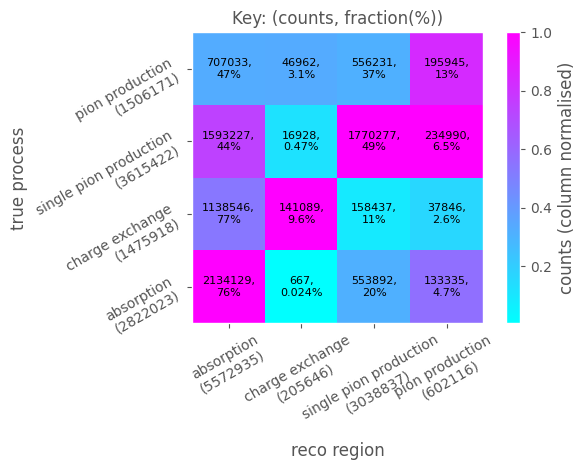

In [18]:
counts = toy_gaussian.GetCorrelationMatrix(toy_gaussian.df)
cex_toy_parameters.PlotCorrelationMatrix(counts, toy_gaussian.truth_region_labels, toy_gaussian.reco_region_labels)
pdf.Save()

pdf toy_reco_regions.pdf has been closed


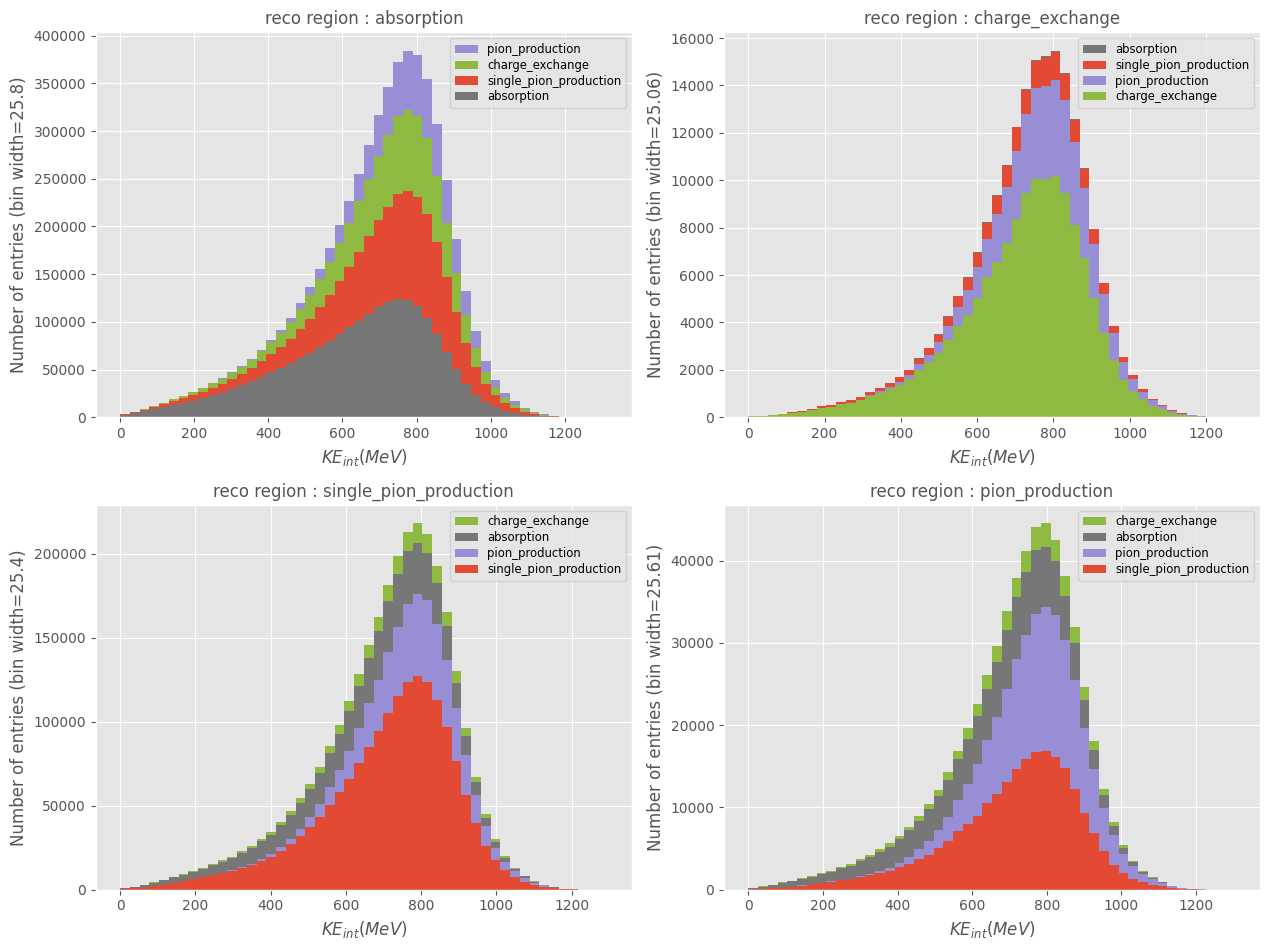

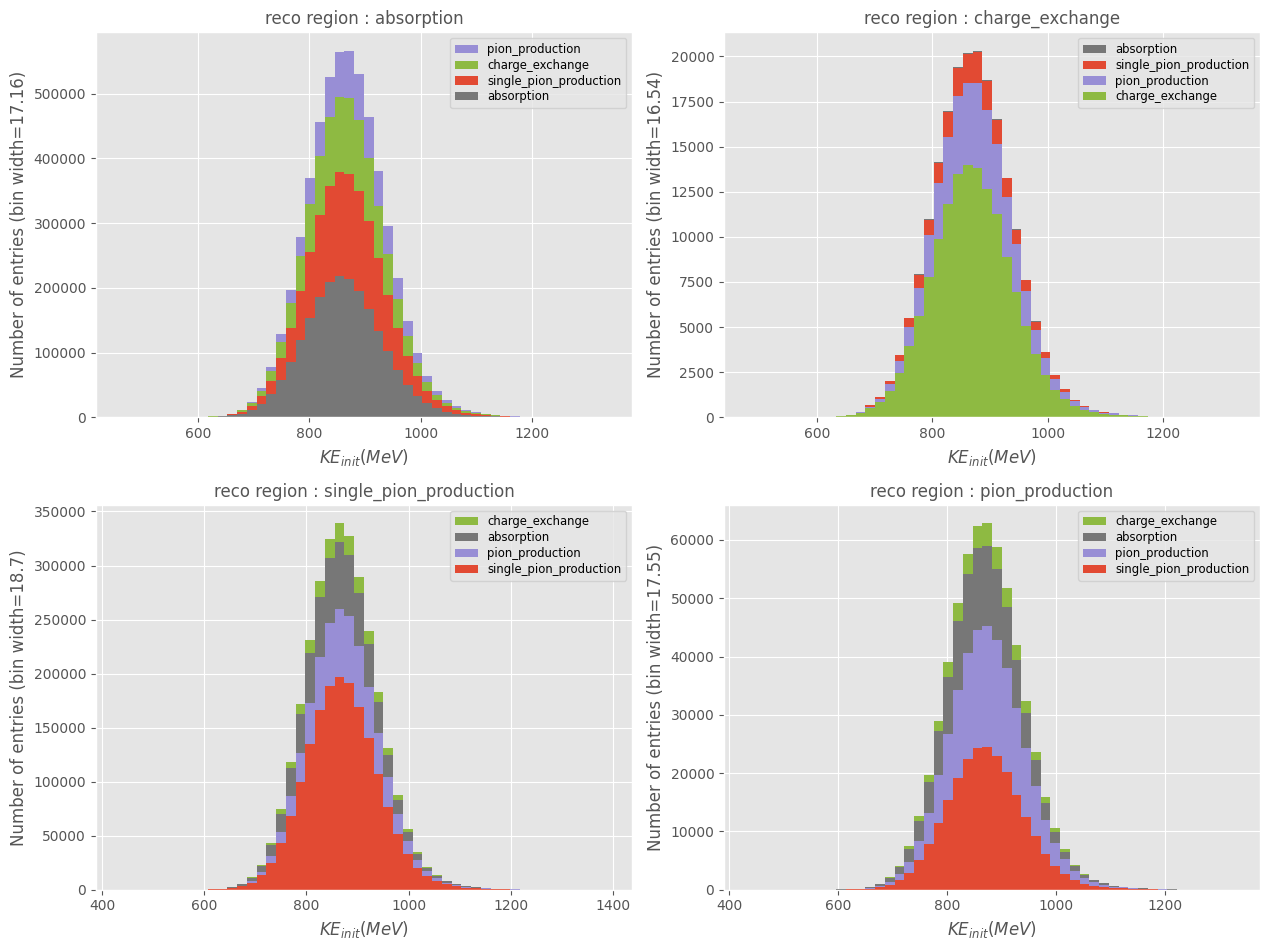

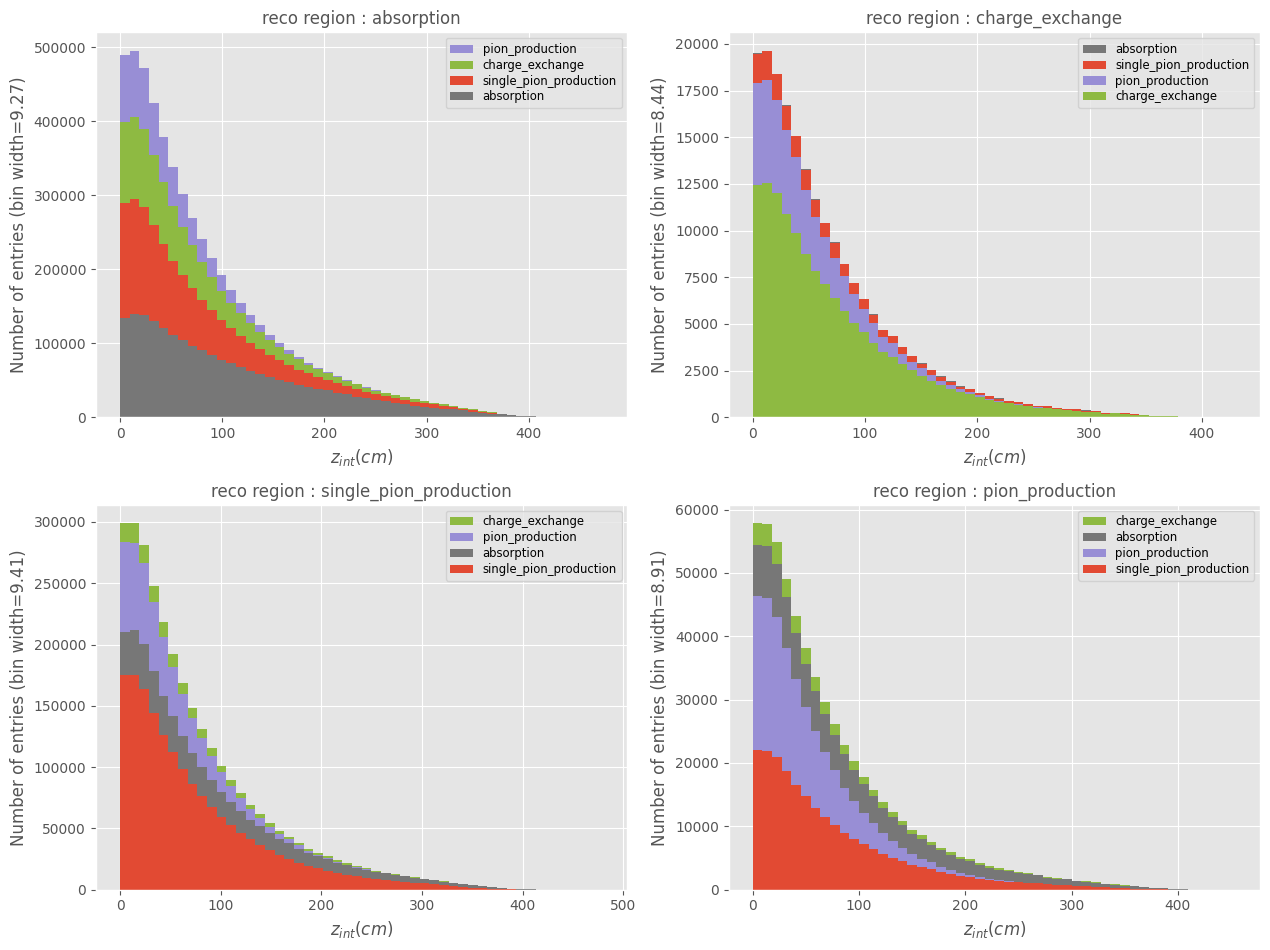

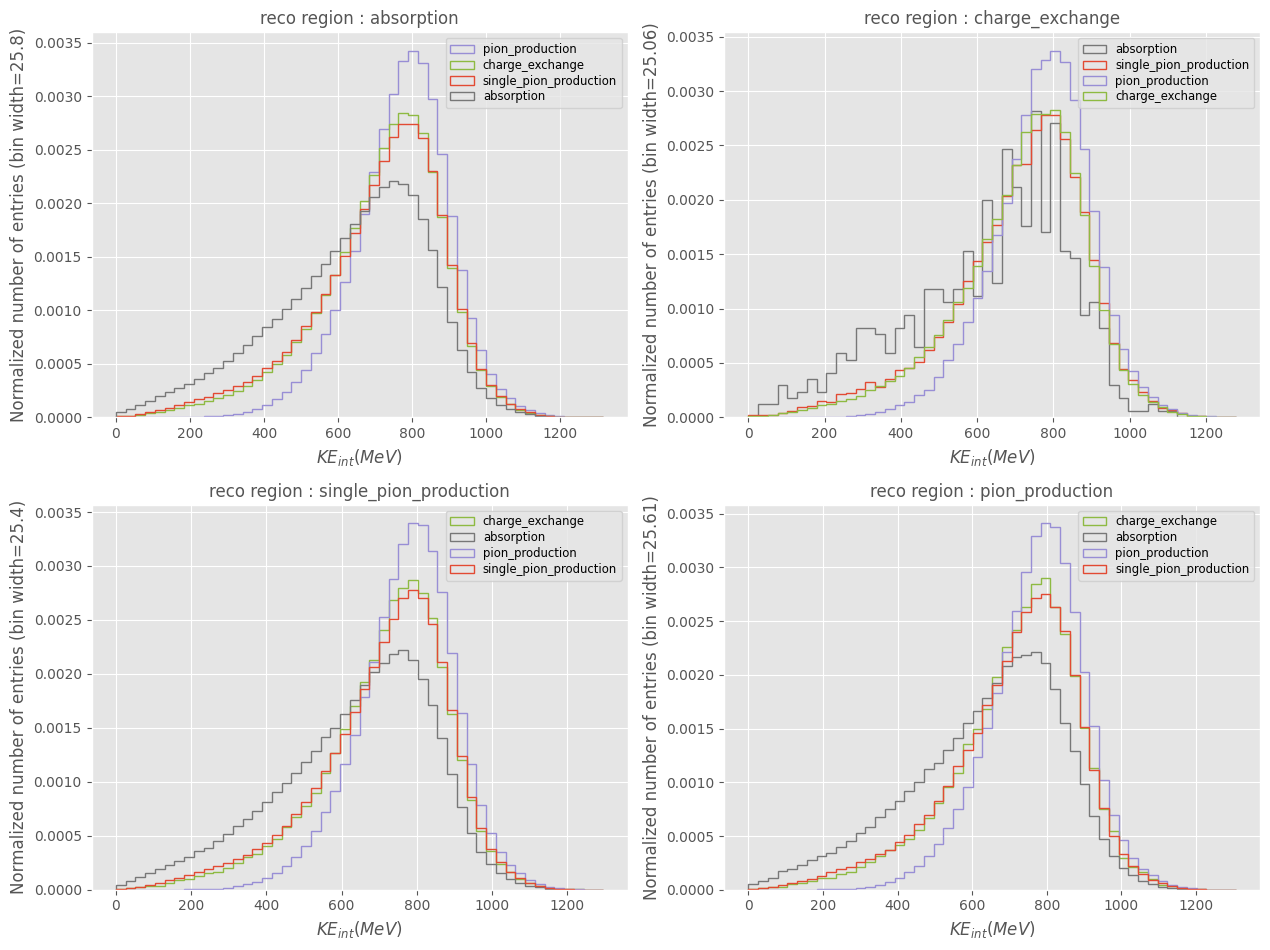

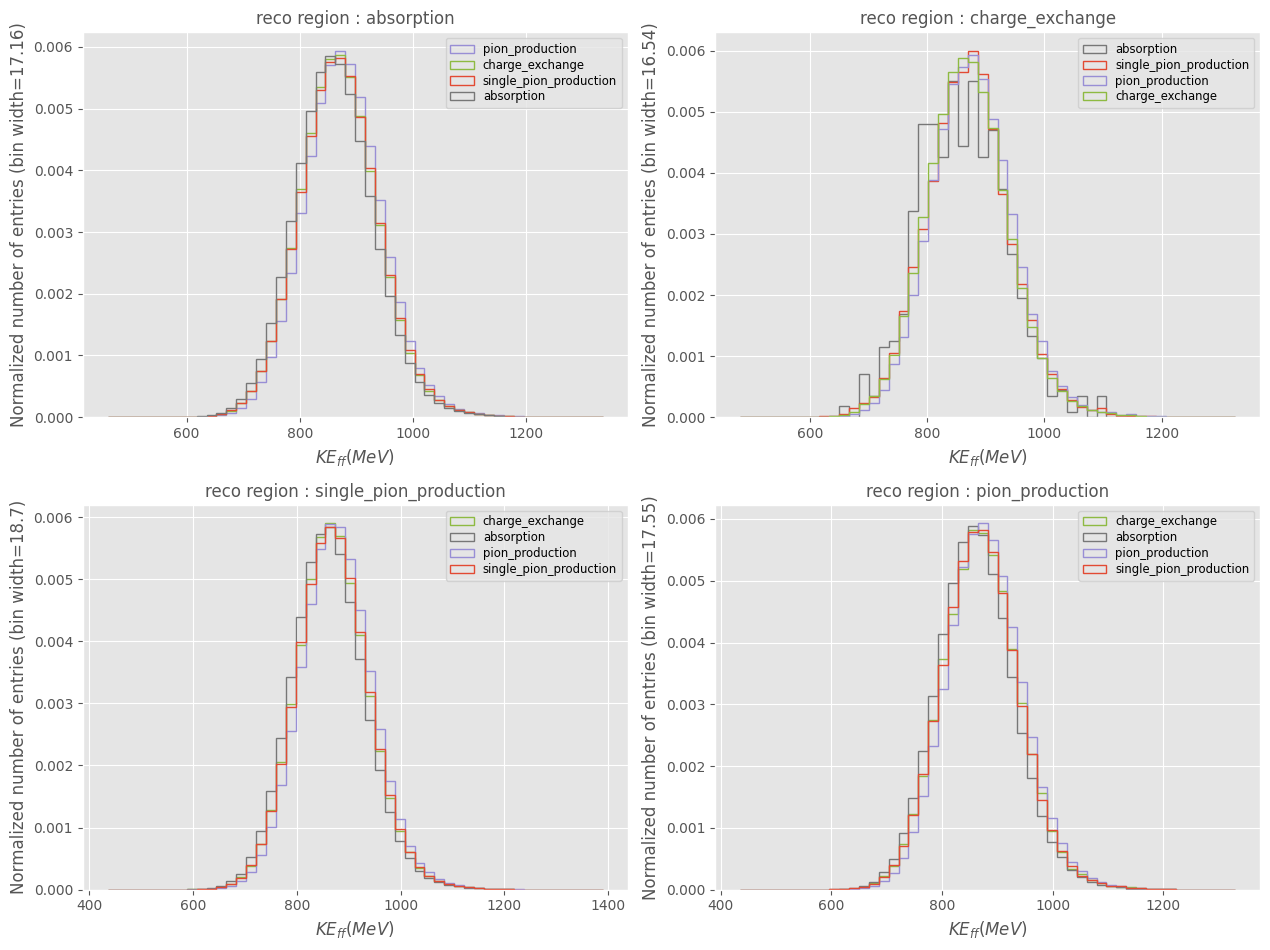

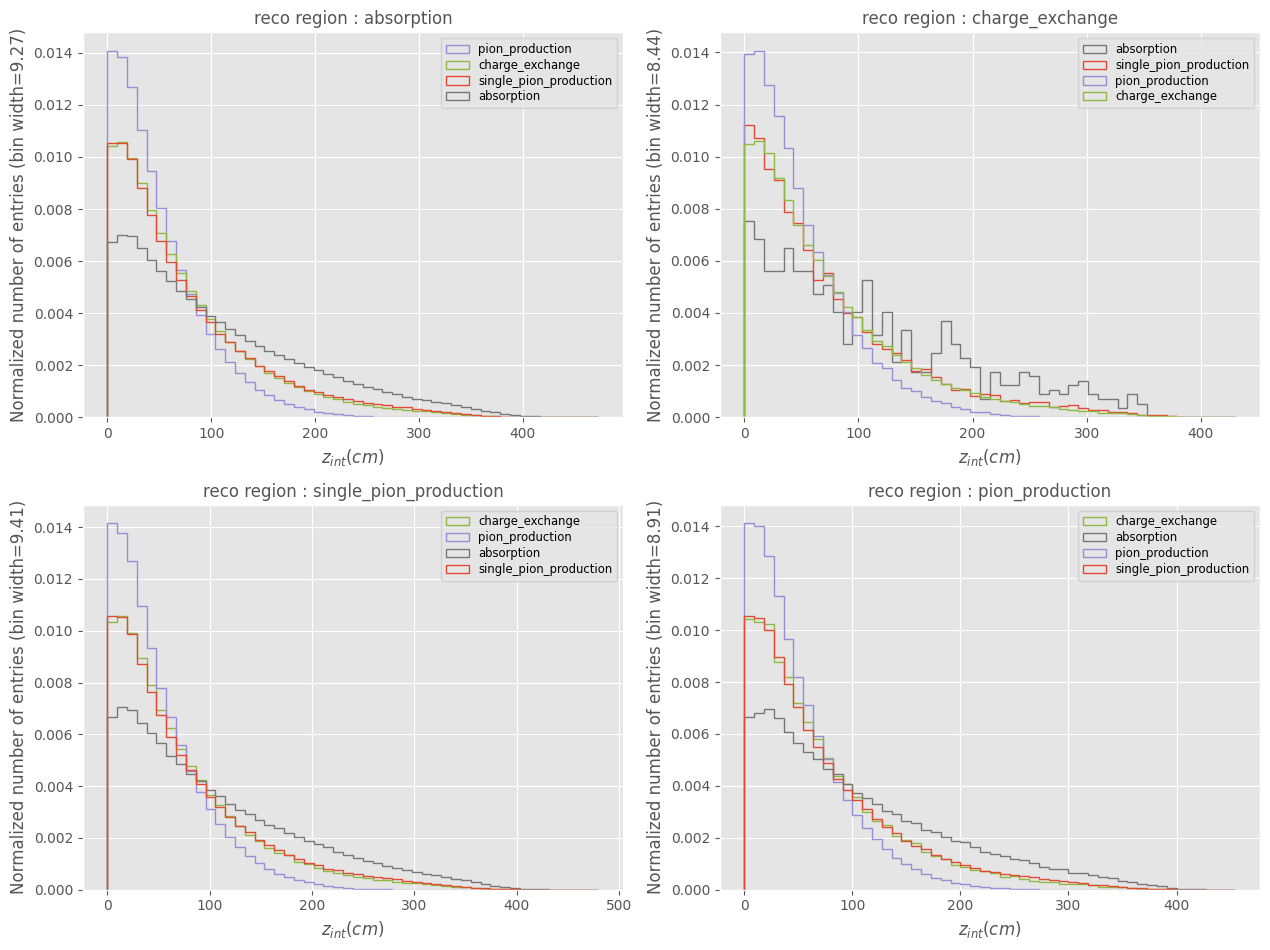

In [19]:
toy_gaussian.PlotObservablesInRegions(toy_gaussian.df.KE_int_smeared, toy_gaussian.reco_regions, toy_gaussian.truth_regions, "$KE_{int} (MeV)$", stacked = True, histtype = "stepfilled")
toy_gaussian.PlotObservablesInRegions(toy_gaussian.df.KE_init_smeared, toy_gaussian.reco_regions, toy_gaussian.truth_regions, "$KE_{init} (MeV)$", stacked = True, histtype = "stepfilled")
toy_gaussian.PlotObservablesInRegions(toy_gaussian.df.z_int_smeared, toy_gaussian.reco_regions, toy_gaussian.truth_regions, "$z_{int} (cm)$", stacked = True, histtype = "stepfilled")

toy_gaussian.PlotObservablesInRegions(toy_gaussian.df.KE_int_smeared, toy_gaussian.reco_regions, toy_gaussian.truth_regions, "$KE_{int} (MeV)$", norm = True)
toy_gaussian.PlotObservablesInRegions(toy_gaussian.df.KE_init_smeared, toy_gaussian.reco_regions, toy_gaussian.truth_regions, "$KE_{ff} (MeV)$", norm = True)
toy_gaussian.PlotObservablesInRegions(toy_gaussian.df.z_int_smeared, toy_gaussian.reco_regions, toy_gaussian.truth_regions, "$z_{int} (cm)$", norm = True)
pdf.close()

# Modified cross section 

In [13]:
energy_slices = cross_section.Slices(50, 0, 1050, True)
n_end, n_incident = cross_section.EnergySlice.CountingExperiment(toy_gaussian.df.KE_int, toy_gaussian.df.KE_init, toy_gaussian.df.z_int < 0, toy_gaussian.df.total_inelastic, energy_slices)
n_interact, n_incident_ex = cross_section.EnergySlice.CountingExperiment(toy_gaussian.df.KE_int, toy_gaussian.df.KE_init, toy_gaussian.df.z_int < 0, toy_gaussian.df.charge_exchange, energy_slices)

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:162: RuntimeWarning: invalid value encountered in sqrt
  beta = (1 - (1/gamma)**2)**0.5
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:680: RuntimeWarning: divide by zero encountered in divide
  xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:685: RuntimeWarning: divide by zero encountered in divide
  xs_e = (1/n_incident) * (1/(n_incident - n_interact)) * (n_interact**2 * v_incident + n_incident**2 * v_interact)**0.5
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in mul

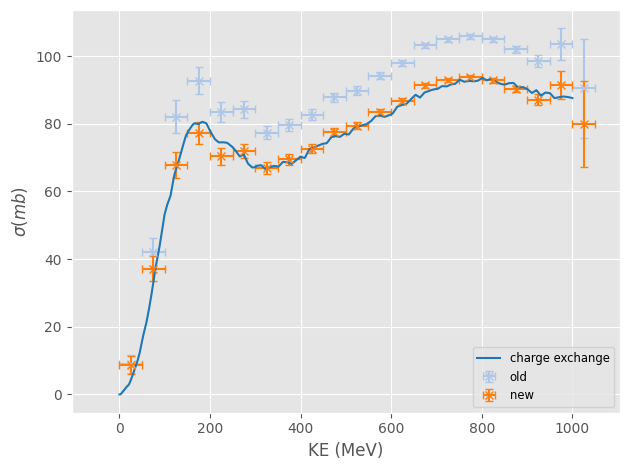

In [14]:
slice_dEdX = cross_section.EnergySlice.Slice_dEdX(energy_slices, cross_section.Particle.from_pdgid(211))
xs_old = cross_section.EnergySlice.CrossSection(n_interact, n_incident_ex, slice_dEdX, energy_slices.width)
xs_new = cross_section.EnergySlice.ModifiedCrossSection(n_interact, n_incident_ex, n_end, n_incident, slice_dEdX, energy_slices.width)

geant_xs.Plot("charge_exchange")
Plots.Plot(energy_slices.pos - energy_slices.width/2, xs_old[0], yerr = xs_old[1], xerr = energy_slices.width/2, linestyle = "", marker = "x", label = "old", newFigure = False)
Plots.Plot(energy_slices.pos - energy_slices.width/2, xs_new[0], yerr = xs_new[1], xerr = energy_slices.width/2, linestyle = "", marker = "x", label = "new", newFigure = False)

# Comparing Spatial Slice to MC truth

/tmp/ipykernel_41775/249587869.py:102: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((self.y1_err/self.y1)**2 + (self.y2_err/self.y2)**2)
/tmp/ipykernel_41775/249587869.py:97: RuntimeWarning: divide by zero encountered in divide
  ratio = self.y1 / self.y2
/tmp/ipykernel_41775/249587869.py:97: RuntimeWarning: invalid value encountered in divide
  ratio = self.y1 / self.y2
/tmp/ipykernel_41775/249587869.py:80: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.subplots(2, 1, figsize = (6.4, 4.8 * 1.2), gridspec_kw={"height_ratios" : [5, 1]} , sharex = True) # set to that the ratio plot is 1/5th the default plot height


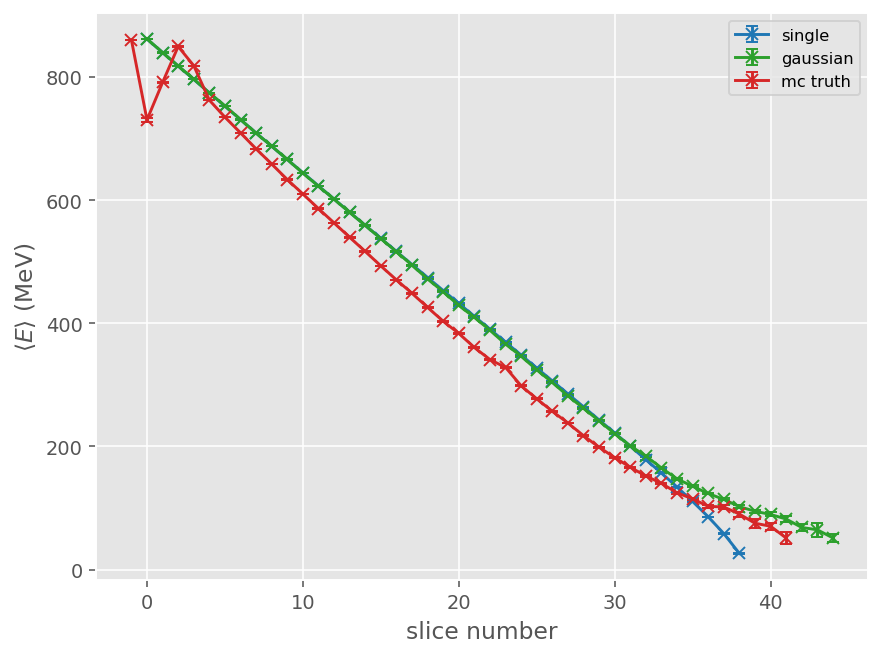

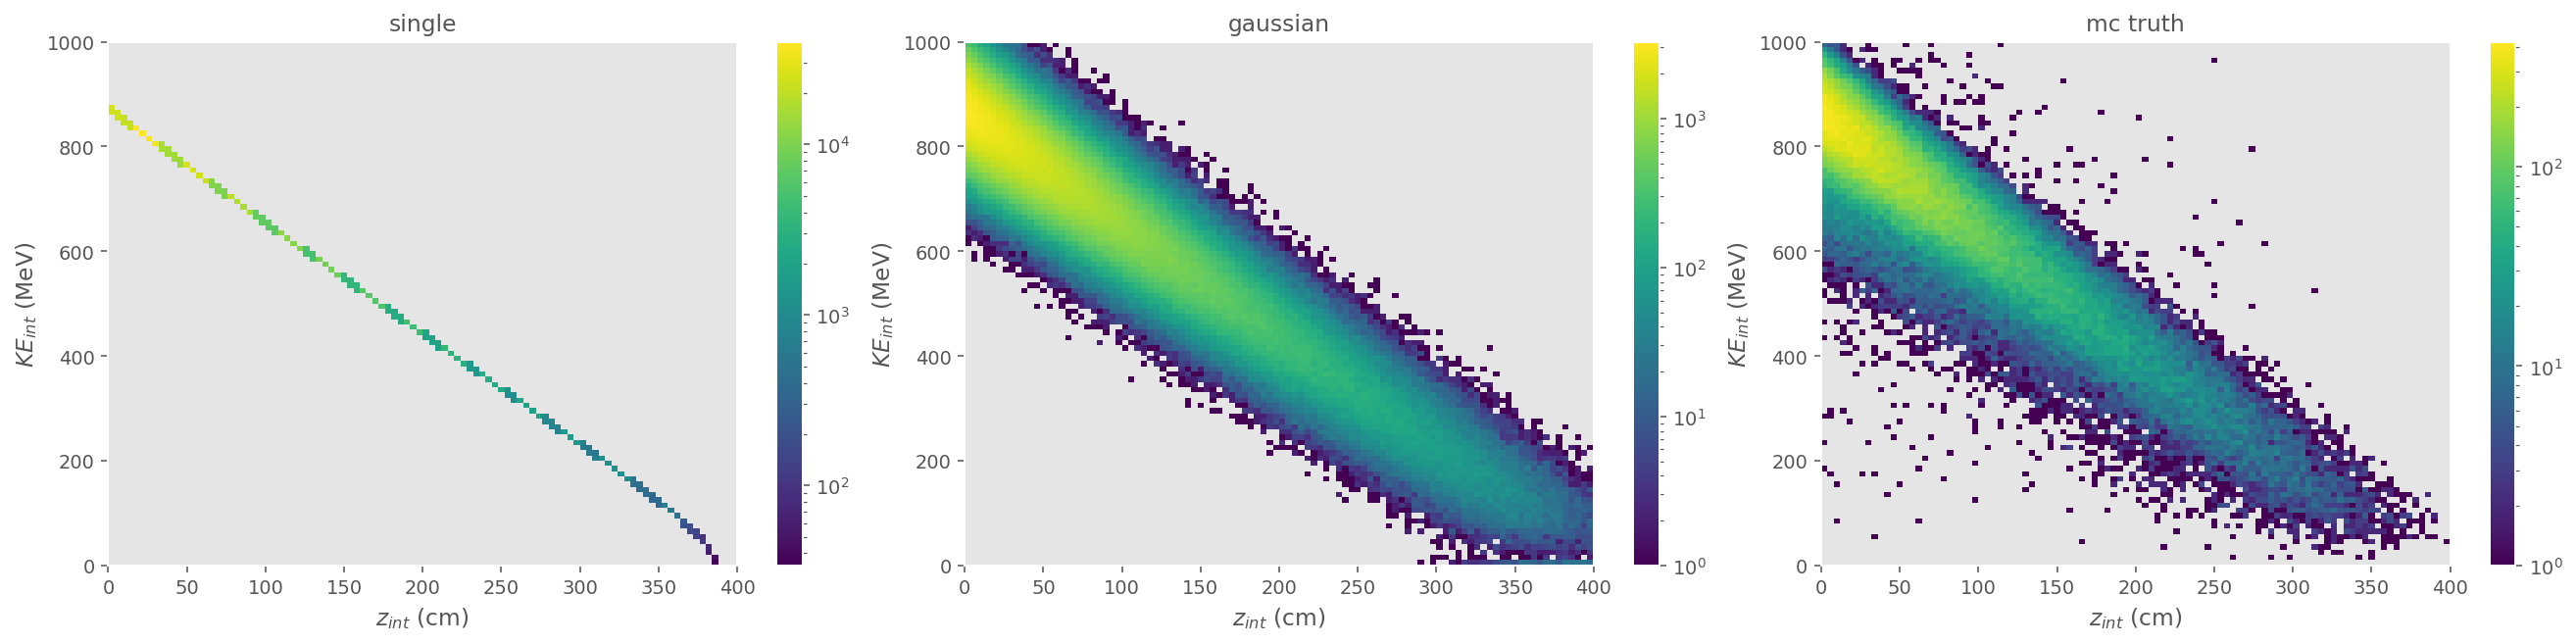

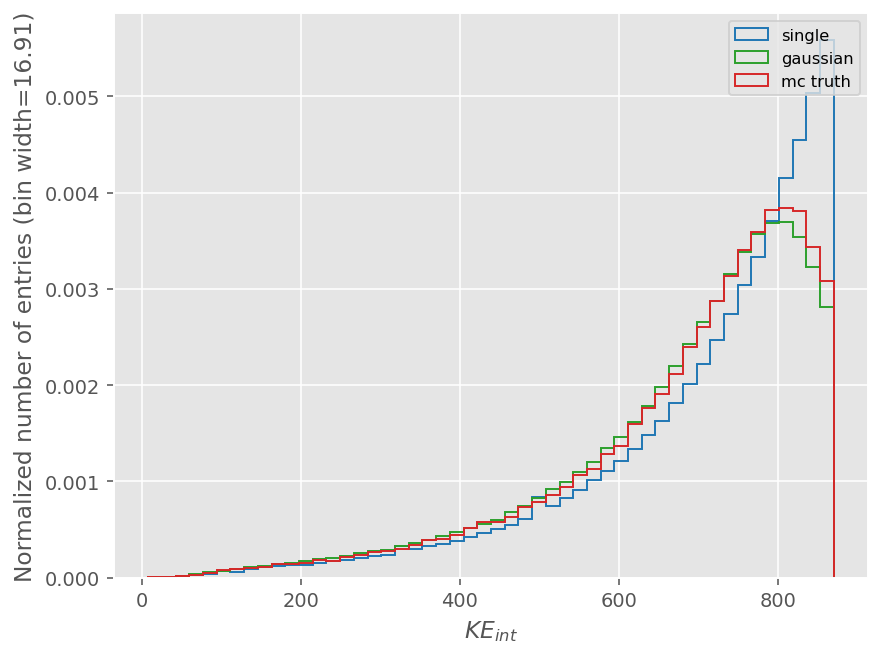

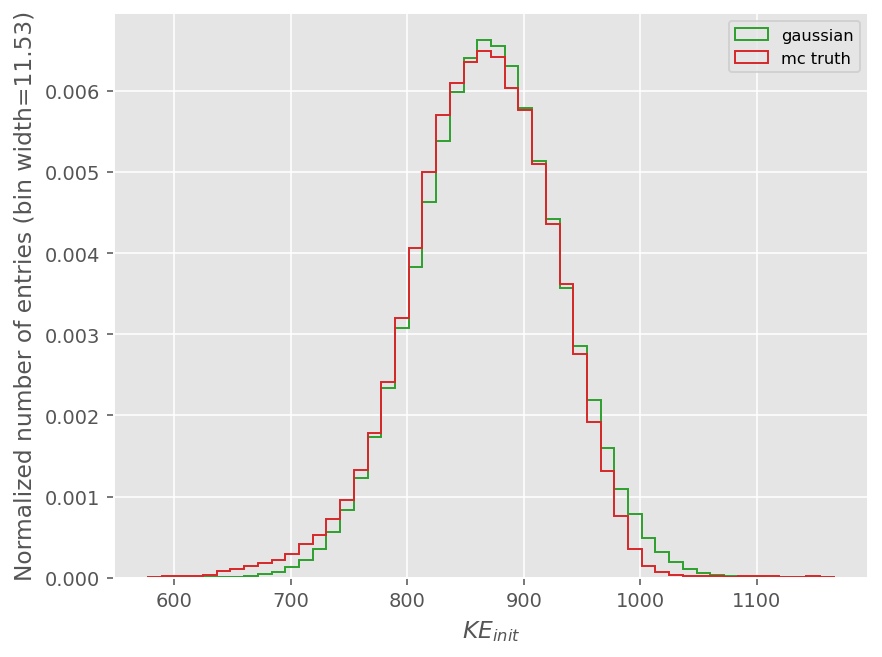

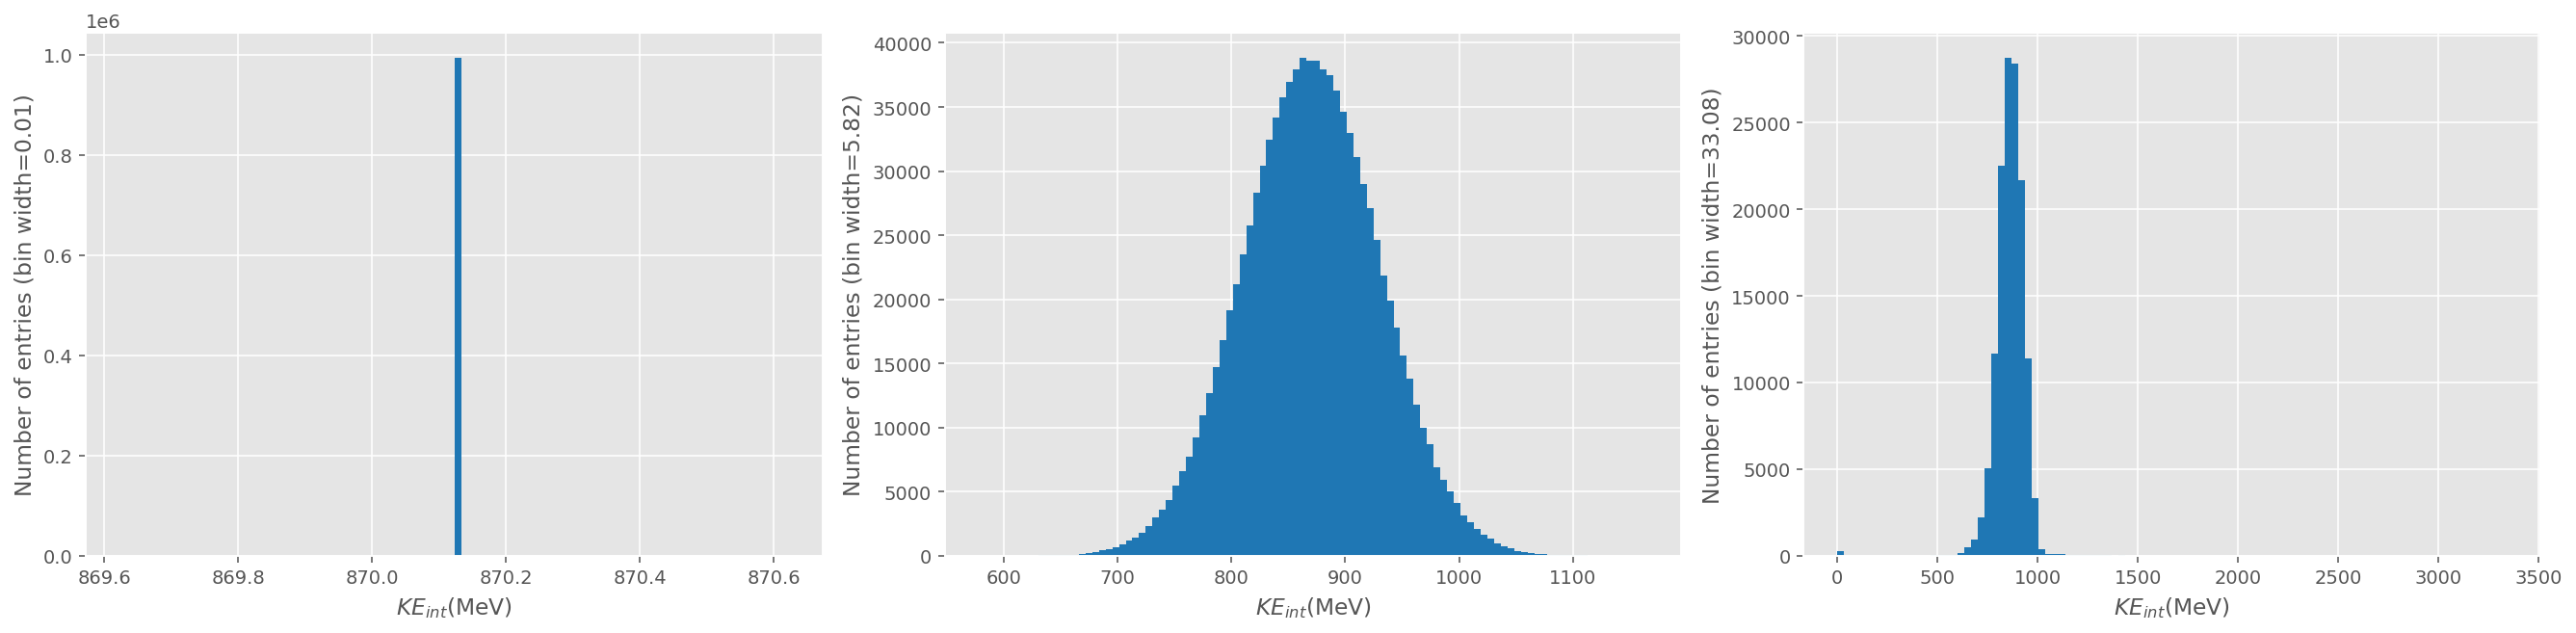

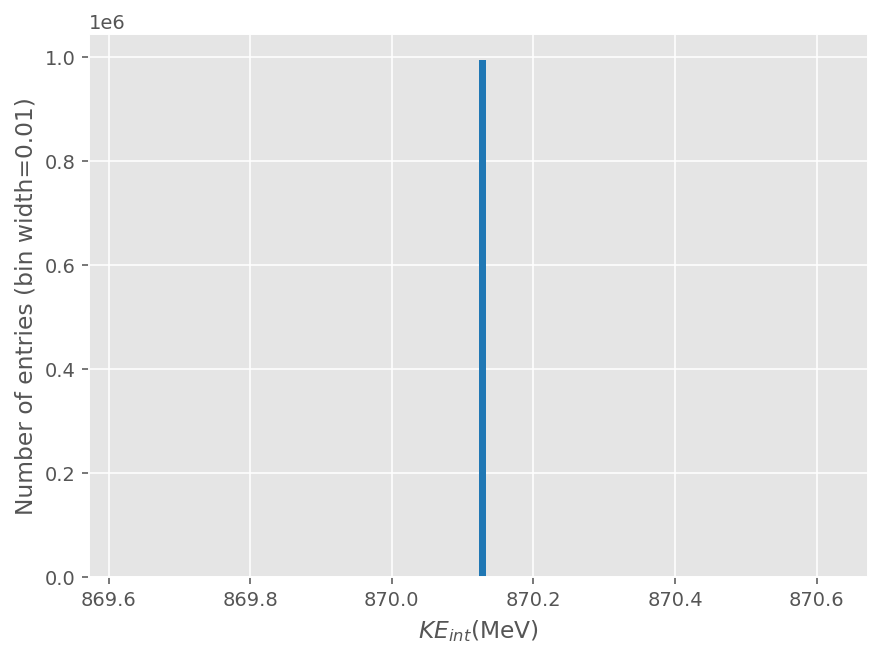

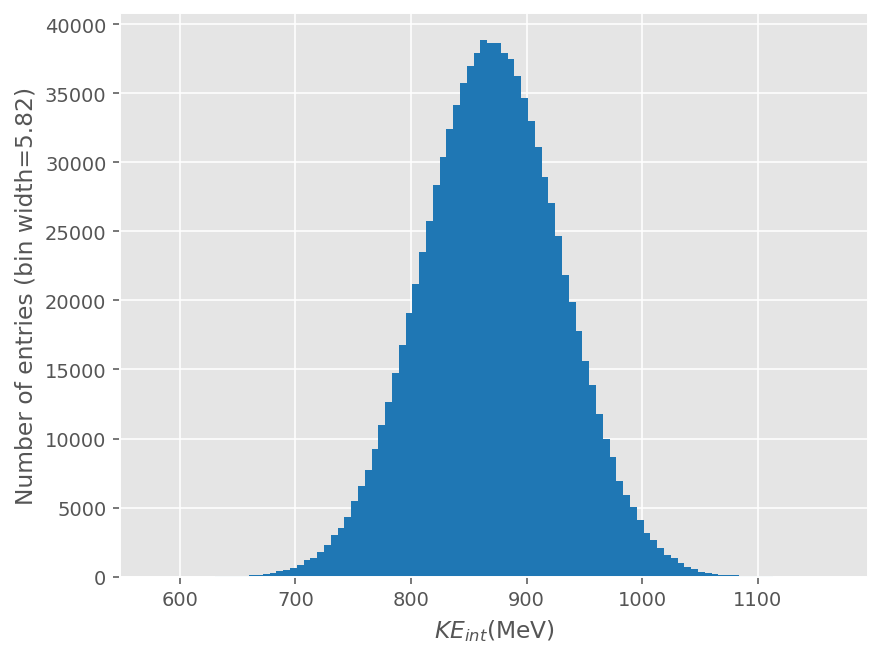

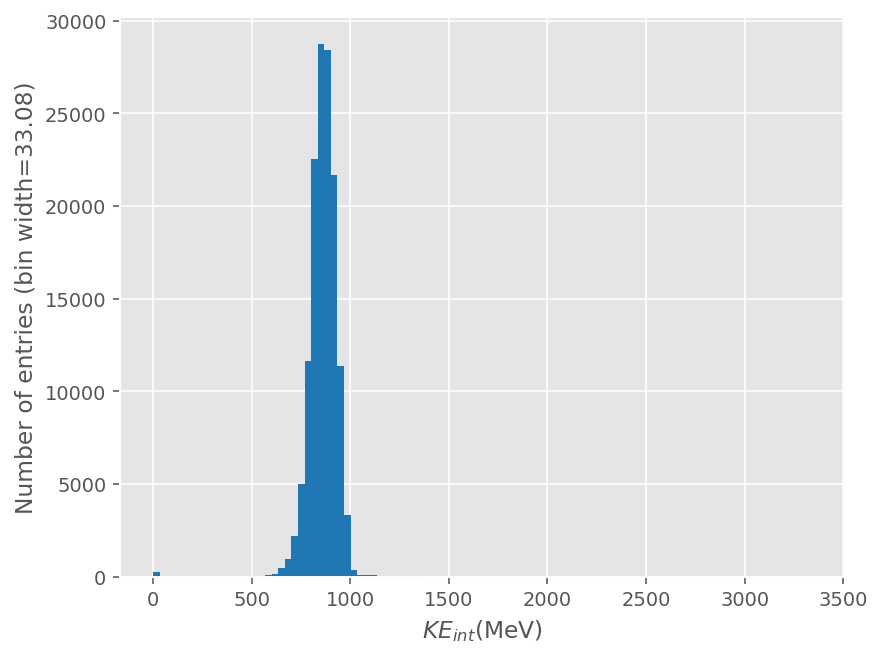

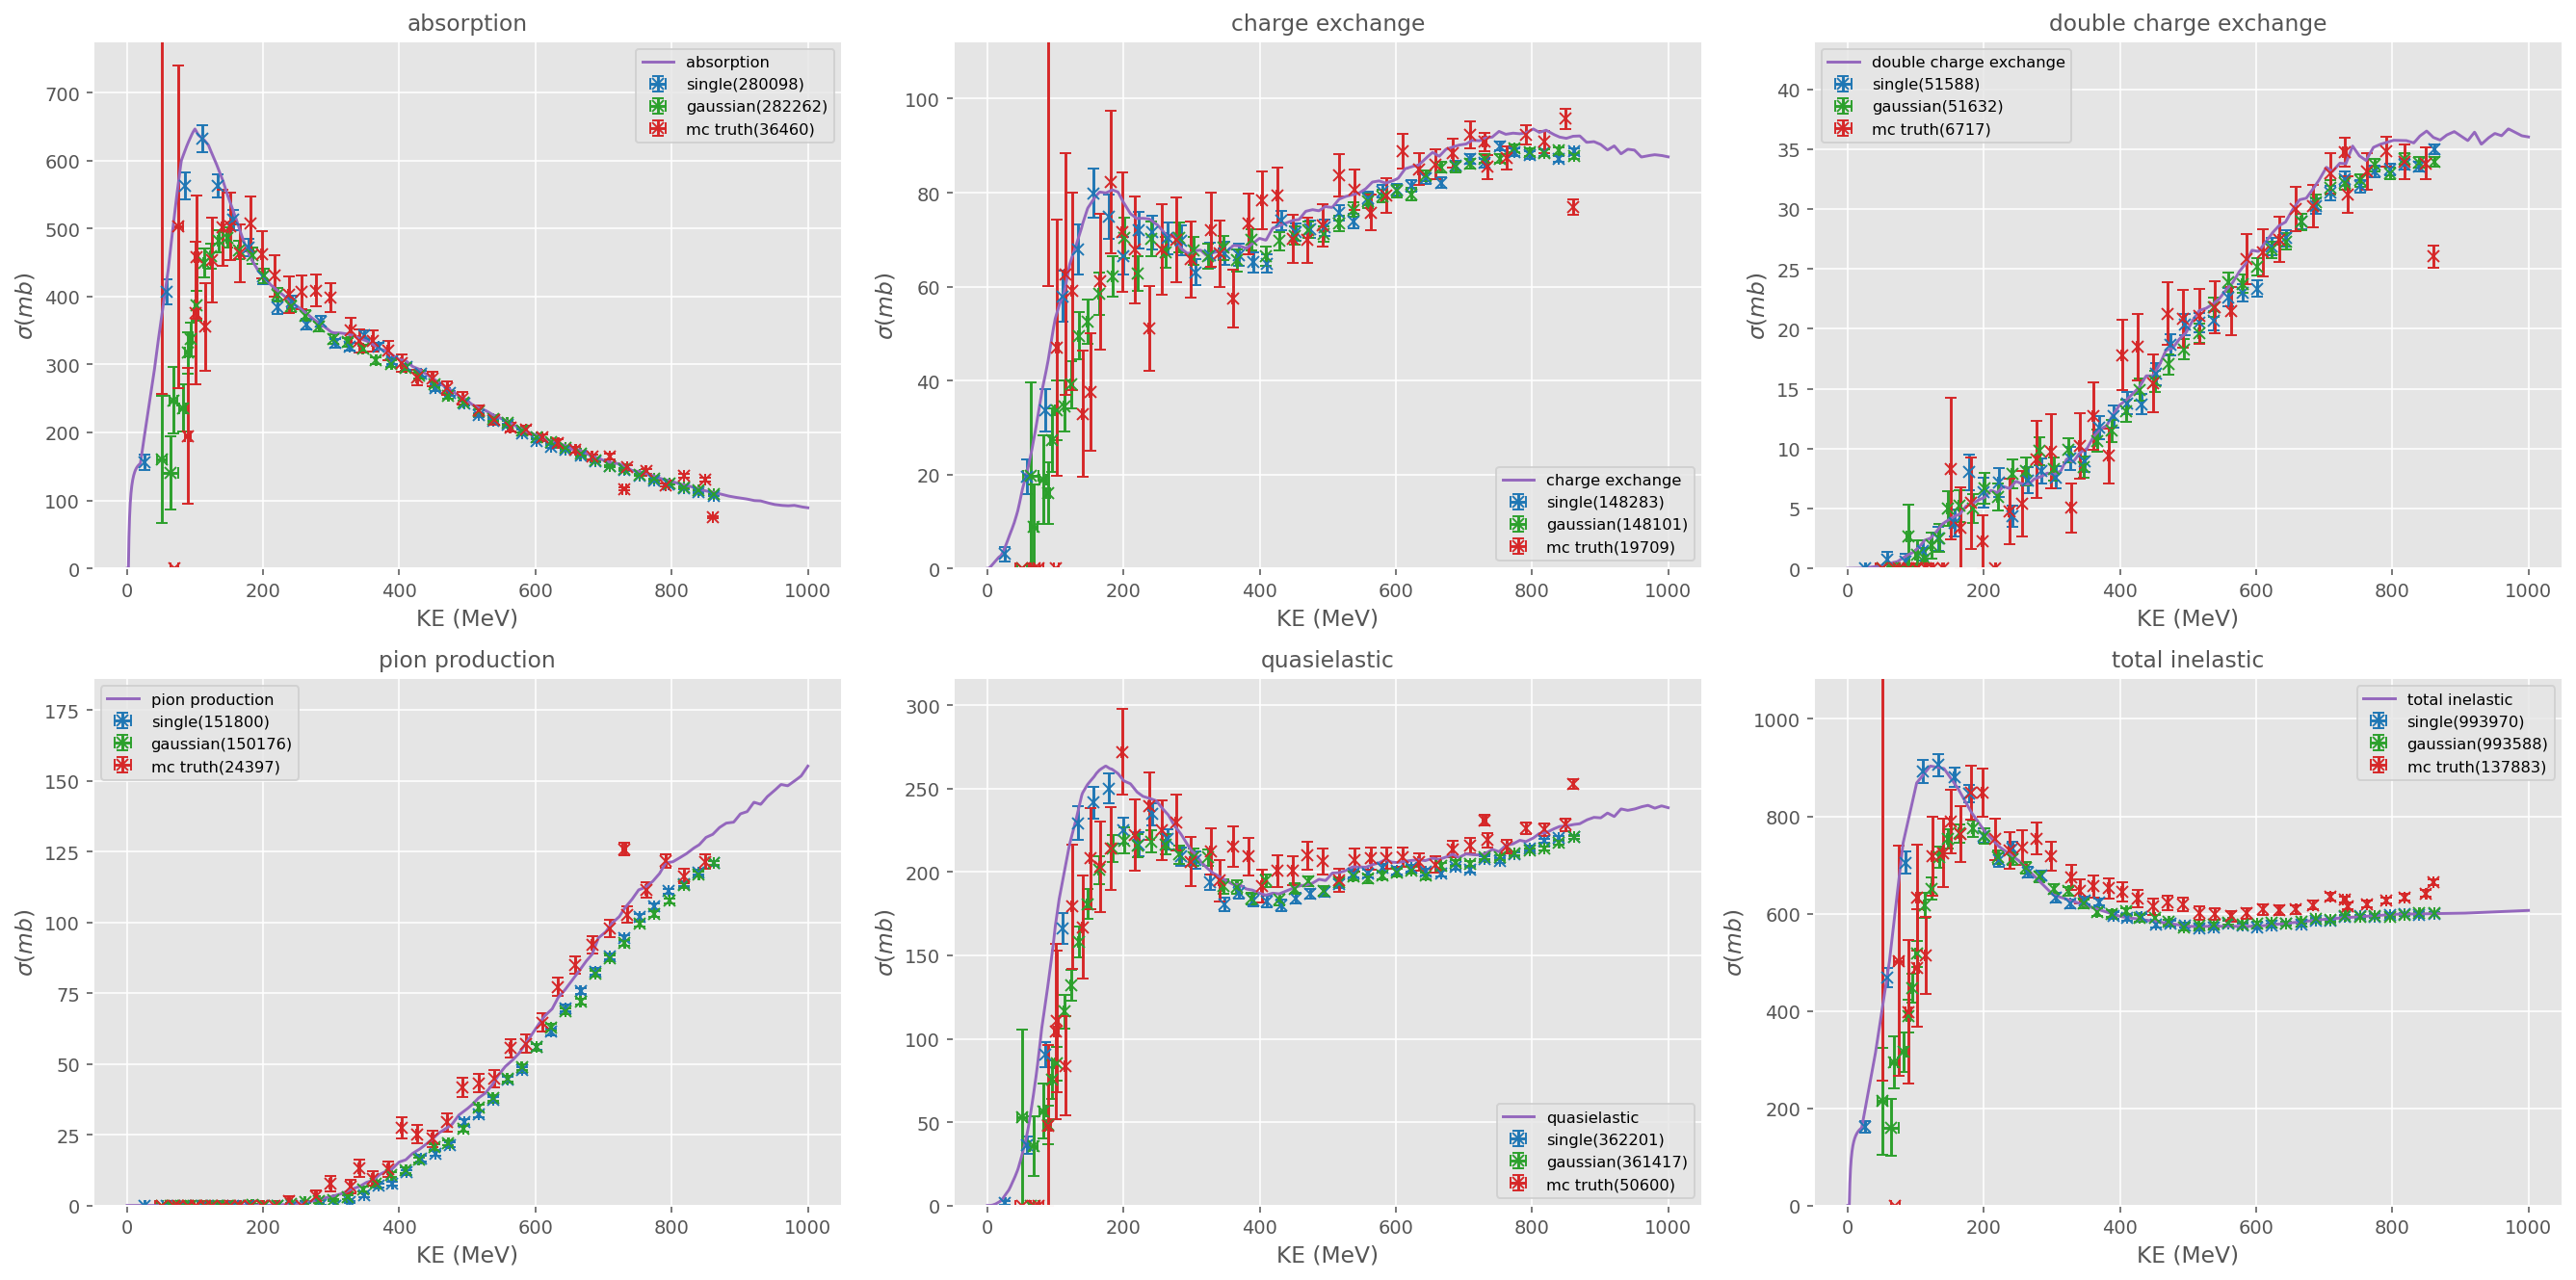

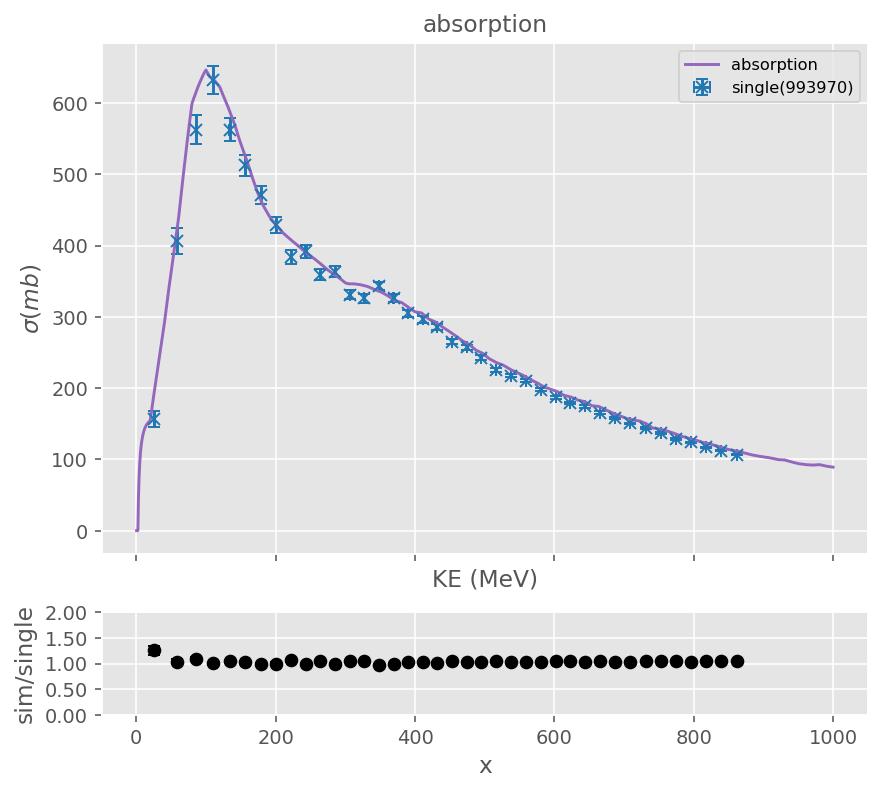

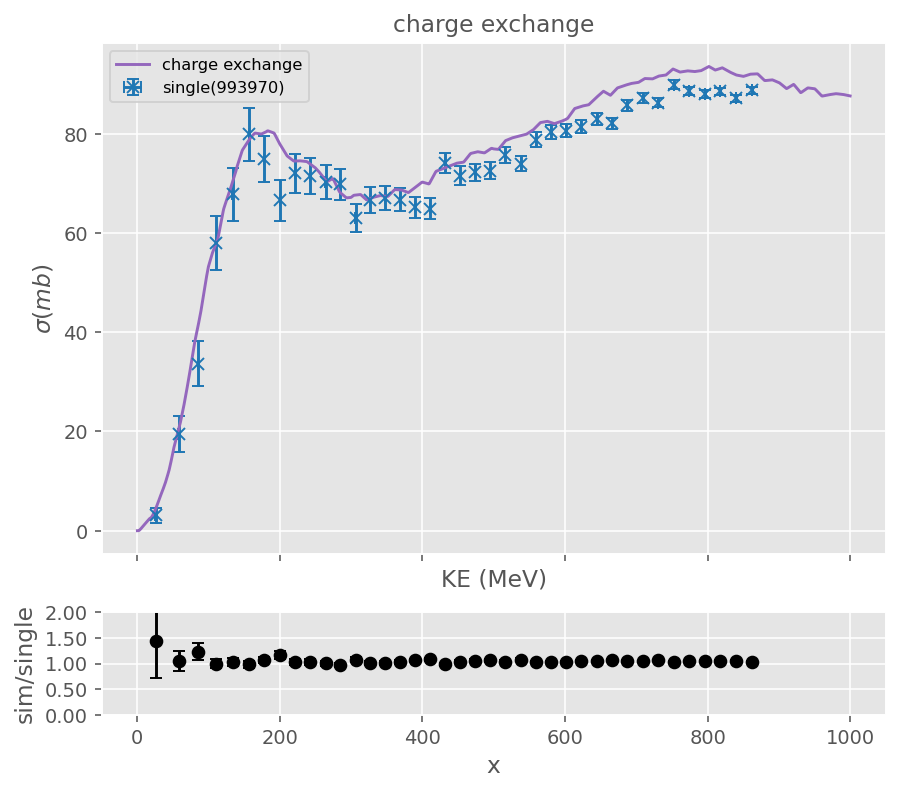

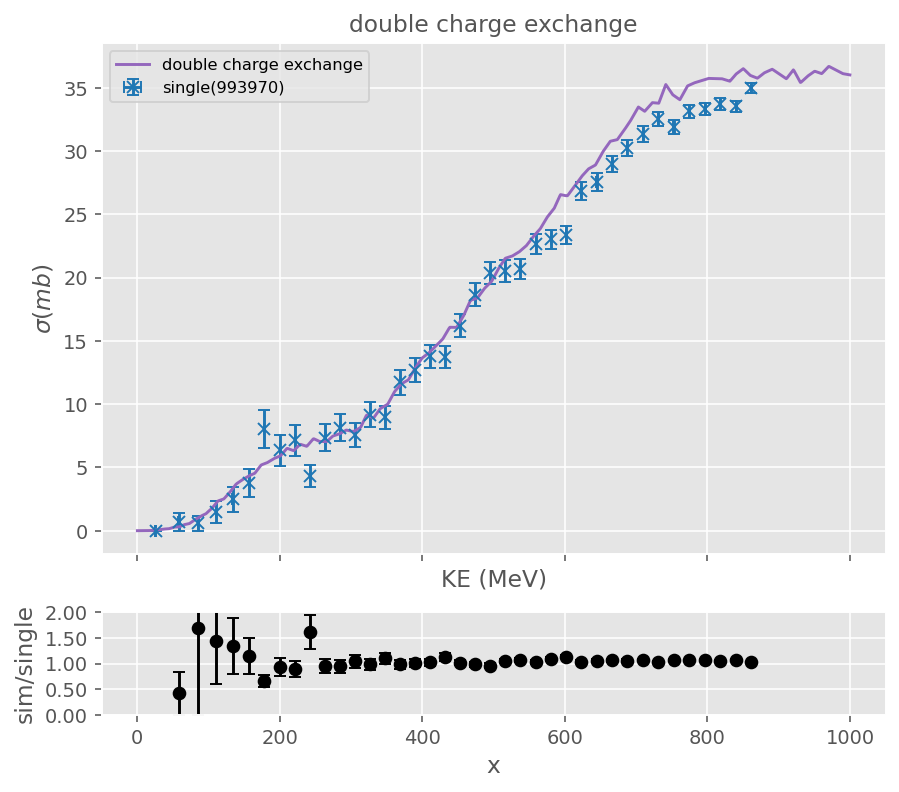

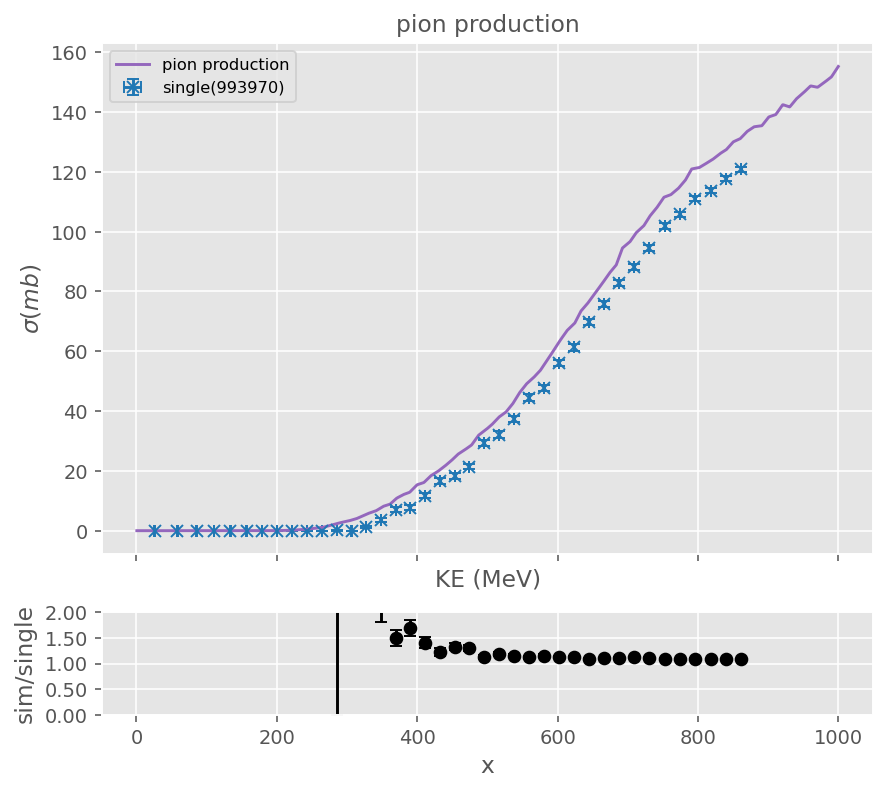

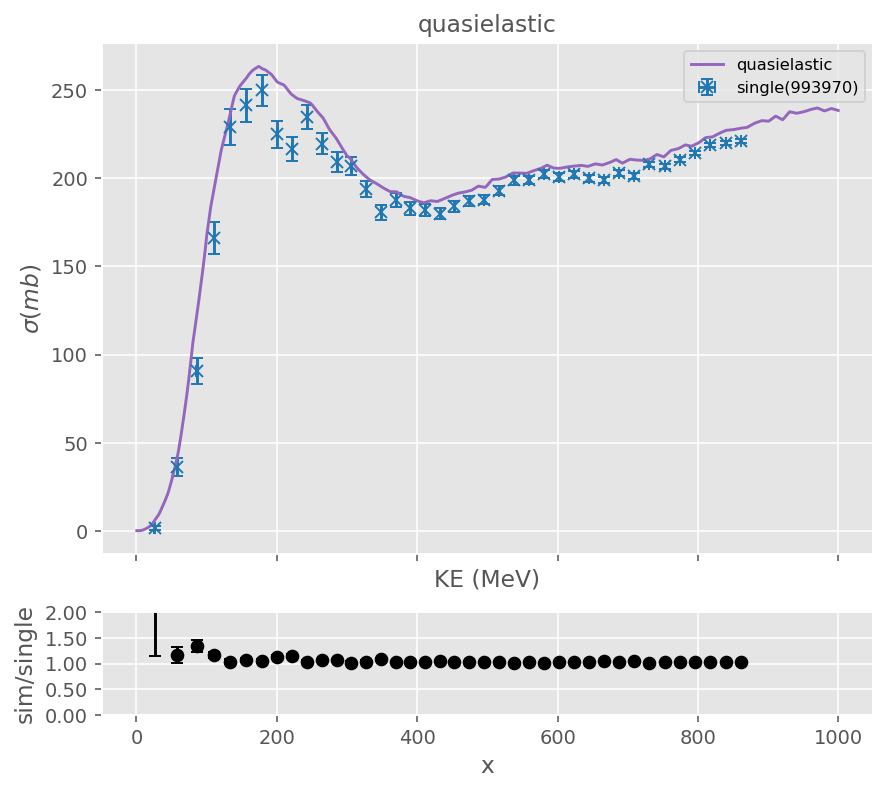

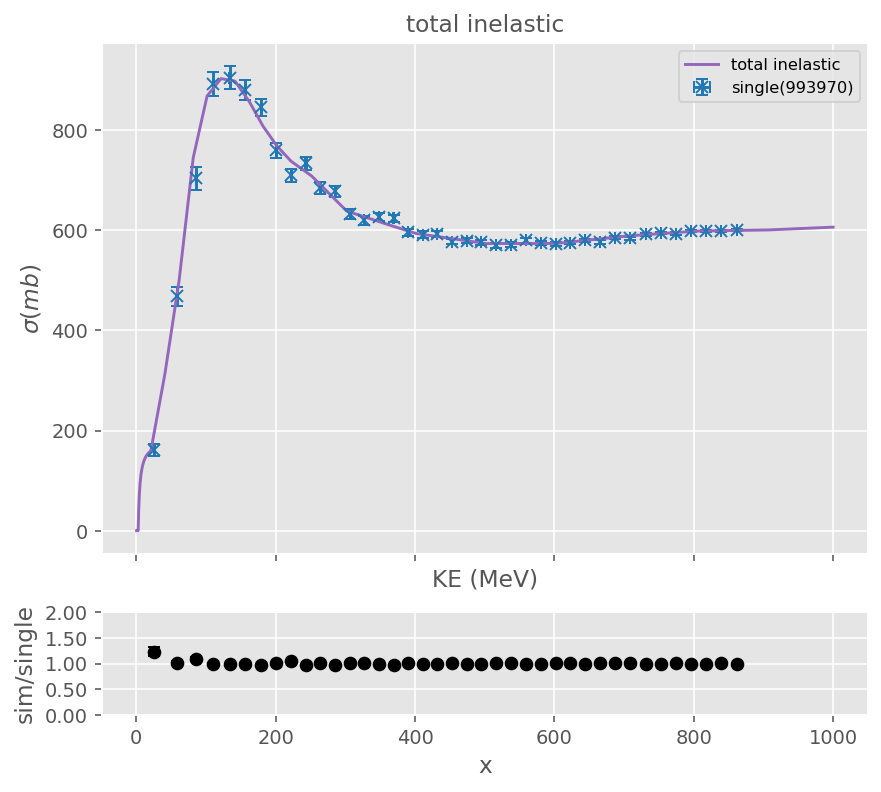

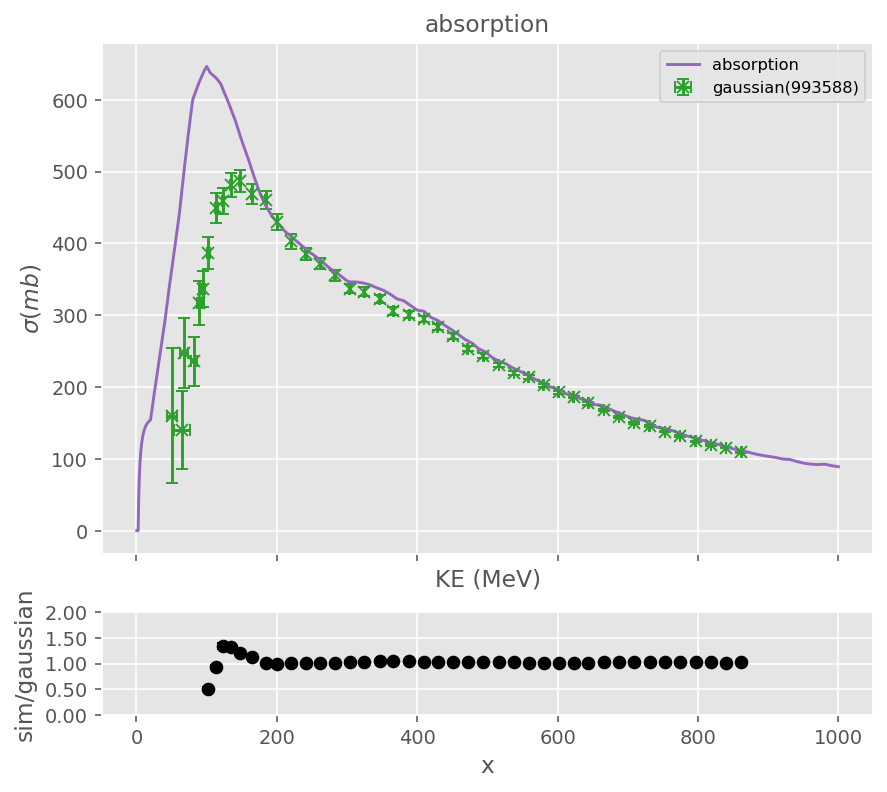

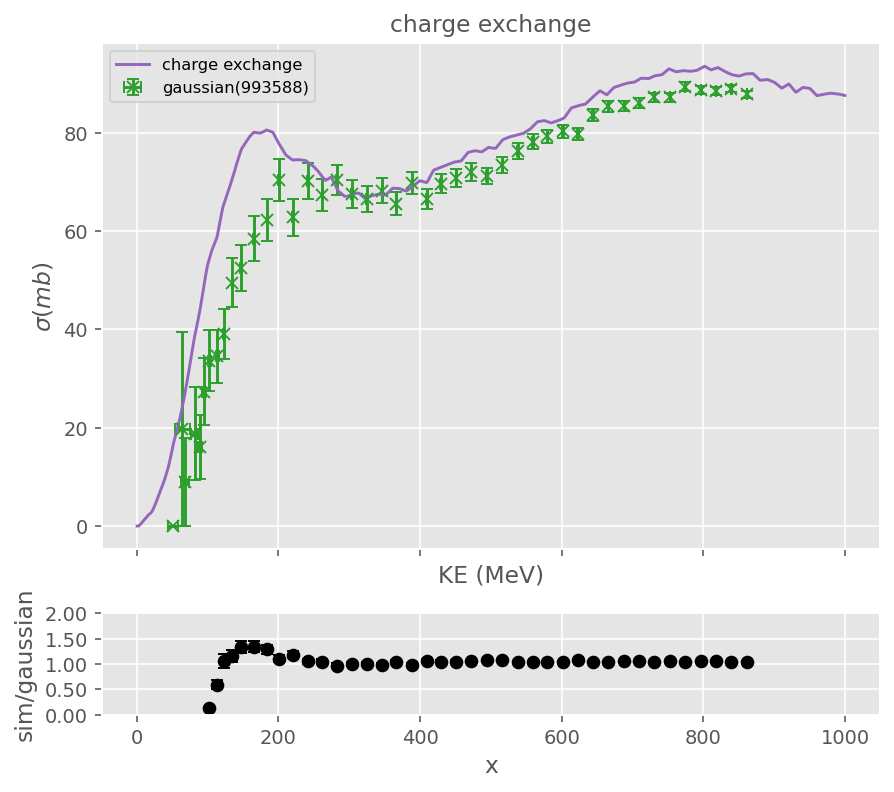

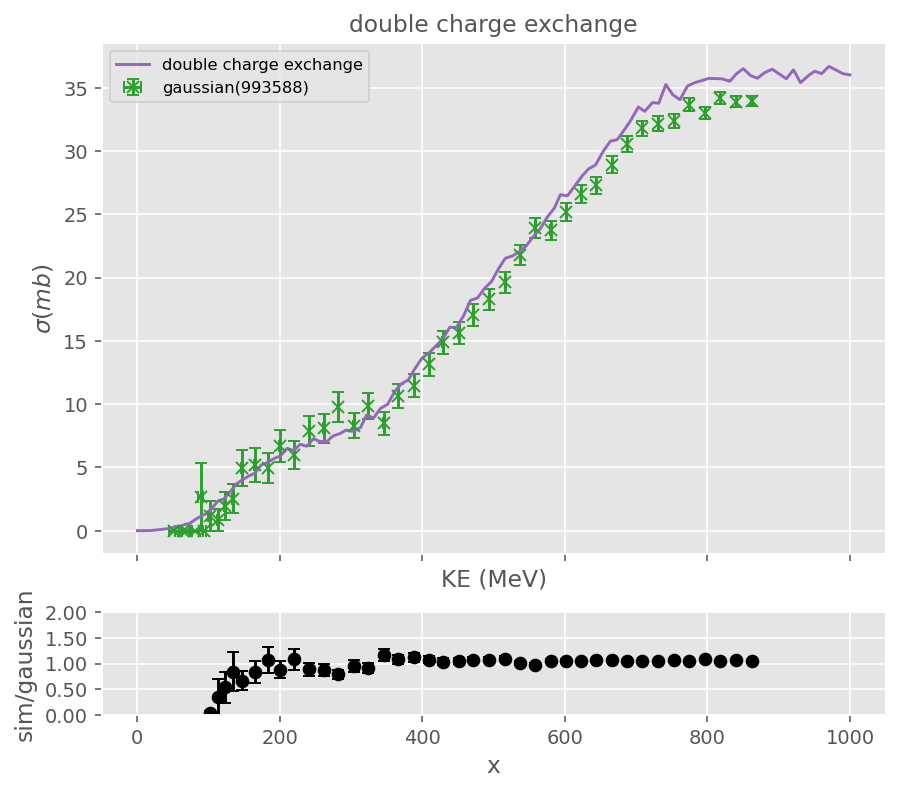

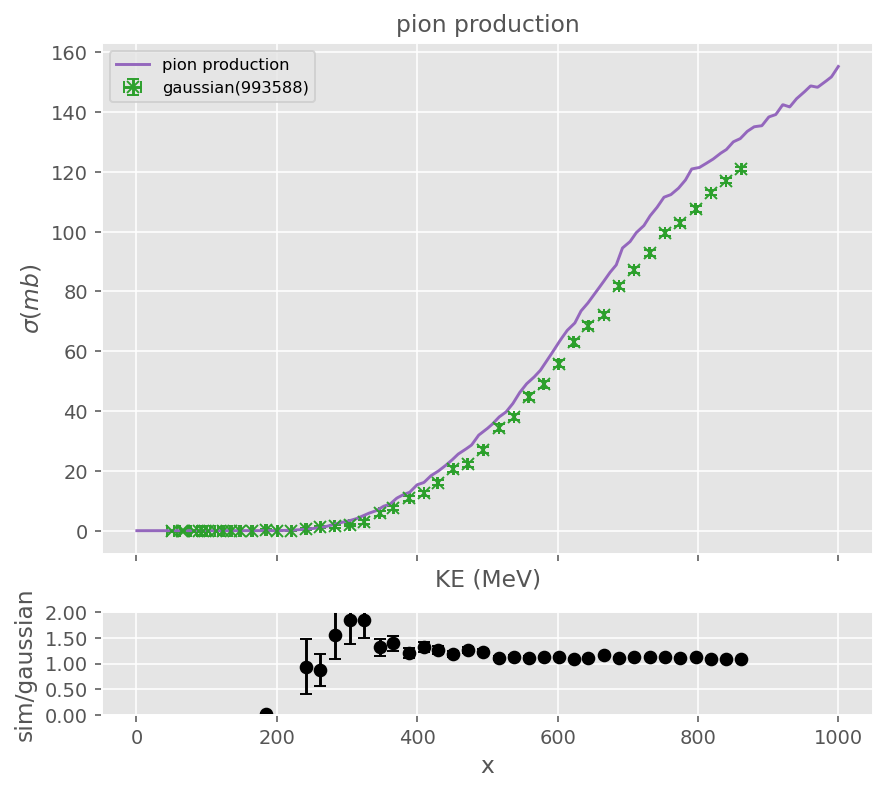

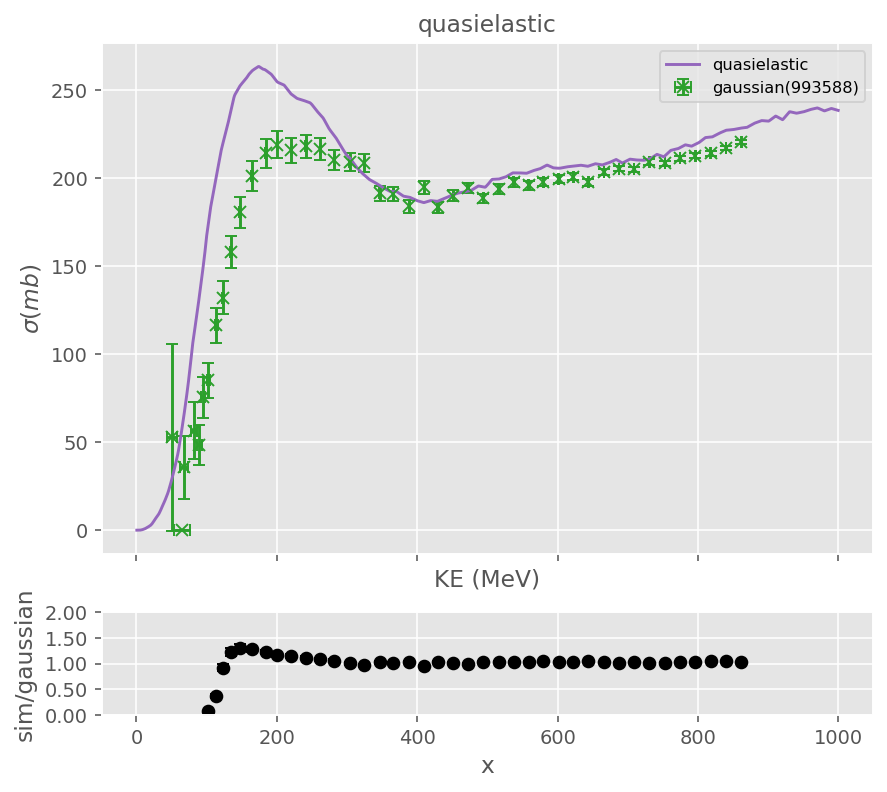

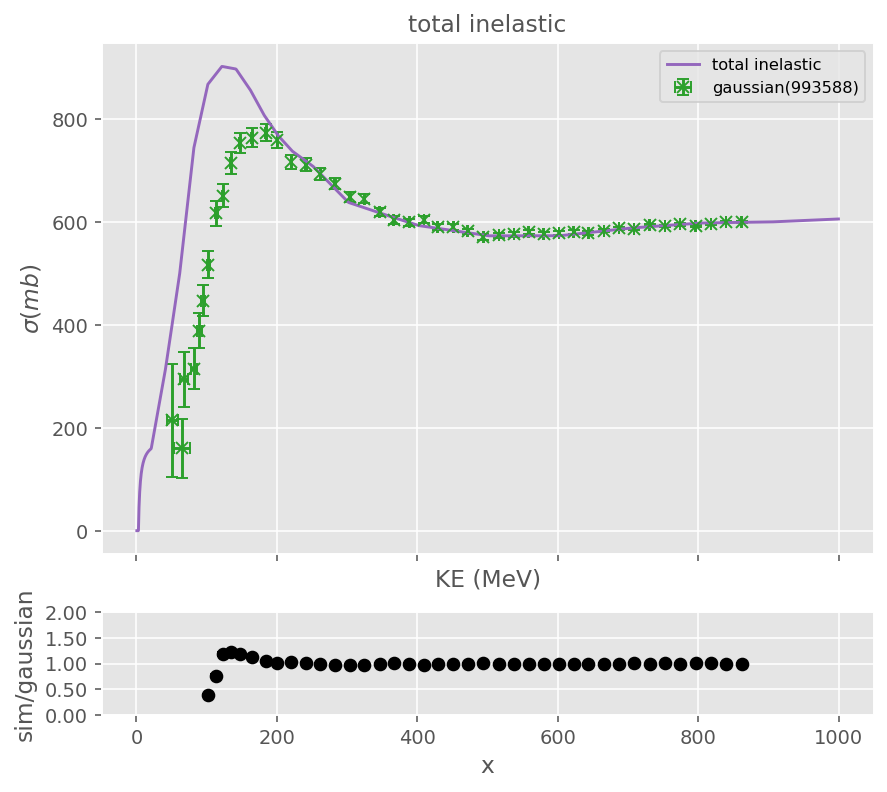

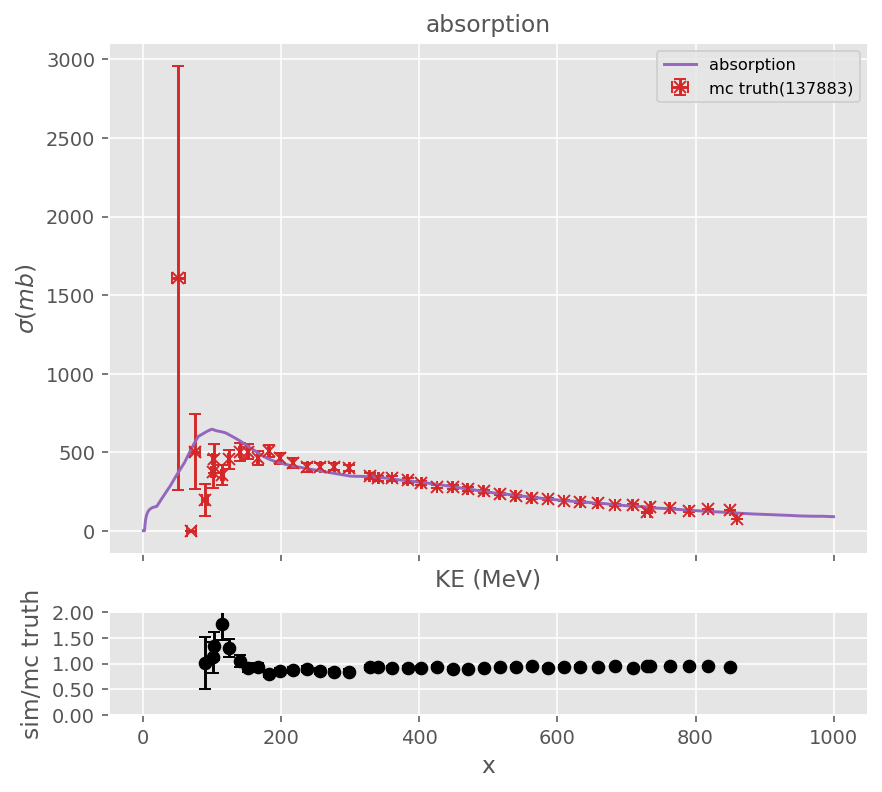

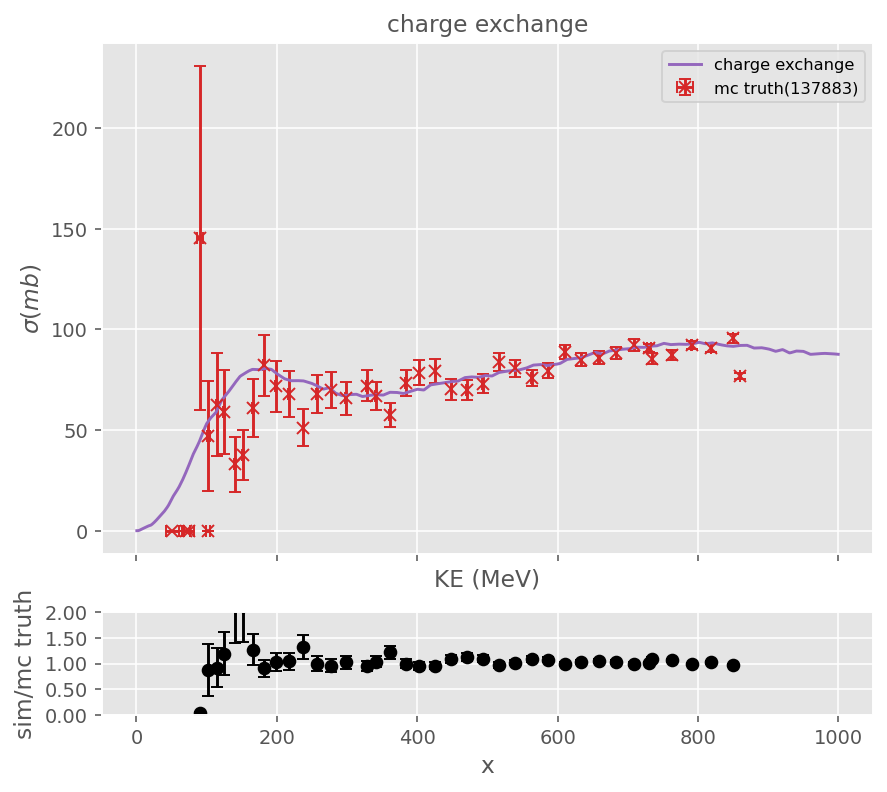

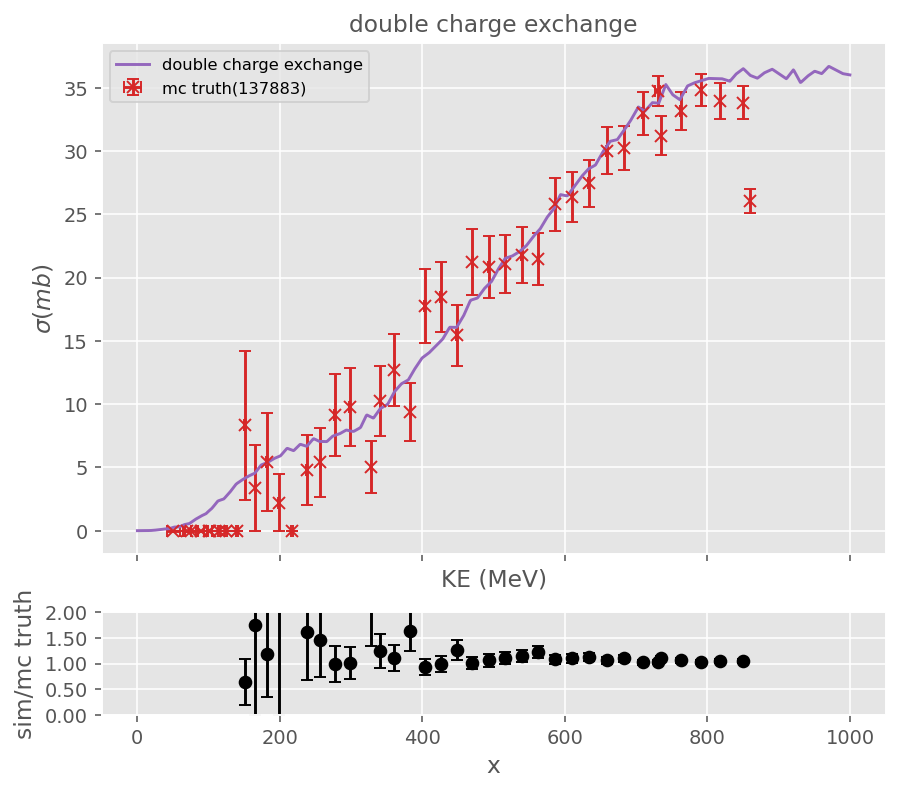

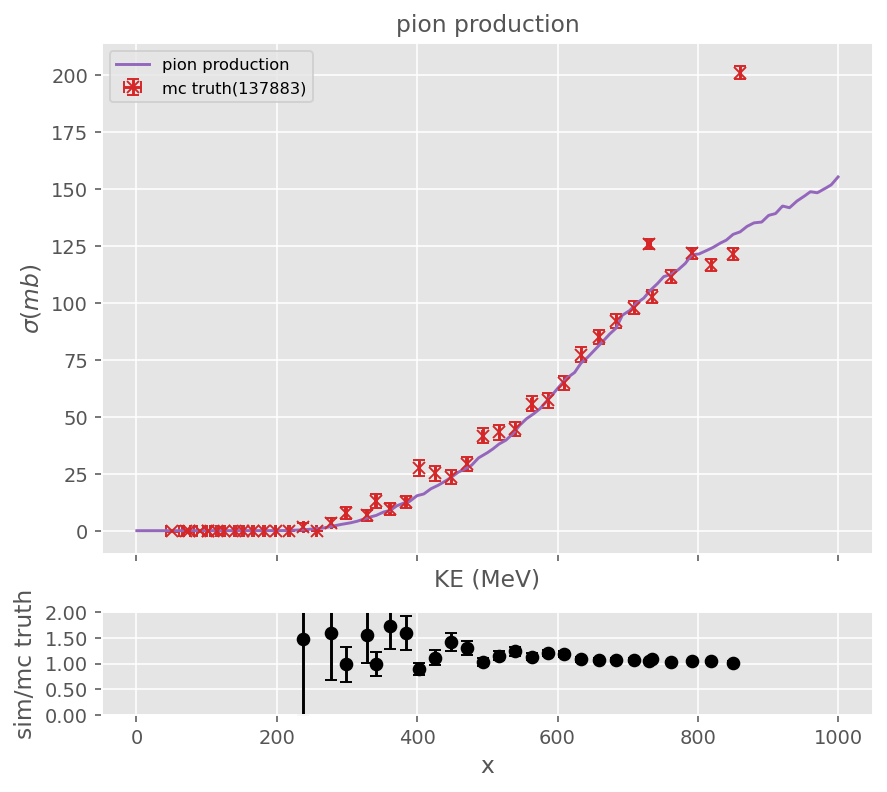

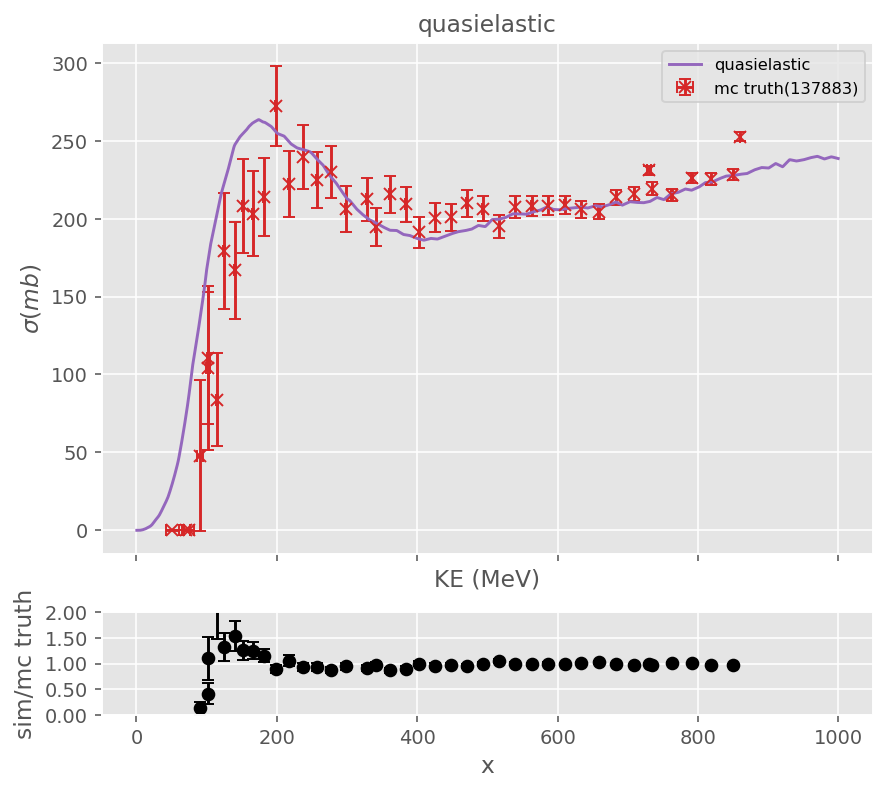

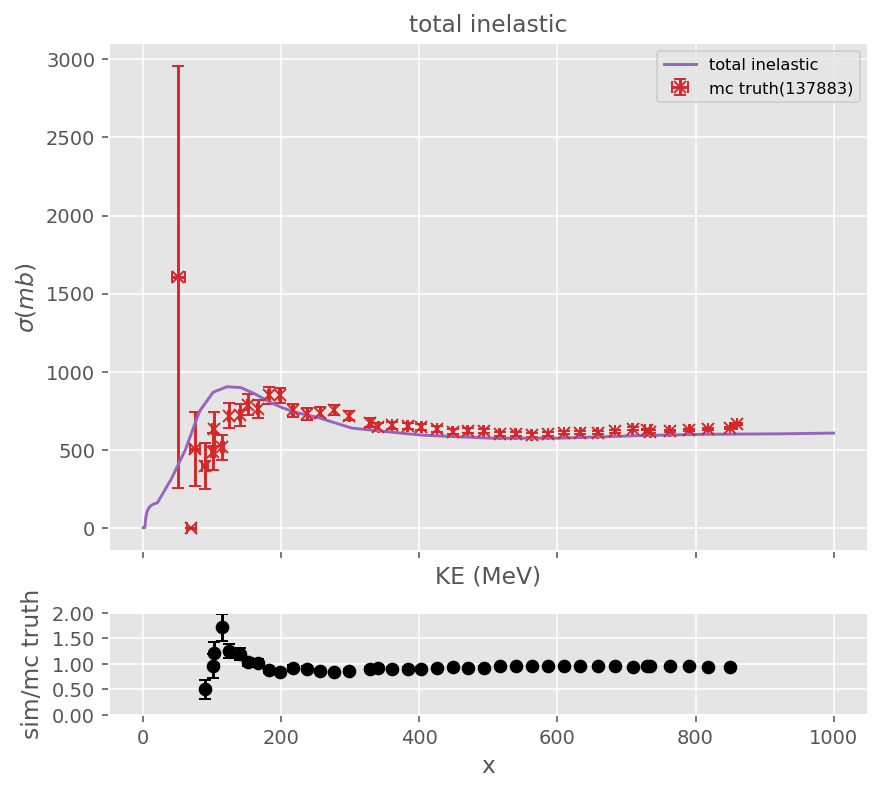

In [99]:
def ThinSliceComparison(config : str, slice_width : float, position_range : list):
    """ Compares thin slice method for the single profile toy, gaussian profile toy and mc truth.

    Args:
        slice_width (float): spatial slice width (cm)
        position_range (list): min, max position for slices (cm)
    """
    slices = cross_section.Slices(slice_width, min(position_range), max(position_range))

    args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration(config))
    mc = Master.Data(args.mc_file, -1, nTuple_type = args.ntuple_type)
    true_pion_mask = mc.trueParticles.pdg[:, 0] == 211
    mc.Filter([true_pion_mask], [true_pion_mask])

    interact_position = mc.trueParticles.endPos.z[:, 0] # get interaction vertex z position

    traj_KE = mc.trueParticles.beam_traj_KE # get beam particle kinetic energy at each trajectory point from simulation
    traj_pos = mc.trueParticles.beam_traj_pos.z # get beam particle z at each trajectory point from simulation 

    colours = {
        "single"   : "C0",
        "gaussian" : "C4",
        "mc truth" : "C6"
    }

    mean_energies = {}
    mean_energies["single"] = cross_section.ThinSlice.MeanSliceEnergy(toy_single.KE_int[toy_single.total_inelastic], toy_single.z_int[toy_single.total_inelastic], slices)
    mean_energies["gaussian"] = cross_section.ThinSlice.MeanSliceEnergy(toy_gaussian.df.KE_int[toy_gaussian.df.total_inelastic], toy_gaussian.df.z_int[toy_gaussian.df.total_inelastic], slices)
    mean_energies["mc truth"] = cross_section.ThinSlice.MeanSliceEnergy(traj_KE[mc_regions["total_inelastic"]], traj_pos[mc_regions["total_inelastic"]], slices)

    for l, v in mean_energies.items():
        Plots.Plot(slices.num[:-2], v[0][:-1], marker = "x", yerr = v[1][:-1], label = l, xlabel = "slice number", ylabel = "$\left< E \\right>$ (MeV)", newFigure = False, color = colours[l])
    pdf.Save()

    z_int = {
        "single"   : toy_single.z_int[toy_single.total_inelastic],
        "gaussian" : toy_gaussian.df.z_int[toy_single.total_inelastic],
        "mc truth" : interact_position[mc_regions["total_inelastic"]]
    }
    KE_int = {
        "single"   : toy_single.KE_int[toy_single.total_inelastic],
        "gaussian" : toy_gaussian.df.KE_int[toy_single.total_inelastic],
        "mc truth" : traj_KE[:, -2][mc_regions["total_inelastic"]]
    }

    for _, d in Plots.IterMultiPlot(list(z_int.keys()), sharex = True, sharey = True):
        Plots.PlotHist2D(z_int[d], KE_int[d], xlabel = "$z_{int}$ (cm)", ylabel = "$KE_{int}$ (MeV)", title = d, newFigure = False, x_range = [0, 400], y_range = [0, 1000])
    pdf.Save()

    Plots.PlotHistComparison([toy_single.KE_int[toy_single.total_inelastic], toy_gaussian.KE_int[toy_gaussian.total_inelastic], traj_KE[:, -2][mc_regions["total_inelastic"]]], labels = list(mean_energies.keys()), bins = 50, colours = list(colours.values()), xlabel = "$KE_{int}$")
    pdf.Save()
    Plots.PlotHistComparison([toy_gaussian.df.KE_init[toy_gaussian.df.total_inelastic], mc.trueParticles.KE_front_face[mc_regions["total_inelastic"]]], labels = ["gaussian", "mc truth"], bins = 50, colours = [colours["gaussian"], colours["mc truth"]], xlabel = "$KE_{init}$")
    pdf.Save()
    
    for _, d in Plots.IterMultiPlot([toy_single.df.KE_init[toy_single.df.total_inelastic], toy_gaussian.df.KE_init[toy_gaussian.df.total_inelastic], mc.trueParticles.KE_front_face[mc_regions["total_inelastic"]]]):
        Plots.PlotHist(d, xlabel = "$KE_{int}$(MeV)", newFigure = False)
    pdf.Save()
    for d in [toy_single.KE_init[toy_single.total_inelastic], toy_gaussian.df.KE_init[toy_gaussian.df.total_inelastic], mc.trueParticles.KE_front_face[mc_regions["total_inelastic"]]]:
        Plots.PlotHist(d, xlabel = "$KE_{int}$(MeV)")
        pdf.Save()

    hists = {}
    for c in toy_gaussian.exclusive_processes:
        hists[c] = {
            "single"   : cross_section.ThinSlice.CountingExperiment(toy_single.z_int, c, slices),
            "gaussian" : cross_section.ThinSlice.CountingExperiment(toy_gaussian.df.z_int, c, slices),
            "mc truth" : cross_section.ThinSlice.CountingExperiment(interact_position, c, slices)
        }

    xs = {}
    for c in toy_gaussian.exclusive_processes:
        if c == "mc truth": # needed because beam particle travel through the TPC in an angle
            attenuation = 0.95
        else:
            attenuation = 1
        xs[c] = {h : cross_section.ThinSlice.CrossSection(hists[c][h][1], hists[c][h][0], slices.width / attenuation)  for h in hists[c]}


    for _, c in Plots.IterMultiPlot(toy_gaussian.exclusive_processes, sharex = True):
        counts = {
            "single" : sum(c),
            "gaussian" : sum(c),
            "mc truth" : sum(c)
        }

        geant_xs.Plot(c, color = "C8")
        for h in xs[c]:
            Plots.Plot(mean_energies[h][0], xs[c][h][0], xerr = mean_energies[h][1], yerr = xs[c][h][1], marker = "x", linestyle = "", newFigure = False, label = f"{h}({counts[h]})", title = c.replace("_", " "), color = colours[h])
        plt.ylim(0, 1.2 * max(getattr(geant_xs, c)))
    pdf.Save()
    return

ThinSliceComparison("work/2023/cex_analysis_1GeV_config.json", 10, [-10, 720])

/tmp/ipykernel_41775/249587869.py:102: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((self.y1_err/self.y1)**2 + (self.y2_err/self.y2)**2)
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


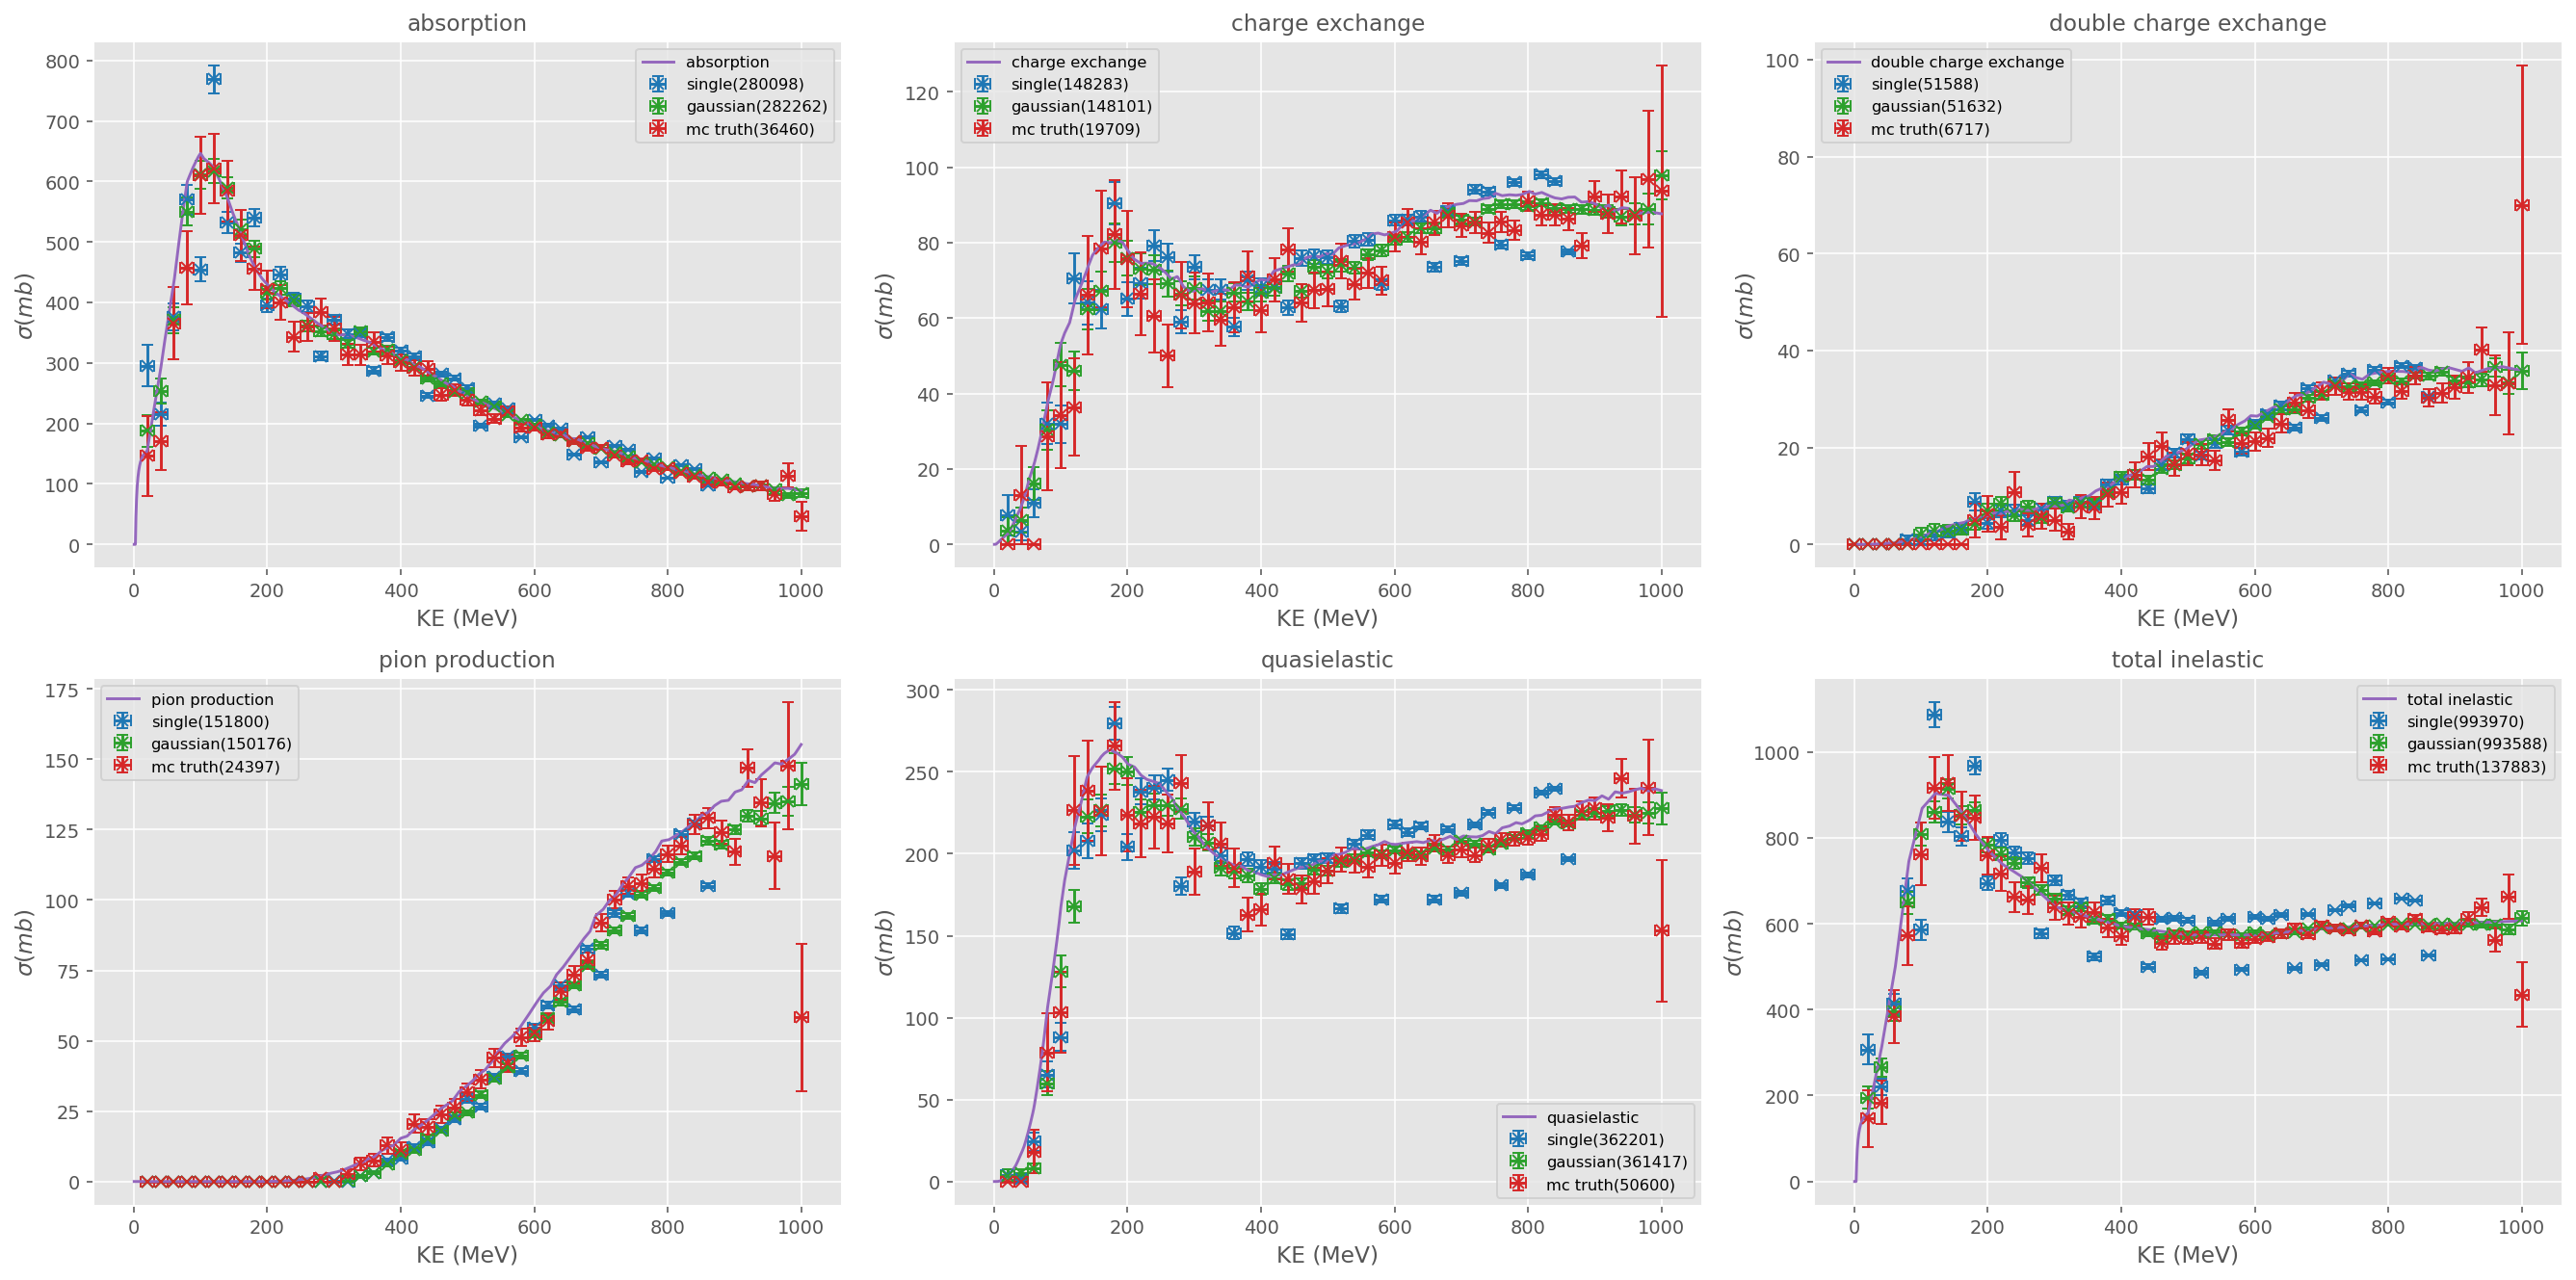

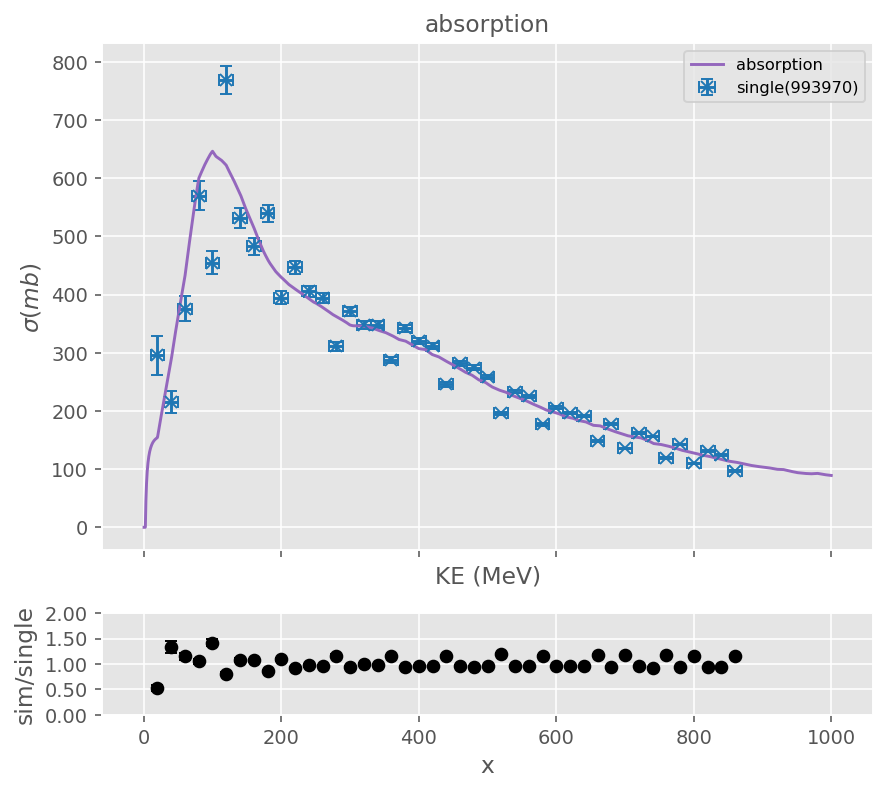

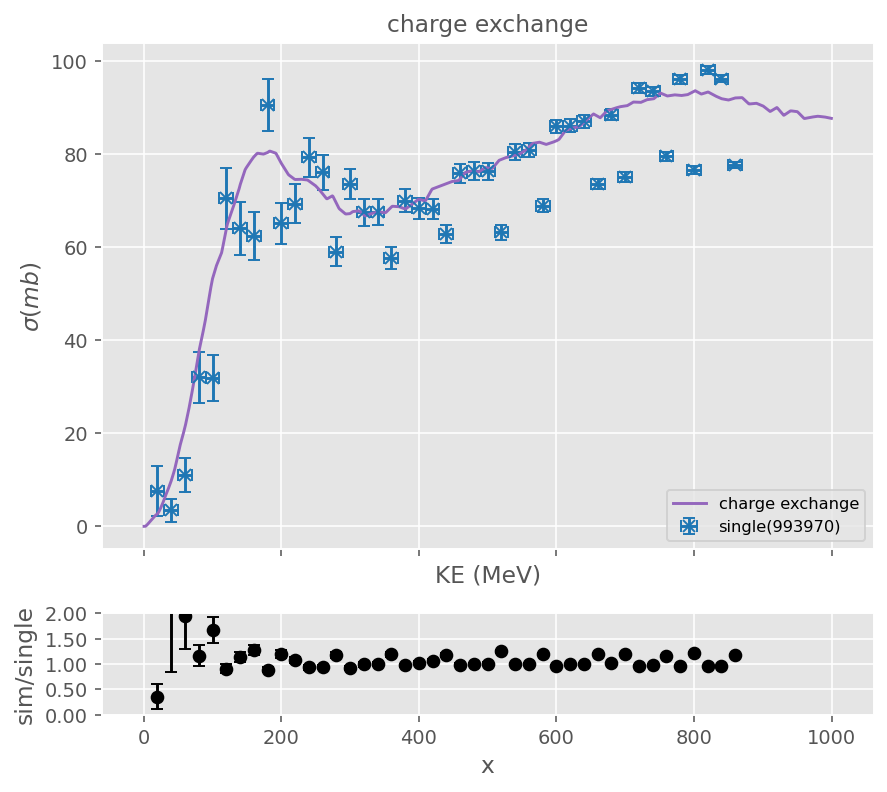

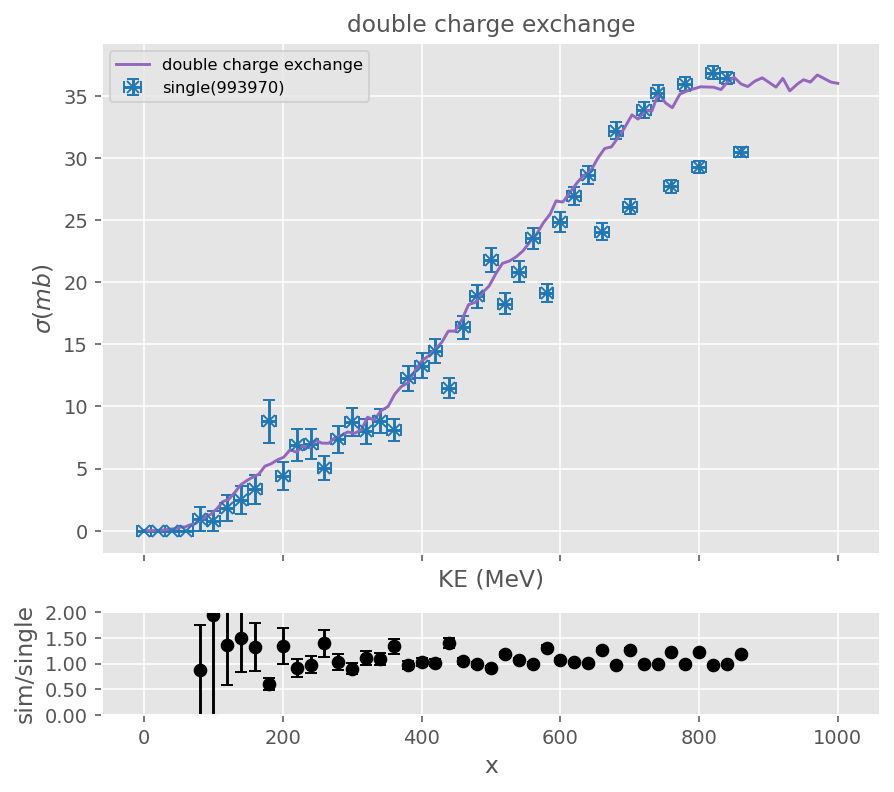

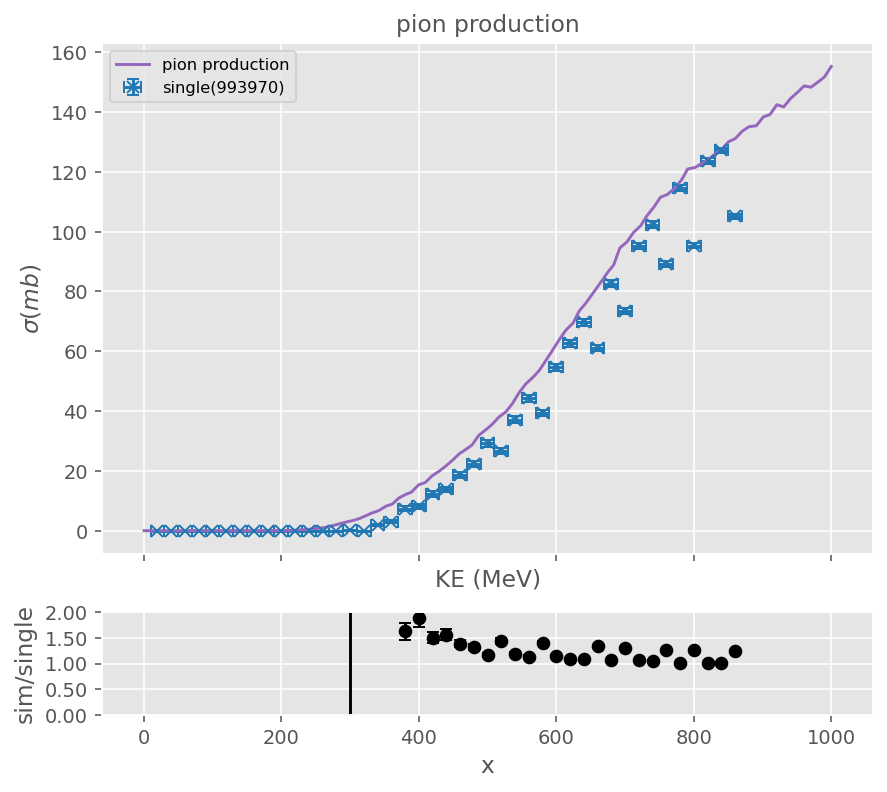

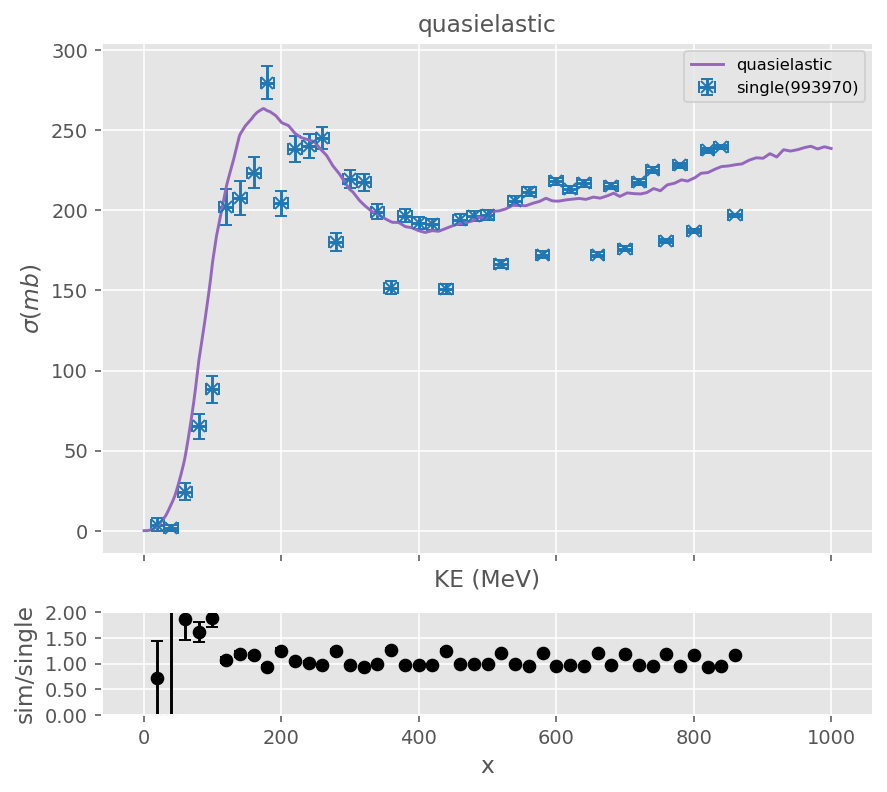

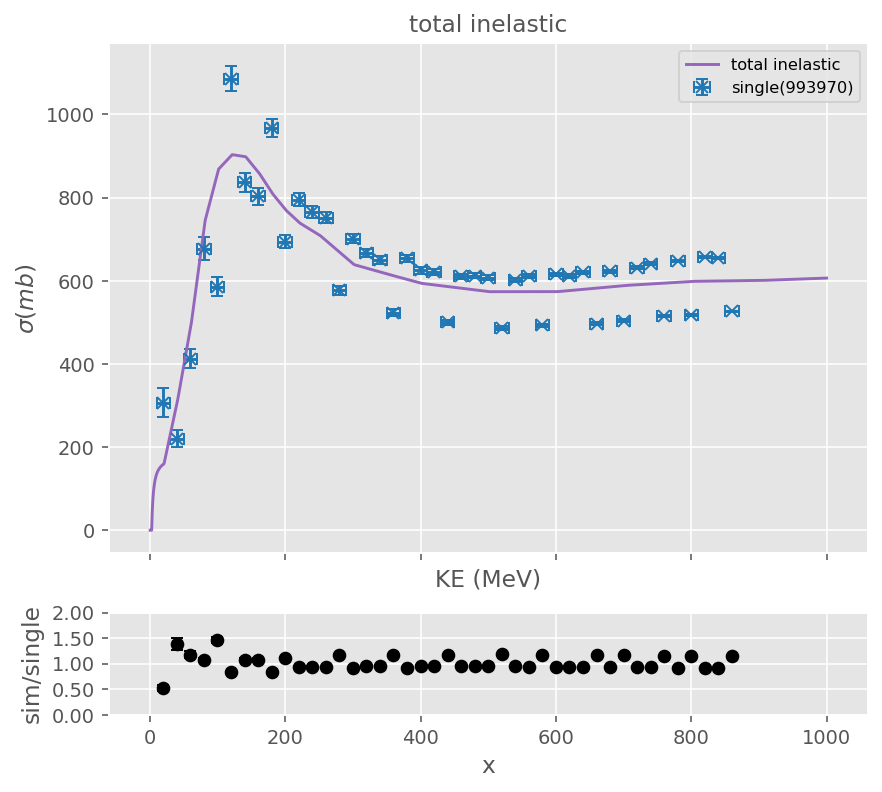

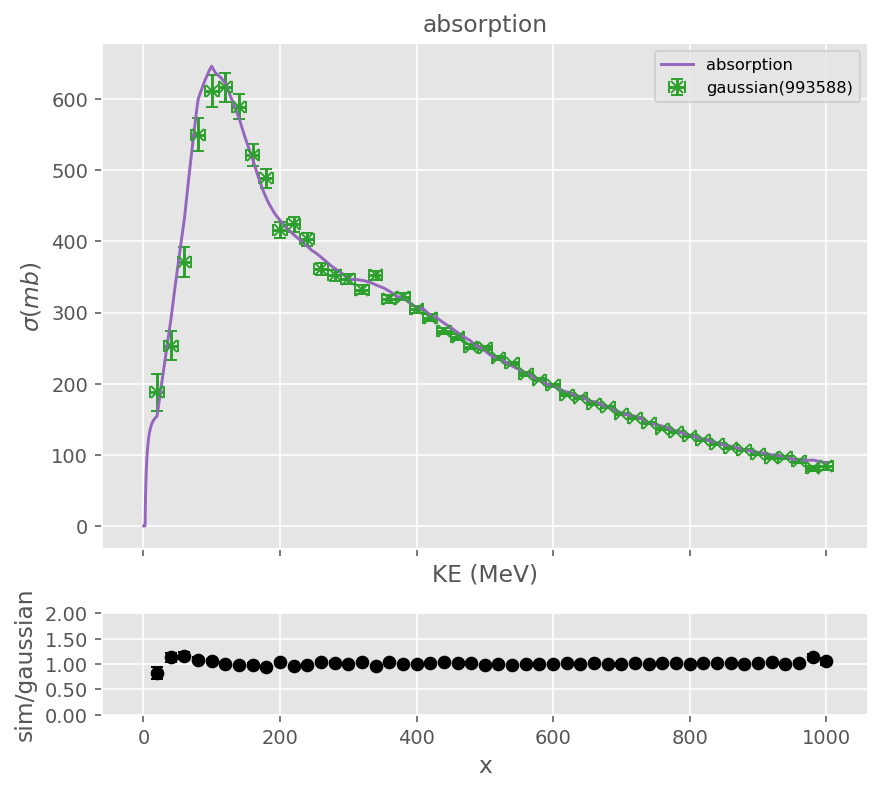

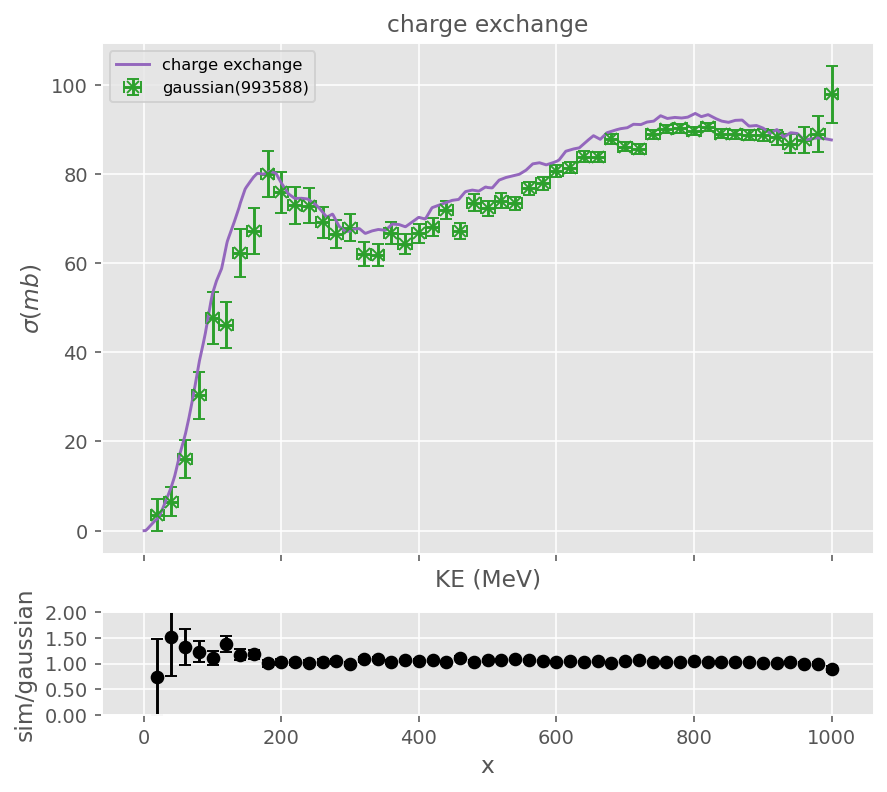

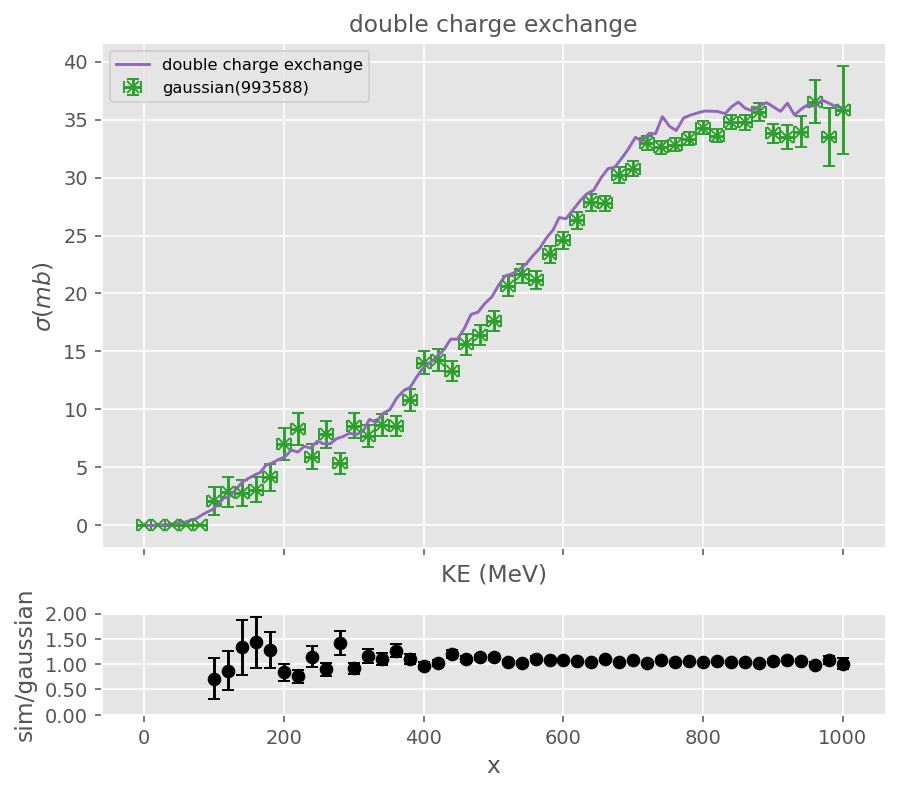

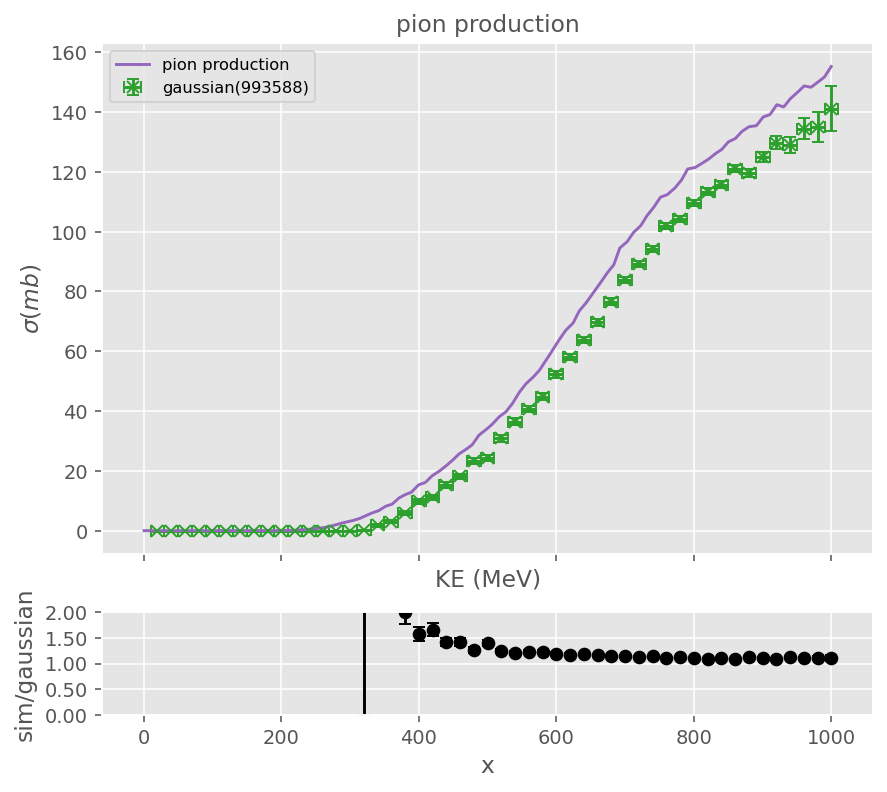

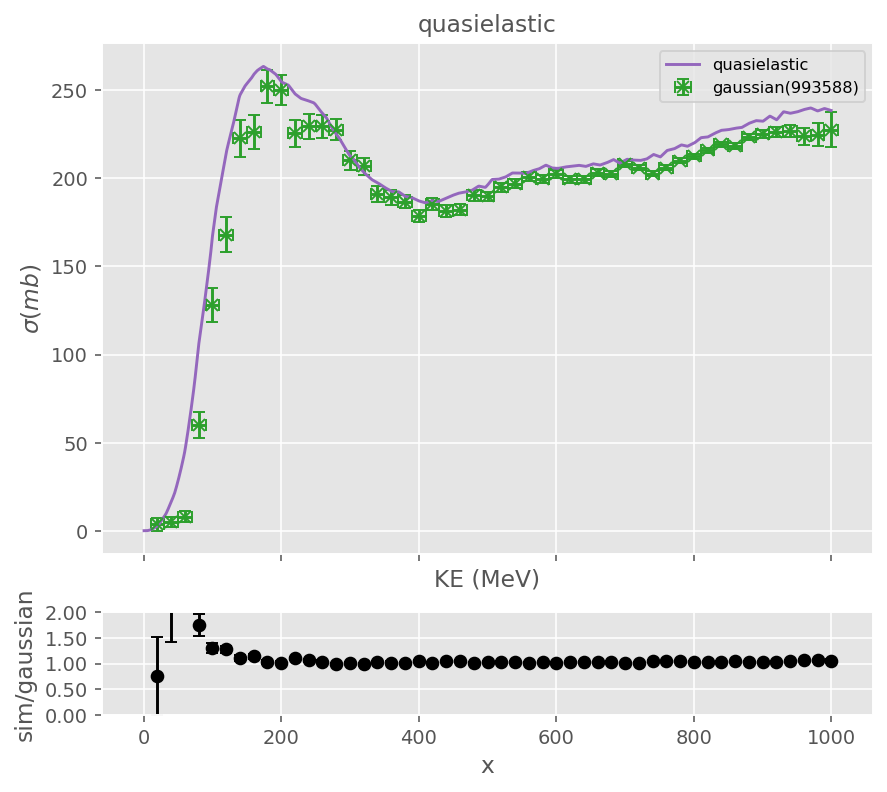

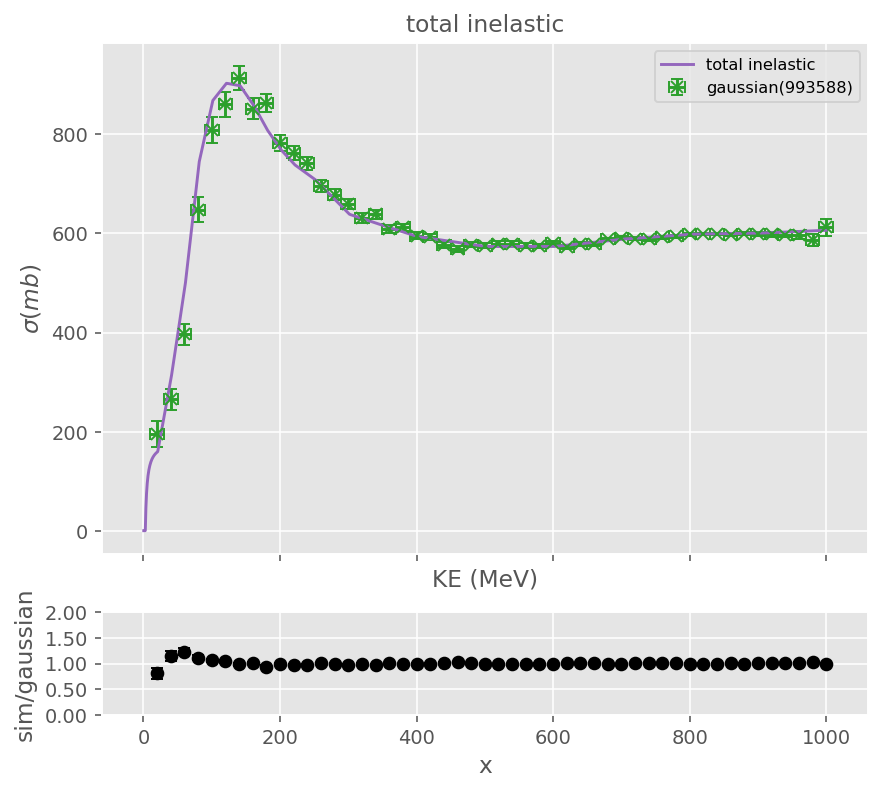

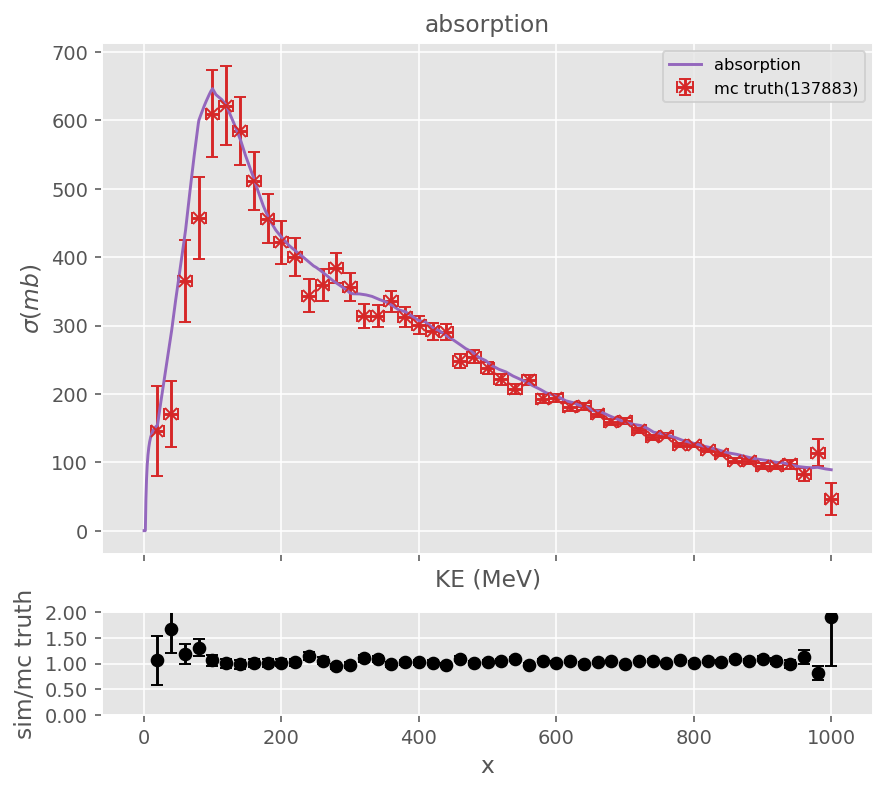

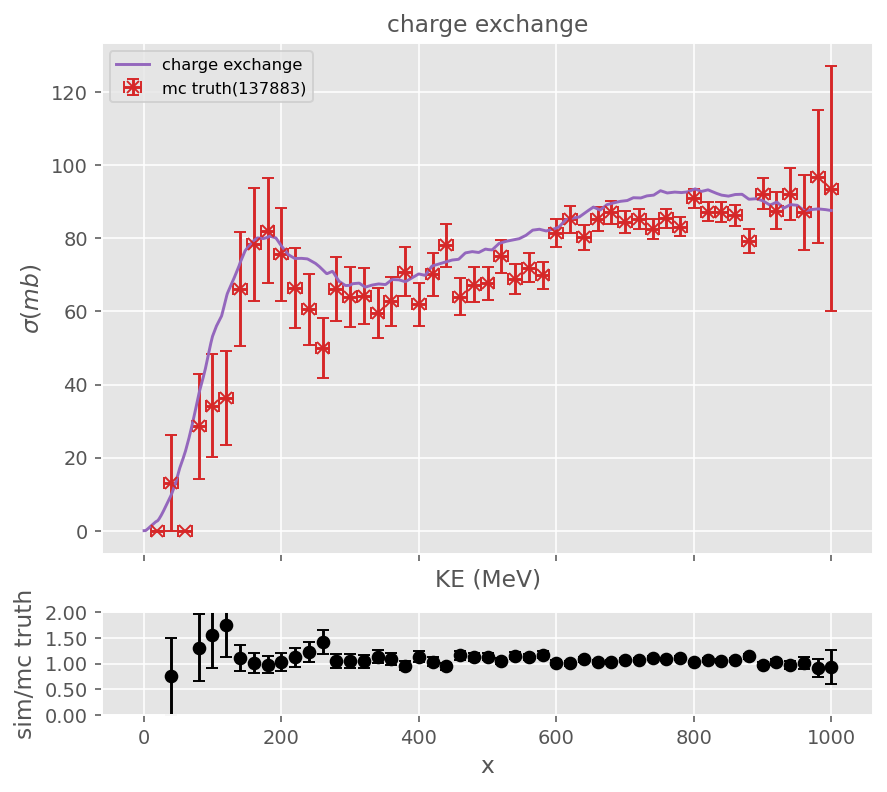

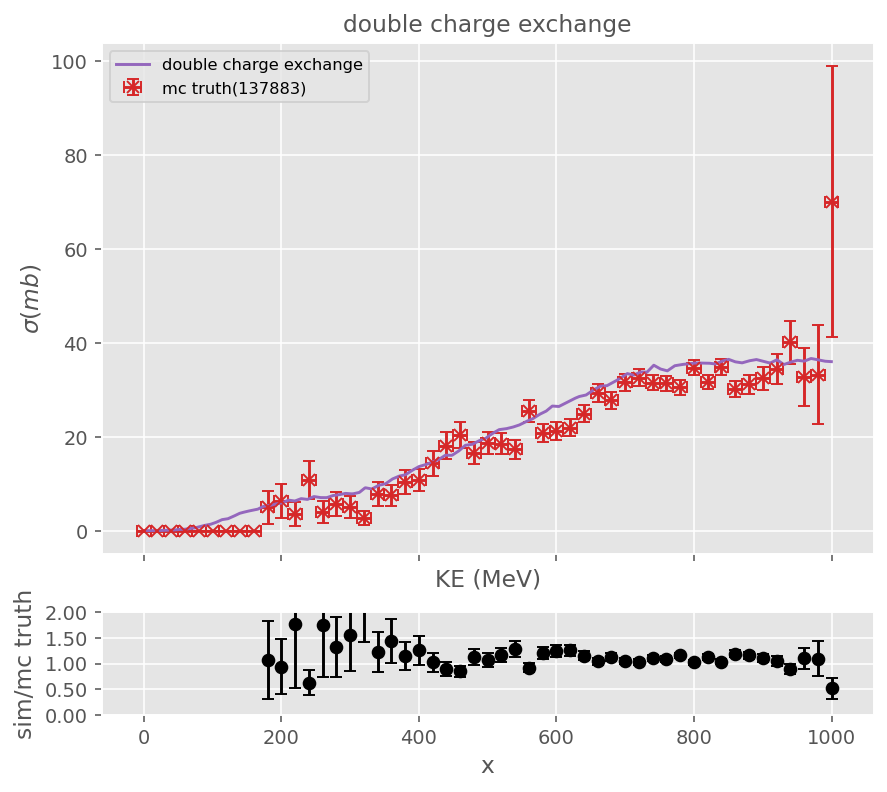

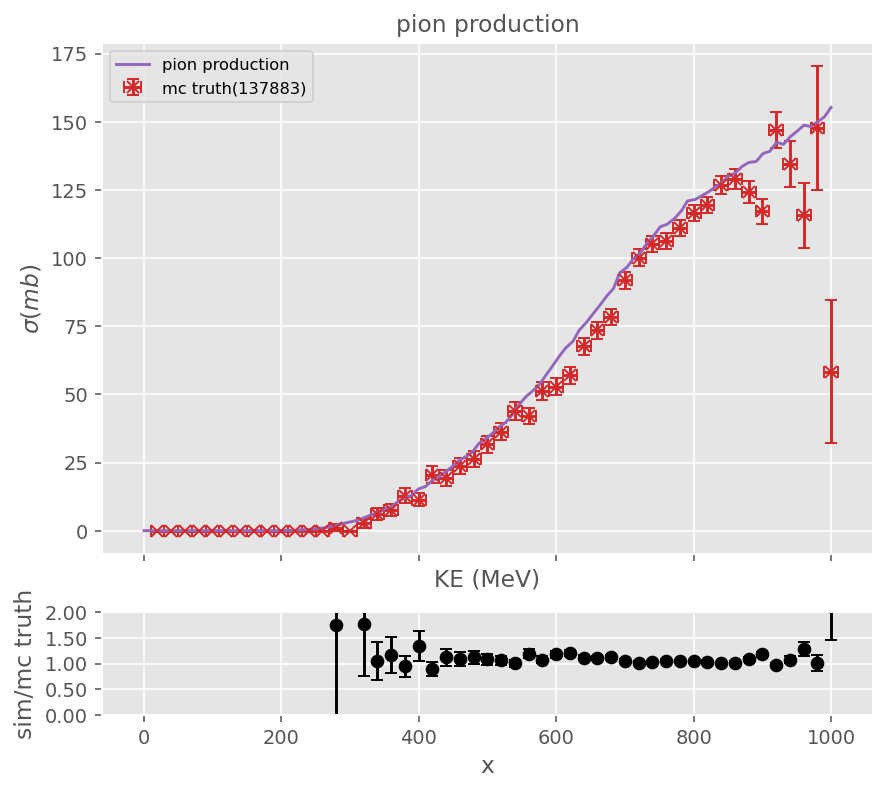

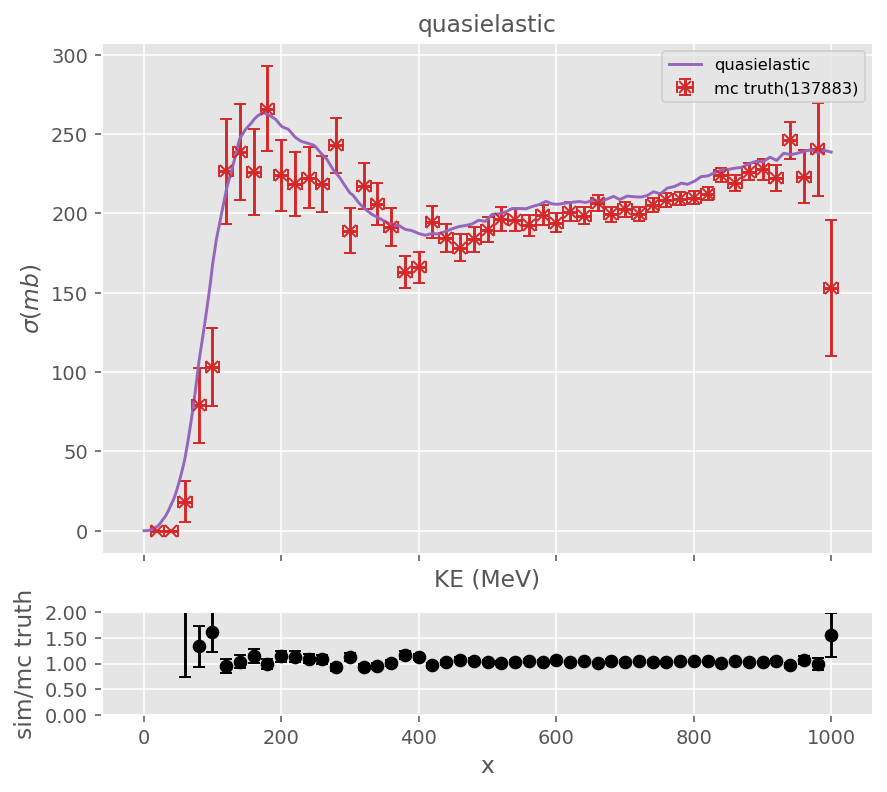

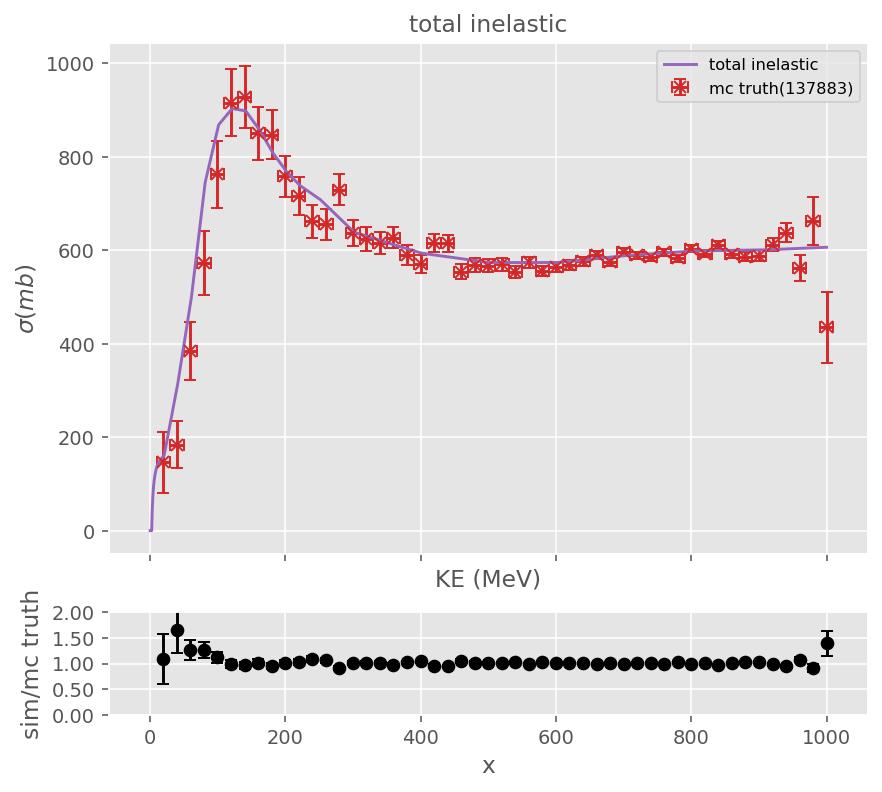

In [100]:
def ESliceComparison(config : str, slice_width : float, energy_range : list):
    """ Compares energy slice method for the single profile toy, gaussian profile toy and mc truth.

    Args:
        slice_width (float): energy slice width (MeV)
        energy_range (list): energy range of slices (MeV)
    """
    energy_slices = cross_section.Slices(slice_width, min(energy_range), max(energy_range), reversed = True)
    slice_dEdX = cross_section.EnergySlice.Slice_dEdX(energy_slices, cross_section.Particle.from_pdgid(211))

    args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration(config))
    mc = Master.Data(args.mc_file, -1, nTuple_type = args.ntuple_type)
    true_pion_mask = mc.trueParticles.pdg[:, 0] == 211
    mc.Filter([true_pion_mask], [true_pion_mask])

    ind = ak.argmax(mc.trueParticles.beam_traj_pos.z > 0, -1, keepdims = True)
    true_ffKE = ak.where(ak.flatten(mc.trueParticles.beam_traj_pos.z[ind]) < 0, 999999, mc.trueParticles.KE_front_face) # set KE to 999999 if the particle didn't reach the TPC.

    colours = {
        "single" : "C0",
        "gaussian" : "C4",
        "mc truth" : "C6"
    }

    KE_int = {
        "single" : toy_single.KE_int,
        "gaussian" : toy_gaussian.df.KE_int,
        "mc truth" : mc.trueParticles.beam_traj_KE[:, -2]
    }

    KE_init = {
        "single" : toy_single.KE_init,
        "gaussian" : toy_gaussian.df.KE_init,
        "mc truth" : true_ffKE
    }

    outside = {
        "single" : toy_single.z_int < 0,
        "gaussian" : toy_gaussian.df.z_int < 0,
        "mc truth" : true_ffKE >= 999999
    }

    sample_masks = {
        "single" : toy_single[toy_gaussian.exclusive_processes],
        "gaussian" : toy_gaussian.df[toy_gaussian.exclusive_processes],
        "mc truth" : mc_regions
    }

    hists = {}
    for c in toy_gaussian.exclusive_processes:
        hists[c] = {s : cross_section.EnergySlice.CountingExperiment(KE_int[s], KE_init[s], outside[s], sample_masks[s][c], energy_slices) for s in KE_int}

    xs = {}
    for c in toy_gaussian.exclusive_processes:
        xs[c] = {h : cross_section.EnergySlice.CrossSection(hists[c][h][0], hists[c][h][1], slice_dEdX, energy_slices.width) for h in hists[c]}

    for _, c in Plots.IterMultiPlot(toy_gaussian.exclusive_processes, sharex = True):
        counts = {i : sum(sample_masks[i][c]) for i in sample_masks}

        geant_xs.Plot(c, color = "C8")
        for h in hists[c]:
            Plots.Plot(energy_slices.pos[1:], xs[c][h][0][1:], xerr = energy_slices.width/2, yerr = xs[c][h][1][1:], marker = "x", linestyle = "", newFigure = False, label = f"{h}({counts[h]})", title = c.replace("_", " "), color = colours[h])
    pdf.Save()
    return

ESliceComparison(20, [0, 1020])

# Slice width study

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:159: RuntimeWarning: invalid value encountered in sqrt
  beta = (1 - (1/gamma)**2)**0.5
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:162: RuntimeWarning: divide by zero encountered in divide
  N = np.divide((BetheBloch.rho * BetheBloch.K * BetheBloch.Z * (particle.charge)**2), (BetheBloch.A * (beta**2)))
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:163: RuntimeWarning: divide by zero encountered in log
  A = 0.5 * np.log(2 * BetheBloch.me * (gamma**2) * (beta**2) * w_max / ((BetheBloch.I) **2))
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:138: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(beta * gamma)
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:141: RuntimeWarning: invalid value encountered in add
  delta_1 = delta_0 + BetheBloch.a * (BetheBloch.y1 - y

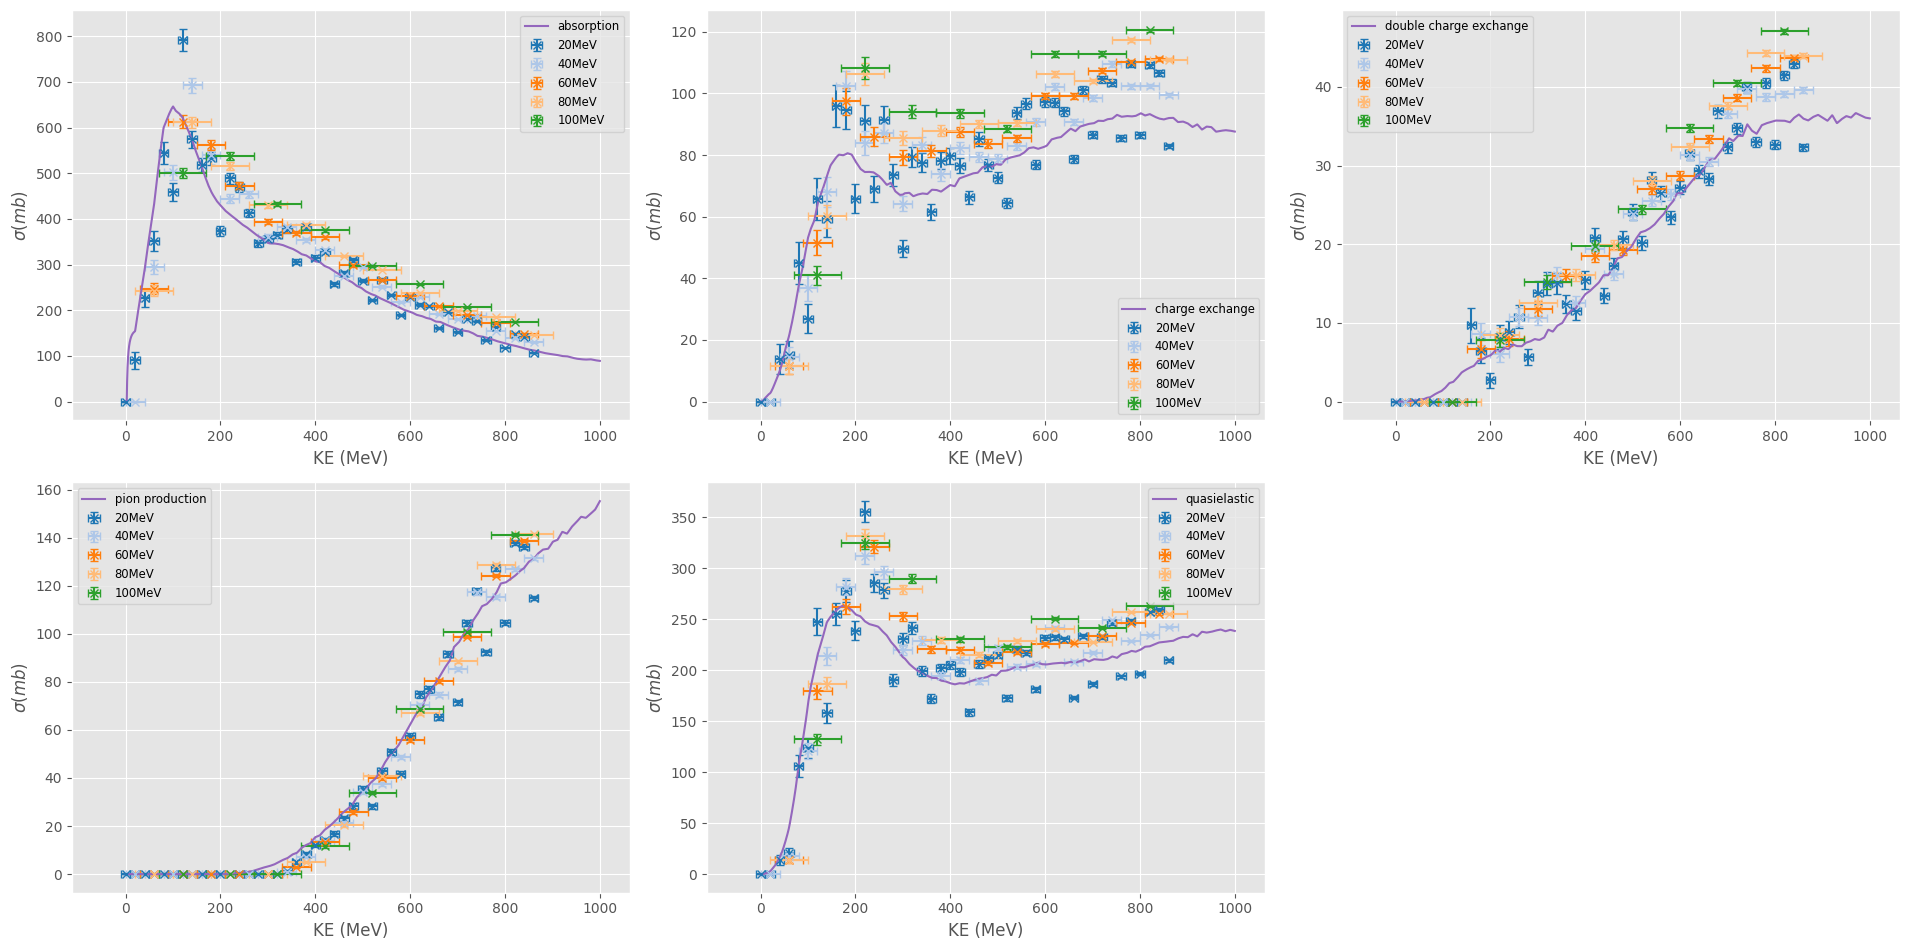

In [6]:
def ESliceWidth(slice_widths : float, energy_range : list):
    """ See how cross section varies as a function of slice thickness, using the single profile toy.

    Args:
        slice_width (float): energy slice width (MeV)
        energy_range (list): energy range of slices (MeV)
    """
    energy_slices = []
    slice_dEdX = []
    for s in slice_widths:
        energy_slices.append(cross_section.Slices(s, min(energy_range), max(energy_range), reversed = True))
        slice_dEdX.append(cross_section.EnergySlice.Slice_dEdX(energy_slices[-1], cross_section.Particle.from_pdgid(211)))

    for _, c in Plots.IterMultiPlot(toy_gaussian.exclusive_processes):
        hists = [cross_section.EnergySlice.CountingExperiment(toy_single.KE_int, toy_single.KE_init, toy_single.z_int < 0, toy_single[c], energy_slices[i]) for i in range(len(slice_widths))]
        xs = [cross_section.EnergySlice.CrossSection(*hists[i], slice_dEdX[i], energy_slices[i].width) for i in range(len(slice_widths))]

        geant_xs.Plot(c, color = "C8")
        for i in range(len(slice_widths)):
            Plots.Plot(energy_slices[i].pos[1:], xs[i][0][1:], xerr = energy_slices[i].width/2, yerr = xs[i][1][1:], marker = "x", linestyle = "", newFigure = False, label = f"{slice_widths[i]}MeV")
    pdf.Save()
    return

ESliceWidth([20, 40, 60, 80, 100], [-20, 1020])

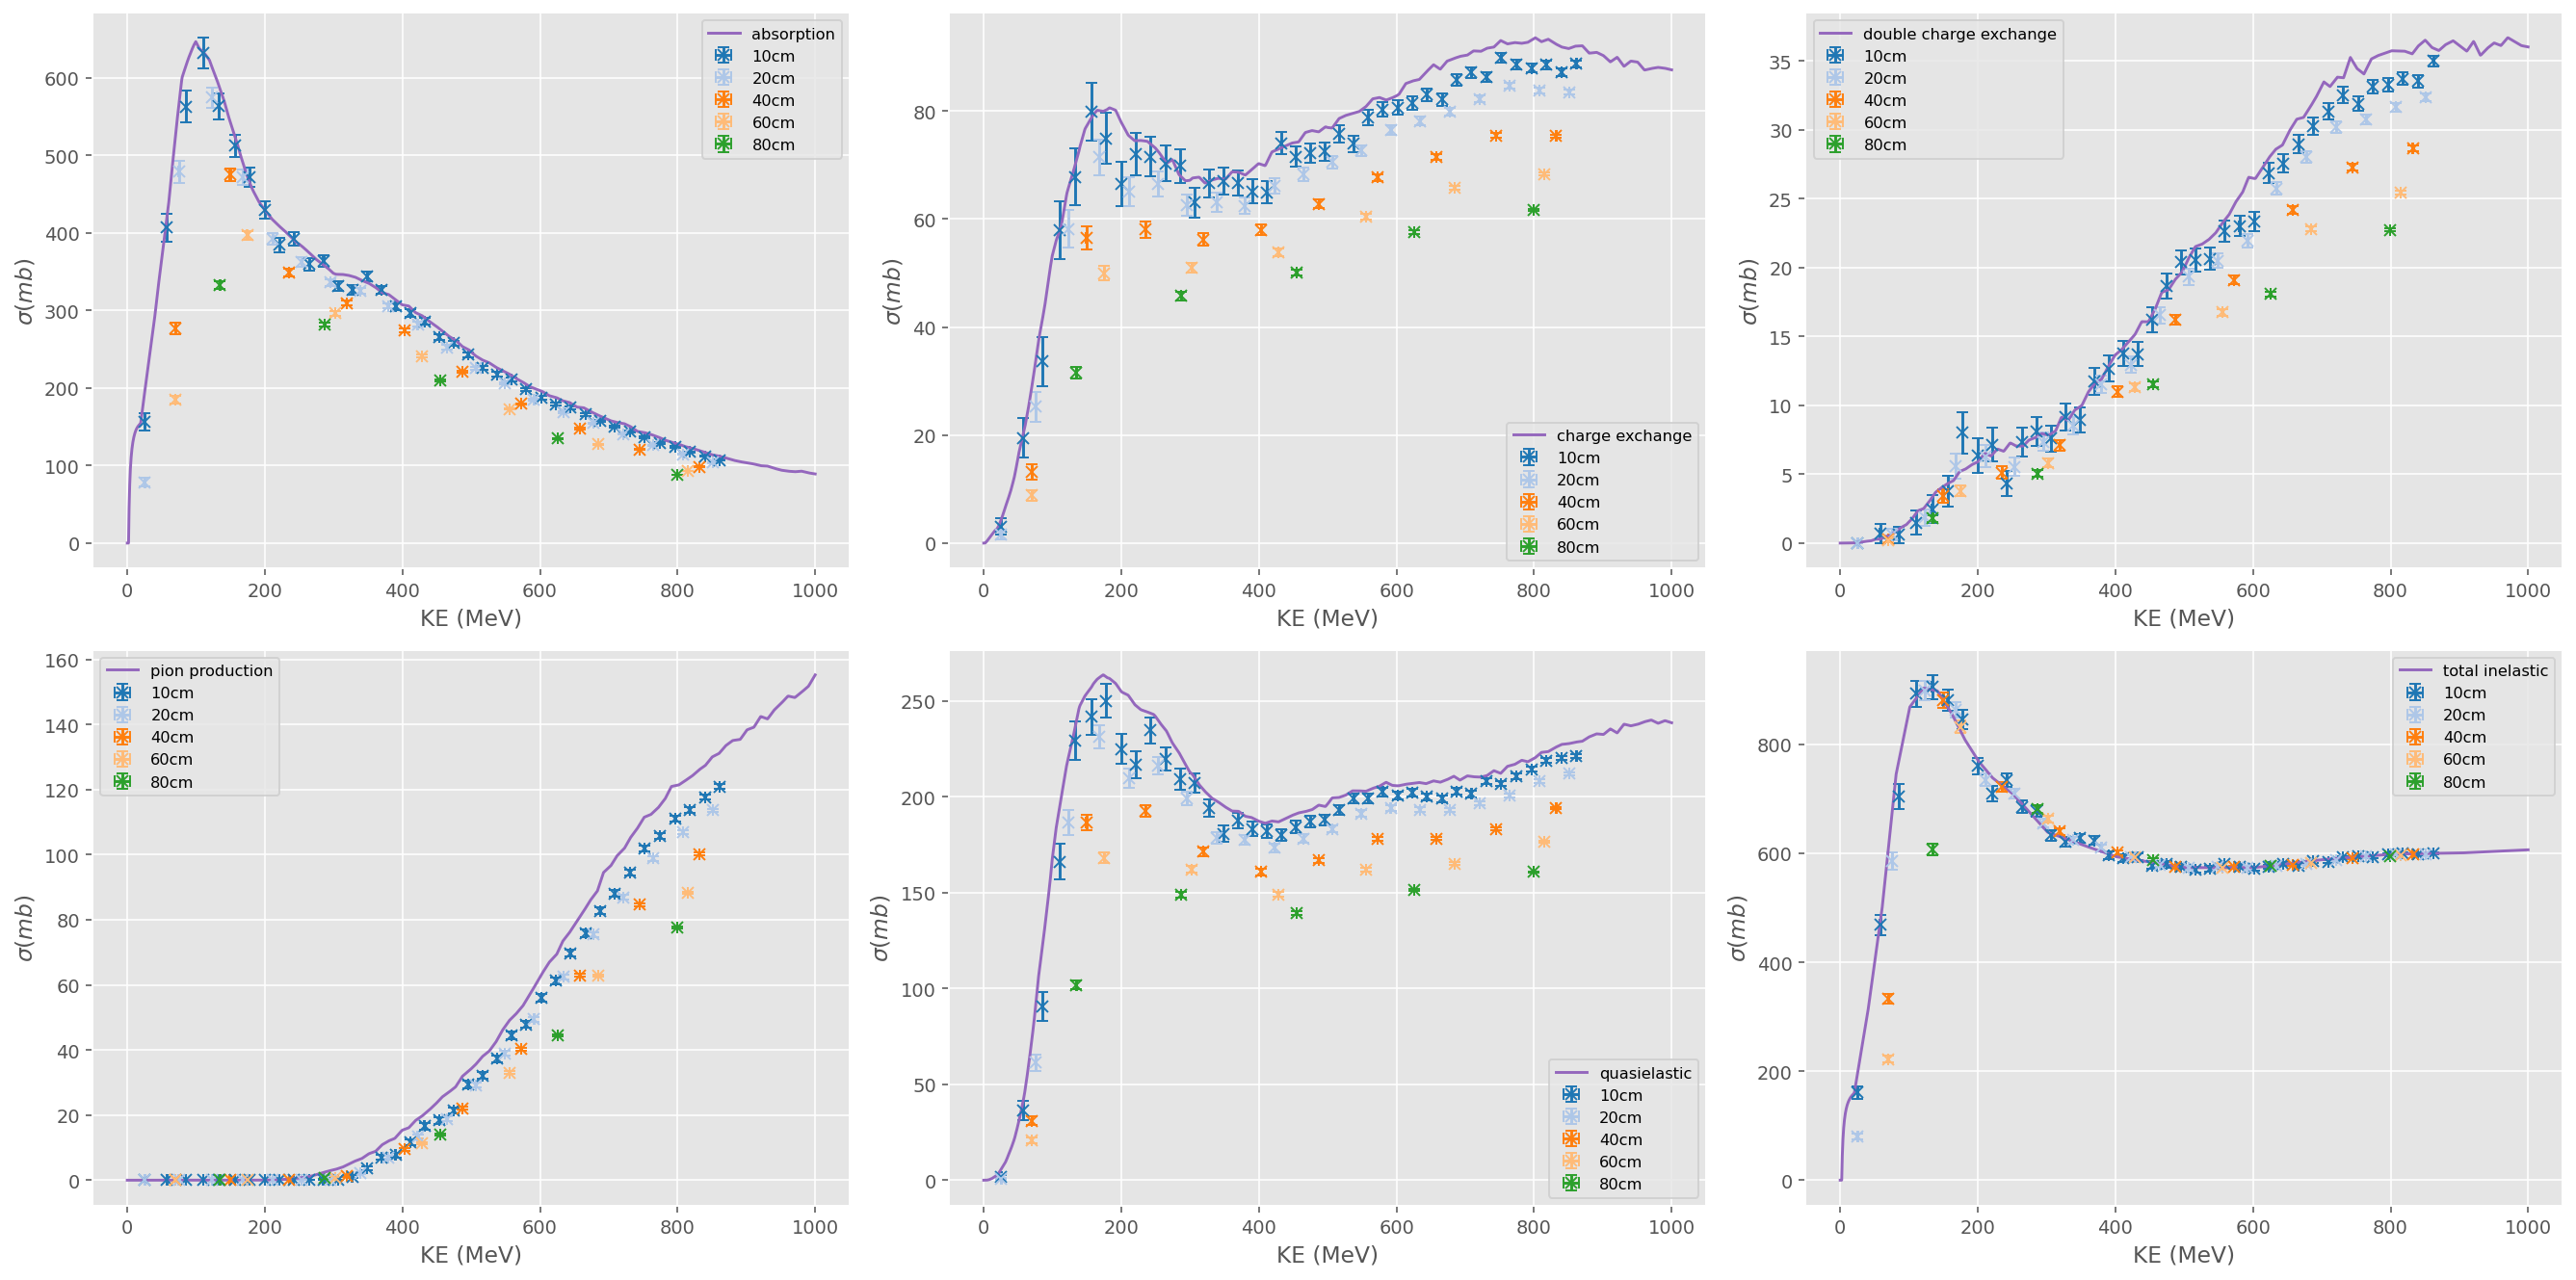

In [102]:
def ThinSliceWitdh(slice_widths : float, position_range : list):
    """ See how cross section varies as a function of slice thickness, using the single profile toy.

    Args:
        slice_width (float): spatial slice width (cm)
        position_range (list): min, max position for slices (cm)
    """
    slices = []
    mean_energy = []
    decayed = toy_single.inclusive_process == "decay"
    for s in slice_widths:
        slices.append(cross_section.Slices(s, min(position_range), max(position_range)))
        mean_energy.append(cross_section.ThinSlice.MeanSliceEnergy(toy_single.KE_int[~decayed], toy_single.z_int[~decayed], slices[-1]))

    for _, c in Plots.IterMultiPlot(toy_gaussian.exclusive_processes):
        hists = [cross_section.ThinSlice.CountingExperiment(toy_single.z_int, toy_single[c], slices[i]) for i in range(len(slice_widths))]
        xs = [cross_section.ThinSlice.CrossSection(hists[i][1], hists[i][0], slices[i].width) for i in range(len(slice_widths))]

        geant_xs.Plot(c, color = "C8")
        for i in range(len(slice_widths)):
            Plots.Plot(mean_energy[i][0], xs[i][0], xerr = mean_energy[i][1], yerr = xs[i][1], marker = "x", linestyle = "", newFigure = False, label = f"{slice_widths[i]}cm")
    pdf.Save()
    return

ThinSliceWitdh([10, 20, 40, 60, 80], [-10, 720])
pdf.close()

In [104]:
def PlotMeanEnergies(pos : np.array, energy : np.array, slices : cross_section.Slices, range : list = None):
    """ Plot energies in each spatial slice in a giant subplot

    Args:
        pos (np.array): position
        energy (np.array): kinetic energy
        slices (cross_section.Slices): spatial slices
        range (list, optional): energy range. Defaults to None.
    """
    for _, s in Plots.IterMultiPlot(list(slices)):
        mask = slices.pos_to_num(pos) == s.num
        e = energy[mask]
        if len(e) == 0:
            plt.gcf().delaxes(plt.gca())
            continue
        Plots.PlotHist(e, title = s.__str__(), range = range, xlabel = "$KE^{true}_{int}$ (MeV)", newFigure = False)


def PlotMeanEnergiesSplit(pos : np.array, energy : np.array, slices : cross_section.Slices, range : list = None):
    """ Plot energies in each spatial slice in it's own figure, and save to a pdf file.

    Args:
        pos (np.array): position
        energy (np.array): kinetic energy
        slices (cross_section.Slices): spatial slices
        range (list, optional): energy range. Defaults to None.
    """
    pdf = Plots.PlotBook("gaussian_toy_energy_bins.pdf")
    for s in list(slices):
        mask = slices.pos_to_num(pos) == s.num
        e = energy[mask]
        if len(e) == 0: continue
        Plots.PlotHist(e, title = s.__str__(), range = range, xlabel = "$KE^{true}_{int}$ (MeV)")
        pdf.Save()
        plt.close() # still causes the plot to be rendered in the terminal output.
        plt.cla()
    pdf.close()


# Encorperating particle decays

particles have essentially three options when passing through a thin target:
 1. interact with the material inelastically
 2. pass through (this includes elasitc sccatters)
 3. decay

if we treat elastic scatters as essentially no interaction, then just sampling from the inelastic PDF covers the first two cases, but not the third. In order to do the third, try the following:
 1. for each particle, compute a lifetime at the start of the simulation, this can be done with the typical exponential decay of particles and the particle lifetime in the pdg database
 2. keep track of each particles time as it passes through the TPC, note this muse be done for each particle separately as we allow distributions of kinetic energy. This is done at each thin target using the relation to $\beta$ and $KE$ derived below
 3. if the particles current time exceeds it's lifetime, classify it as decayed i.e. it did not survive.

Including this affect should lower the number of interactions at the low energy regime and thus elminate this issue of the cross section diverging. Note this means we need to also keep track of $\beta$ as the particle looses energy in each slice.

## Derivation of $\beta$
$$ KE = \sqrt{p^{2} + m^{2}} - m = \sqrt{(m\beta\gamma)^{2} + m^{2}} - m = \sqrt{\left(\frac{m\beta}{\sqrt{1 - \beta^{2}}}\right)^{2} + m^{2}} = \sqrt{\frac{m^{2}\beta^{2}}{1 - \beta^{2}} + m^{2}} = m\sqrt{\frac{\beta^{2}}{1 - \beta^{2}} + 1} $$

$$ \left(\frac{KE}{m}\right)^{2} - 1 = \frac{\beta^{2}}{1 - \beta^{2}} $$

$$ \beta^{2} = \left(\left(\frac{KE}{m}\right)^{2} - 1\right)\left(1 - \beta^{2}\right) = \left(\left(\frac{KE}{m}\right)^{2} - 1\right) - \left(\left(\frac{KE}{m}\right)^{2} - 1\right)\beta^{2} $$

$$ \left(\frac{KE}{m}\right)^{2} - 1 = \beta^{2} + \left(\left(\frac{KE}{m}\right)^{2} - 1\right)\beta^{2} = \left(\frac{KE}{m}\right)^{2}\beta^{2} $$

$$ \beta^{2} = \frac{\left(\frac{KE}{m}\right)^{2} - 1 }{ \left(\frac{KE}{m}\right)^{2} }$$

$$\therefore \beta = \sqrt{1 - \frac{1}{ \left(\frac{KE}{m}\right)^{2} }} $$


## Particle lifetime
$$ N(t) = N_{0} e^{-\frac{t}{\tau}} $$

$$ P_{decay} = e^{-\frac{t}{\tau}} $$

$$\ln\left( P_{decay} \right) = -\frac{t}{tau} $$

$$ t = -\tau\ln\left( P_{decay} \right) $$

So, sample from a random uniform distribution to get $P_{int}$

## Time elapsed at current slice
$$ t_{elapsed} = l \beta $$

# Spatial slice method

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:650: RuntimeWarning: invalid value encountered in divide
  mean_energy = sum_energy / counts
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:652: RuntimeWarning: invalid value encountered in divide
  std_energy = np.divide(sum_energy_sqr, counts) - mean_energy**2


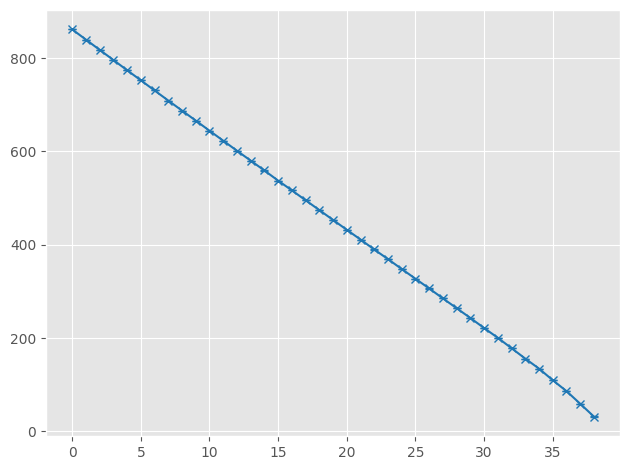

In [5]:
slices = cross_section.Slices(10, -10, 720)
mean_energy = cross_section.ThinSlice.MeanSliceEnergy(toy_single.KE_int[toy_single.total_inelastic], toy_single.z_int[toy_single.total_inelastic], slices)

Plots.Plot(slices.num[:-1], mean_energy[0], marker = "x", yerr = mean_energy[1])

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:670: RuntimeWarning: invalid value encountered in divide
  xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:673: RuntimeWarning: invalid value encountered in divide
  v_interact = n_interact*(1- (n_interact/n_incident)) # binomial uncertainty
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:675: RuntimeWarning: divide by zero encountered in divide
  xs_e = (1/n_incident) * (1/(n_incident - n_interact)) * (n_interact**2 * v_incident + n_incident**2 * v_interact)**0.5


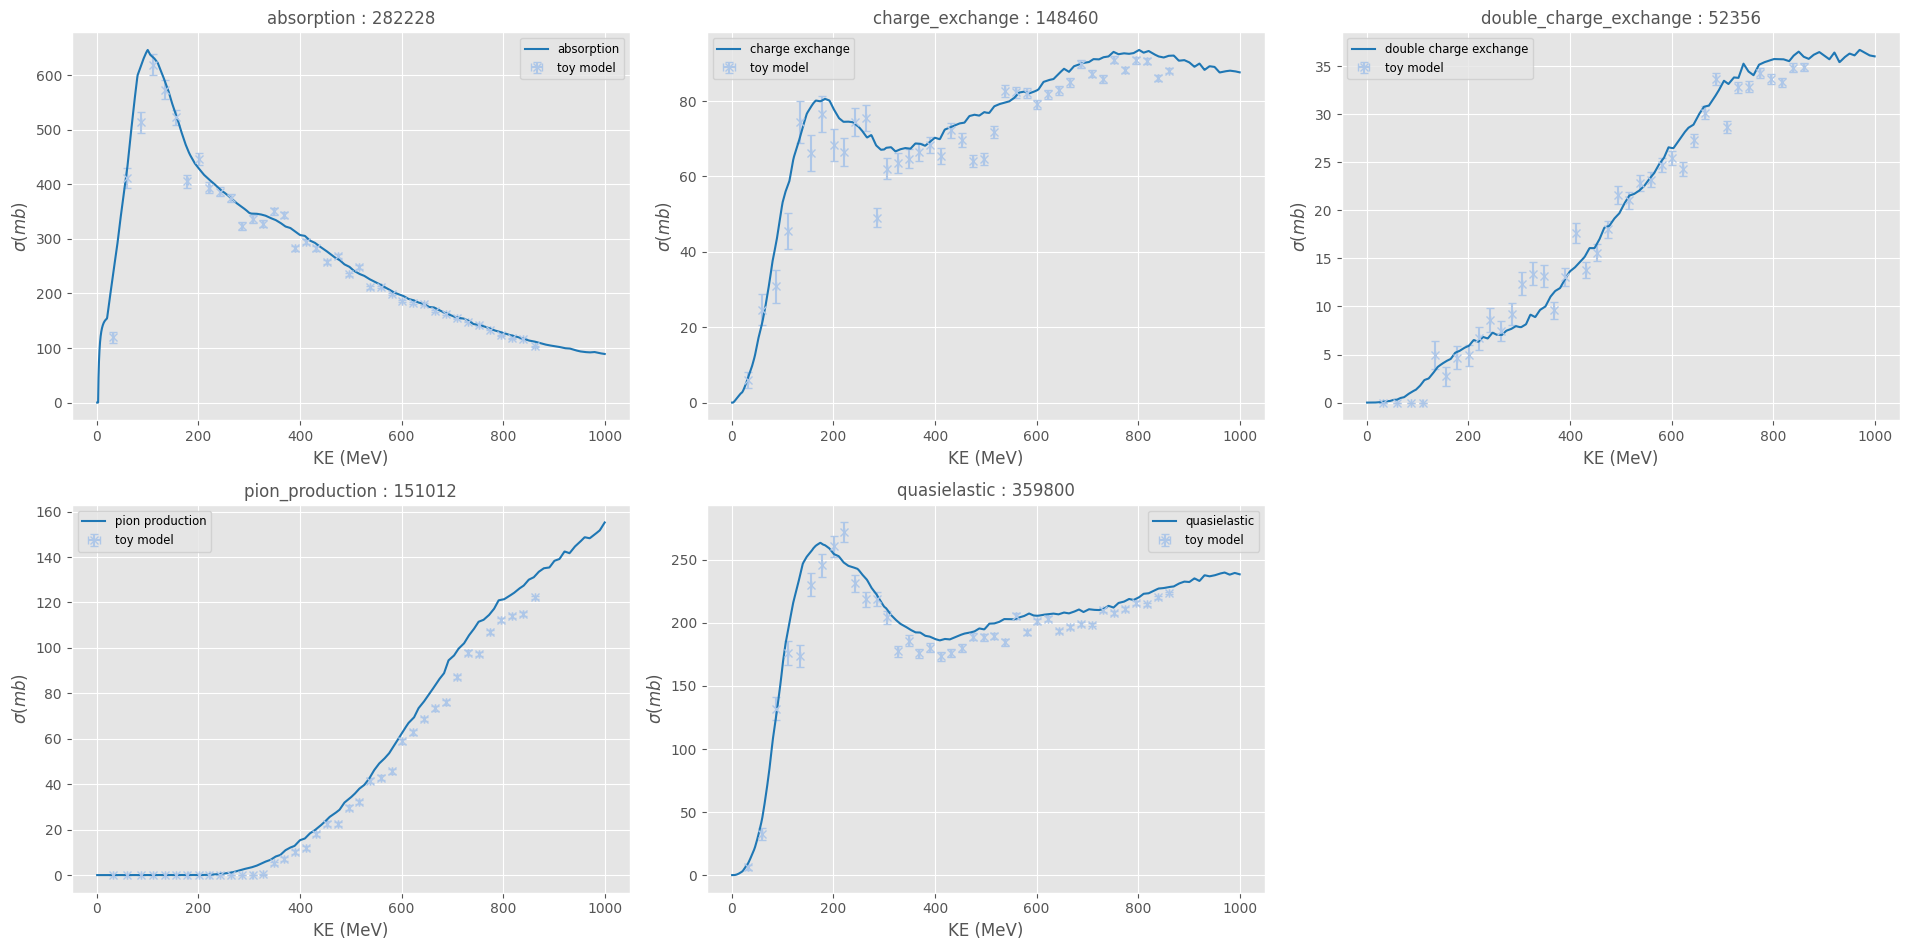

In [19]:
hists = {c : cross_section.ThinSlice.CountingExperiment(toy_single.z_int, toy_single[c], slices) for c in exclusive_processes}
xs = {c : cross_section.ThinSlice.CrossSection(hists[c][1], hists[c][0], slices.width) for c in exclusive_processes}

for i, c in Plots.IterMultiPlot(exclusive_processes, sharex = True):
    geant_xs.Plot(c)
    Plots.Plot(mean_energy[0], xs[c][0], xerr = mean_energy[1], yerr = xs[c][1], marker = "x", linestyle = "", newFigure = False, label = "toy model", title = f"{c} : {sum(toy_single[c])}")